## Clustering/Team Identification

This notebook contains code to crop out the detected players from Detector notebook and group them into clusters such that we can segregate the detected persons into two teams, locate referee(s), manager(s) and goalkeeper(s), if and when applicable. 

Since it is important for the graph neural network (in the next step) to have players tagged with the correct team label with respect to the position of the team on the pitch, we modify the predicted labels such that the two clusters with the most number of objects are tagged as team 0 and 1. We form another synthetic list in which 0s and 1s are swapped in the modified labels. This is done under the assumption that the number of players on the pitch is mostly greater than the number of referees (generally 1 or 2), managers and goalkeepers (occassionally 1) in the broadcast frame.

### Clustering

In [20]:
import numpy as np
from clustimage import Clustimage

from matplotlib import image

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import os
import sys
import cv2

In [21]:
#Prepare the Data in coco format
paths=['downloads/SoccerPass/SoccerPass-COCO/train.json']

import json
import pandas as pd
from pandas import json_normalize

dfs= []
for path in paths:
    # Load the COCO data from the JSON file
    with open(path) as f:
        coco_data = json.load(f)

    # Normalize the data into a DataFrame
    images_df = json_normalize(coco_data['images'])
    annotations_df = json_normalize(coco_data['annotations'])

    images_df=images_df.drop(columns=['license', 'flickr_url','coco_url', 'date_captured'])
    annotations_df=annotations_df.drop(columns=['segmentation', 'area','attributes.occluded','attributes.rotation','iscrowd'])
    annotations_df[['x', 'y', 'width', 'height']]=pd.DataFrame(annotations_df['bbox'].to_list())

    annotations_df['x'] = annotations_df['x'] + annotations_df['width']//2
    annotations_df['y'] = annotations_df['y'] + annotations_df['height']//2


    merged_df = pd.merge(annotations_df, images_df, right_on='id',left_on="image_id", how='left')

    merged_df['x'] = merged_df['x'] /merged_df['width_y']
    merged_df['width_x'] = merged_df['width_x'] /merged_df['width_y']
    merged_df['y'] = merged_df['y'] /merged_df['height_y']
    merged_df['height_x'] = merged_df['height_x'] /merged_df['height_y']


    merged_df['new_id'] = merged_df.groupby('image_id').cumcount() + 1
    merged_df=merged_df.drop(columns=['id_x', 'image_id', 'bbox', 'id_y', 'width_y', 'height_y'])

    new_columns = {'category_id': 'class',
                'attributes.Team': 'team',
                'attributes.Ball_Possesion': 'Ball_Possesion',
                'attributes.Ball_Reciever': 'Ball_Reciever',
                'width_x': 'w',
                'height_x': 'h',
                'file_name': 'image_name',
                'new_id': 'OID'}

    merged_df = merged_df.rename(columns=new_columns)


    # merged_df.to_csv("mer.csv",index=False)

    dfs.append(merged_df)

label_df=pd.concat(dfs)


In [22]:
label_df

,class,Ball_Possesion,Ball_Reciever,team,x,y,w,h,image_name,OID
0,1,0,0,1,0.982031,0.319444,0.030469,0.123611,image_vics_1342.png,1
1,2,NaN,NaN,NaN,0.337500,0.595833,0.011719,0.020833,image_vics_1342.png,2
2,1,0,0,0,0.735156,0.084722,0.020313,0.062500,image_vics_1342.png,3
3,1,0,0,0,0.200781,0.130556,0.018750,0.065278,image_vics_1342.png,4
4,1,0,0,1,0.586719,0.391667,0.030469,0.119444,image_vics_1342.png,5
...,...,...,...,...,...,...,...,...,...,...
16306,1,0,0,0,0.326562,0.472222,0.022656,0.094444,image_vimp_689.png,14
16307,1,0,0,2,0.421328,0.358333,0.017734,0.094444,image_vimp_689.png,15
16308,1,0,1,0,0.237500,0.223611,0.025000,0.059722,image_vimp_689.png,16
16309,1,0,0,0,0.327344,0.397222,0.018750,0.070833,image_vimp_689.png,17


The function **pre_process_crop** is used to crop the detected player from the image with the given bbox dimensions, resize each crop and apply filters to remove noise and enhance images.

In [23]:
def pre_process_crop(image, bbox):
    H = image.shape[0]
    W = image.shape[1]

    x = int(bbox[0]*W)
    y = int(bbox[1]*H)
    w = int(bbox[2]*W)
    h = int(bbox[3]*H)
    
    #Extracting Crop from given image with bbox specs
    crop = image[y:y+h, x:x+w]
    crop = cv2.resize(crop, (20,40))

    #Applying filters to the crop
    crop = cv2.medianBlur(crop,3)
    crop = cv2.bilateralFilter(crop,5,30,30)
    

    return crop

We create a function to evaluate the accuracy of the predicted labels:


In [24]:
def calc_acc(pred_labels, true_labels):
    n = len(true_labels)
    count=0
    for ix in range(n):
        if (true_labels[ix]==pred_labels[ix]):
            count+=1
  
    return count/n

The function **formatPred** modifies the predicted labels after clustering such that the two clusters with the most number of objects are tagged as team 0 and 1 and generate another set of labels where are 0 and 1 labels are swapped.

In [25]:
def formatPred(pred):
    # Generate a tuple of the format (count of label, label) and sort in decerasing order of frequency
    y = np.unique(pred, return_counts=True) 
    z = sorted(zip(y[1], y[0]), reverse=True)
    
    res = pred.copy()
    i=0
    
    # Generating the first set of modified labels
    for tup in z:
        idx_list = np.where(pred == tup[1])[0]

        for idx in idx_list:
            res[idx] = i
        i+=1
    
    # Flipping 0 and 1 to generate the second set of modified labels
    b = []
    for ele in res:
        if ele == 0:
            b.append(1)
        elif ele == 1:
            b.append(0)
        else:
            b.append(ele)
    b =  np.array(b, dtype=np.int32)   
    fin = [res, b]
    
    return fin

In [26]:
# Path where images are stored
paths = ['downloads/SoccerPass/SoccerPass-COCO/images/train']

Creating a pipeline for clustering. We use **clustimage** library for the clustering process. As described by the creators [here](https://github.com/erdogant/clustimage), the aim of clustimage is to detect natural groups or clusters of images. It works using a multi-step proces of carefully pre-processing the images, extracting the features, and evaluating the optimal number of clusters across the feature space. 

In [27]:
def cluster(yolo_df):
    total_boxes = 0
    total_misclassified = 0
  
    groups = yolo_df.groupby("image_name")


    # loop through each group and apply the code snippet to each image
    for image_name, group in groups:
        image_path = None
        for path in paths:
            temp_path = os.path.join(path, image_name)
            # Check if image exists in the path
            if os.path.exists(temp_path):
                image_path = temp_path
                break
      
        if image_path is None:
            raise ValueError(f"Image file not found: {image_name}")
        
        #Loading image
        img = image.imread(image_path)
        
        #Keeping data for players only (Class = 1)
        players_info = group[group['class'] == 1]
        
        #Storing the ground truth values for team each player belongs to
        true_labels = np.array(players_info['team'].tolist(), dtype=np.int32)
        num_cats = len(pd.unique(players_info['team'])) 
        
        #List to store flattened image of each crop.
        player_boxes = []
        
        for index, row in players_info.iterrows():
            bbox = [row['x']-(row['w']/2), row['y']-(row['h']/2), row['w'], row['h']]
            crop = pre_process_crop(img, bbox)
            player_boxes.append(crop)
        
        #Flattening the images and normalizing
        player_boxes_reshaped = np.array(player_boxes).reshape(len(player_boxes),-1)
        player_boxes_reshaped = player_boxes_reshaped/255.0
        
        #Creating model for clustering
        cl = Clustimage(method='pca',
                    embedding='tsne',
                    grayscale=False,
                    dim=(20,40),
                    params_pca={'n_components':0.95},
                    verbose=60)
        #Fitting and forming clusters 
        results = cl.fit_transform(player_boxes_reshaped,
                                cluster='agglomerative',
                                evaluate='silhouette',
                                metric='euclidean',
                                linkage='ward',
                                min_clust=num_cats,
                                max_clust=num_cats,
                                cluster_space='high')
        
        #Obtaining predicted labels
        pred_labels = results['labels']
        
        # Modifying the labels as described
        res = formatPred(pred_labels)
        
        # Keeping only the modified labels with the greater accuracy.
        if (calc_acc(res[0], true_labels) > calc_acc(res[1], true_labels)):
            acc = calc_acc(res[0], true_labels)
            preds = res[0]
        else:
            acc = calc_acc(res[1], true_labels)
            preds = res[1]

        total_boxes += group.shape[0]
        total_misclassified += round(group.shape[0]*(1-acc))
        
        # Storing the predicted team data in the dataframe
        i = 0
        for index, row in players_info.iterrows():
            if(row['class'] == 2):
                continue
            yolo_df.loc[index, 'pred_team'] = int(preds[i])
            i+=1
        print("name: {}, accuracy: {}, preds: {}, misclassified: {}, total boxes: {}".format(image_name, acc, preds, round(players_info.shape[0]*(1-acc)), players_info.shape[0]))

    print("total_boxes: {} ,  total_misclassified: {}".format(total_boxes, total_misclassified))
    
    return yolo_df



In [28]:
clustered_df = cluster(label_df)

[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 841.89it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 2 2 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.45013442]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 2 2 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prmw_1239.png, accuracy: 1.0, preds: [1 1 0 0 0 1 1 1 1 0 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 797.40it/s]
[clustimage] >DEBUG> [[2 1 3 2 1 3 3 2 1 3 1 1 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23475963]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 2 1 3 3 2 1 3 1 1 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1241.png, accuracy: 0.75, preds: [2 1 0 2 1 0 0 2 1 0 1 1 0 1 1 1], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 864.09it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 1 2 2 1 1 2 2 2 1 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35275252]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 1 2 2 1 1 2 2 2 1 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1242.png, accuracy: 0.8333333333333334, preds: [0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 2 1 1], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 847.85it/s]
[clustimage] >DEBUG> [[1 1 1 3 3 2 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26570038]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 3 2 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1243.png, accuracy: 0.7, preds: [0 0 0 1 1 2 0 1 0 2], misclassified: 3, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 824.84it/s]
[clustimage] >DEBUG> [[1 1 4 3 1 1 1 3 4 3 1 3 4 1 4 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24639995]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 4 3 1 1 1 3 4 3 1 3 4 1 4 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1246.png, accuracy: 0.5882352941176471, preds: [0 0 1 2 0 0 0 2 1 2 0 2 1 0 1 0 3], misclassified: 7, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 901.42it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3153512]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prmw_1247.png, accuracy: 1.0, preds: [0 0 0 0 0 1 1 1], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 888.62it/s]
[clustimage] >DEBUG> [[1 2 1 1 2 2 2 2 1 1 1 2 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23336086]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 2 2 2 2 1 1 1 2 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1248.png, accuracy: 0.9333333333333333, preds: [0 1 0 0 1 1 1 1 0 0 0 1 2 0 1], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 873.63it/s]
[clustimage] >DEBUG> [[1 3 1 3 1 2 3 3 3 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31602754]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 3 1 2 3 3 3 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1249.png, accuracy: 1.0, preds: [0 1 0 1 0 2 1 1 1 1 0 0 2], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 882.83it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34271962]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prmw_1250.png, accuracy: 1.0, preds: [1 0 0 0 0 1 0 1], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 833.03it/s]
[clustimage] >DEBUG> [[1 1 1 3 3 3 2 1 3 1 3 2 3 3 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31059262]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 3 3 2 1 3 1 3 2 3 3 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1251.png, accuracy: 1.0, preds: [0 0 0 1 1 1 2 0 1 0 1 2 1 1 1 0 0 0], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 899.49it/s]
[clustimage] >DEBUG> [[1 1 3 2 2 2 1 2 2 2 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28437385]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 2 2 2 1 2 2 2 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1252.png, accuracy: 1.0, preds: [1 1 2 0 0 0 1 0 0 0 0 1 1 1 1], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 881.53it/s]
[clustimage] >DEBUG> [[3 3 3 1 1 1 3 2 1 3 2 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21817989]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 1 1 1 3 2 1 3 2 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1253.png, accuracy: 0.7333333333333333, preds: [1 1 1 0 0 0 1 2 0 1 2 0 2 0 1], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 729.70it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 2 2 1 1 2 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27782249]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 2 2 1 1 2 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1254.png, accuracy: 0.9333333333333333, preds: [0 0 0 0 0 1 1 1 1 0 0 1 2 1 1], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 915.39it/s]
[clustimage] >DEBUG> [[2 1 3 2 1 2 1 1 2 3 2 1 2 1 1 3 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2613437]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 2 1 2 1 1 2 3 2 1 2 1 1 3 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1255.png, accuracy: 0.7894736842105263, preds: [1 0 2 1 0 1 0 0 1 2 1 0 1 0 0 2 0 2 2], misclassified: 4, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 849.57it/s]
[clustimage] >DEBUG> [[1 1 3 1 3 3 1 2 1 2 2 3 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26776063]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 3 3 1 2 1 2 2 3 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1256.png, accuracy: 0.8666666666666667, preds: [0 0 1 0 1 1 0 2 0 2 2 1 0 1 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 979.75it/s]
[clustimage] >DEBUG> [[3 3 1 1 3 3 2 2 3 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28056713]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 3 3 2 2 3 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1258.png, accuracy: 0.3076923076923077, preds: [1 1 2 2 1 1 0 0 1 2 0 2 0], misclassified: 9, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 955.20it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 1 2 2 2 1 1 2 2 3 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31491267]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 1 2 2 2 1 1 2 2 3 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1259.png, accuracy: 0.9411764705882353, preds: [1 0 1 0 0 0 1 1 1 0 0 1 1 2 1 0 1], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 894.31it/s]
[clustimage] >DEBUG> [[2 1 1 2 1 1 2 2 2 3 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2822811]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 1 1 2 2 2 3 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1260.png, accuracy: 1.0, preds: [1 0 0 1 0 0 1 1 1 2 0 1 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 947.01it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 2 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3245479]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 2 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prmw_1261.png, accuracy: 1.0, preds: [0 0 0 1 0 1 1 1 0 0 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.16it/s]
[clustimage] >DEBUG> [[2 2 1 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32558433]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prmw_1262.png, accuracy: 1.0, preds: [1 1 0 1 1 0 0], misclassified: 0, total boxes: 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1043.10it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25991893]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prmw_1263.png, accuracy: 0.875, preds: [1 0 0 0 1 1 1 0], misclassified: 1, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 978.15it/s]
[clustimage] >DEBUG> [[1 2 1 1 3 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36549258]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 3 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1264.png, accuracy: 0.6666666666666666, preds: [0 2 0 0 1 1 0 0 2], misclassified: 3, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1021.51it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37297733]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prmw_1265.png, accuracy: 0.875, preds: [0 0 1 0 0 1 1 1], misclassified: 1, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 972.25it/s]
[clustimage] >DEBUG> [[1 1 3 1 3 2 1 3 3 2 1 3 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30015471]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 3 2 1 3 3 2 1 3 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1266.png, accuracy: 0.8125, preds: [0 0 1 0 1 2 0 1 1 2 0 1 0 1 0 0], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 957.39it/s]
[clustimage] >DEBUG> [[3 3 1 2 1 1 1 3 1 3 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28868609]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 2 1 1 1 3 1 3 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1267.png, accuracy: 1.0, preds: [1 1 0 2 0 0 0 1 0 1 0 1 1 2], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 912.80it/s]
[clustimage] >DEBUG> [[1 4 2 1 2 2 3 2 1 1 1 1 1 2 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26548941]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 4 2 1 2 2 3 2 1 1 1 1 1 2 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1268.png, accuracy: 0.8235294117647058, preds: [1 3 0 1 0 0 2 0 1 1 1 1 1 0 1 0 2], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 930.41it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33290541]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prmw_1270.png, accuracy: 1.0, preds: [1 0 0 0 0 1 1 1 1], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 844.43it/s]
[clustimage] >DEBUG> [[1 3 2 1 1 4 2 2 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28136827]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 1 4 2 2 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1271.png, accuracy: 0.8333333333333334, preds: [0 3 1 0 0 2 1 1 0 0 1 0], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 354.40it/s]
[clustimage] >DEBUG> [[2 3 1 1 1 3 1 3 3 3 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31720887]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 1 1 3 1 3 3 3 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1272.png, accuracy: 1.0, preds: [2 1 0 0 0 1 0 1 1 1 0 0 1 2], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 861.43it/s]
[clustimage] >DEBUG> [[1 2 3 3 3 2 1 2 1 3 3 1 2 4 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.18322645]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 3 3 2 1 2 1 3 3 1 2 4 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1274.png, accuracy: 0.35294117647058826, preds: [2 1 0 0 0 1 2 1 2 0 0 2 1 3 1 2 1], misclassified: 11, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 695.80it/s]
[clustimage] >DEBUG> [[3 1 2 2 2 1 2 2 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.18099108]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 2 2 1 2 2 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1275.png, accuracy: 0.8333333333333334, preds: [2 0 1 1 1 0 1 1 0 1 1 0], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1019.02it/s]
[clustimage] >DEBUG> [[3 2 1 1 2 2 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2745142]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 2 2 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1276.png, accuracy: 0.9, preds: [2 0 1 1 0 0 0 1 0 1], misclassified: 1, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 920.01it/s]
[clustimage] >DEBUG> [[4 3 4 1 1 3 4 1 4 3 2 2 2 2 4 2 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.17059276]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 4 1 1 3 4 1 4 3 2 2 2 2 4 2 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1277.png, accuracy: 0.6470588235294118, preds: [1 2 1 3 3 2 1 3 1 2 0 0 0 0 1 0 1], misclassified: 6, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 833.53it/s]
[clustimage] >DEBUG> [[1 1 4 1 4 2 2 3 3 1 4 4 3 4 2 4 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.15645476]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 4 1 4 2 2 3 3 1 4 4 3 4 2 4 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1279.png, accuracy: 0.4444444444444444, preds: [2 2 1 2 1 0 0 3 3 2 1 1 3 1 0 1 1 0], misclassified: 10, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 970.01it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 2 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31031358]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 2 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1280.png, accuracy: 0.9166666666666666, preds: [0 0 0 0 0 1 1 1 1 0 0 2], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 881.90it/s]
[clustimage] >DEBUG> [[1 1 1 2 3 3 1 3 2 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34399995]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 3 3 1 3 2 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1281.png, accuracy: 1.0, preds: [0 0 0 2 1 1 0 1 2 0 1 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 773.57it/s]
[clustimage] >DEBUG> [[1 3 2 1 2 3 1 1 1 3 1 3 3 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26944273]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 2 3 1 1 1 3 1 3 3 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1282.png, accuracy: 0.75, preds: [0 1 2 0 2 1 0 0 0 1 0 1 1 0 1 1], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 873.63it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 2 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27940514]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 2 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1283.png, accuracy: 1.0, preds: [0 0 0 1 0 1 0 2 1], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 879.86it/s]
[clustimage] >DEBUG> [[2 3 1 1 2 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19716904]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 1 2 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1284.png, accuracy: 0.8, preds: [1 2 0 0 1 1 0 1 0 0], misclassified: 2, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 833.69it/s]
[clustimage] >DEBUG> [[3 2 1 1 1 2 1 2 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32954619]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 1 2 1 2 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1286.png, accuracy: 0.9230769230769231, preds: [2 0 1 1 1 0 1 0 0 1 0 1 1], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 816.01it/s]
[clustimage] >DEBUG> [[3 2 1 3 1 3 1 1 3 1 3 3 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26873026]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 3 1 3 1 1 3 1 3 3 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1287.png, accuracy: 0.9333333333333333, preds: [1 2 0 1 0 1 0 0 1 0 1 1 2 0 1], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 905.12it/s]
[clustimage] >DEBUG> [[2 2 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.47116905]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prmw_1288.png, accuracy: 1.0, preds: [1 1 0 0 1 0 1], misclassified: 0, total boxes: 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 717.83it/s]
[clustimage] >DEBUG> [[2 2 2 1 2 2 1 1 1 1 2 1 1 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2639817]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 2 2 1 1 1 1 2 1 1 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1289.png, accuracy: 0.9375, preds: [1 1 1 0 1 1 0 0 0 0 1 0 0 2 1 1], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 776.44it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 3 2 2 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25112517]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 3 2 2 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1291.png, accuracy: 0.8333333333333334, preds: [0 0 0 1 0 2 1 1 0 0 1 1], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 776.00it/s]
[clustimage] >DEBUG> [[1 3 1 1 2 1 3 2 3 2 3 2 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26316175]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 2 1 3 2 3 2 3 2 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1293.png, accuracy: 0.8125, preds: [0 1 0 0 2 0 1 2 1 2 1 2 0 0 1 0], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 814.74it/s]
[clustimage] >DEBUG> [[3 1 2 3 1 3 1 1 1 2 1 2 3 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28055333]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 3 1 3 1 1 1 2 1 2 3 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1294.png, accuracy: 0.8125, preds: [1 0 2 1 0 1 0 0 0 2 0 2 1 0 1 2], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 756.96it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 2 1 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37222456]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 2 1 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1295.png, accuracy: 0.9090909090909091, preds: [0 1 1 1 0 1 0 0 0 0 2], misclassified: 1, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 805.67it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35739918]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prmw_1296.png, accuracy: 1.0, preds: [0 1 0 1 1 0 0 1], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.29it/s]
[clustimage] >DEBUG> [[4 3 4 1 1 1 1 1 2 2 2 2 2 3 1 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29553564]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 4 1 1 1 1 1 2 2 2 2 2 3 1 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1299.png, accuracy: 0.8823529411764706, preds: [2 3 2 0 0 0 0 0 1 1 1 1 1 3 0 0 2], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 613.92it/s]
[clustimage] >DEBUG> [[2 2 2 1 3 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33317615]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 3 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1301.png, accuracy: 0.7777777777777778, preds: [0 0 0 1 2 1 0 1 1], misclassified: 2, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 832.04it/s]
[clustimage] >DEBUG> [[1 2 3 3 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.18111188]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 3 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1302.png, accuracy: 0.625, preds: [1 2 0 0 1 1 1 2], misclassified: 3, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.77it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 2 1 2 3 1 1 2 3 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22900984]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 2 1 2 3 1 1 2 3 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1304.png, accuracy: 0.8823529411764706, preds: [0 1 1 1 0 1 0 1 2 0 0 1 2 0 1 1 2], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 749.79it/s]
[clustimage] >DEBUG> [[3 3 3 1 1 3 1 3 1 1 3 1 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24047011]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 1 1 3 1 3 1 1 3 1 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1305.png, accuracy: 0.7647058823529411, preds: [1 1 1 0 0 1 0 1 0 0 1 0 2 2 0 0 2], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 856.68it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22133087]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1306.png, accuracy: 0.75, preds: [0 0 0 2 0 0 0 1], misclassified: 2, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.47it/s]
[clustimage] >DEBUG> [[1 1 1 1 3 3 2 1 1 1 3 2 3 3 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24219802]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 3 3 2 1 1 1 3 2 3 3 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1308.png, accuracy: 0.7647058823529411, preds: [0 0 0 0 1 1 2 0 0 0 1 2 1 1 2 1 1], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 781.50it/s]
[clustimage] >DEBUG> [[3 1 3 1 3 3 1 3 3 1 1 2 1 3 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27515602]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 1 3 3 1 3 3 1 1 2 1 3 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1309.png, accuracy: 0.7647058823529411, preds: [1 0 1 0 1 1 0 1 1 0 0 2 0 1 2 2 0], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 827.44it/s]
[clustimage] >DEBUG> [[3 1 1 2 2 1 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2760556]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 2 1 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1310.png, accuracy: 1.0, preds: [2 0 0 1 1 0 1 0 0 1], misclassified: 0, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 621.10it/s]
[clustimage] >DEBUG> [[2 2 2 1 2 1 1 3 1 3 1 1 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33985179]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 2 1 1 3 1 3 1 1 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1311.png, accuracy: 0.9375, preds: [0 0 0 1 0 1 1 2 1 2 1 1 1 0 0 1], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 746.85it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 1 2 2 1 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25503834]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 1 2 2 1 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1312.png, accuracy: 1.0, preds: [1 1 1 1 1 0 1 1 0 0 0 0 2], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 806.13it/s]
[clustimage] >DEBUG> [[2 1 3 2 2 2 1 2 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29170708]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 2 2 2 1 2 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1313.png, accuracy: 0.9166666666666666, preds: [1 0 2 1 1 1 0 1 0 0 0 2], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.95it/s]
[clustimage] >DEBUG> [[3 4 4 1 1 3 1 4 2 1 1 1 4 4 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25166029]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 4 4 1 1 3 1 4 2 1 1 1 4 4 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1314.png, accuracy: 0.6875, preds: [2 1 1 0 0 2 0 1 3 0 0 0 1 1 2 3], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 781.06it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 1 1 1 2 1 1 1 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28422833]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 1 1 1 2 1 1 1 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1315.png, accuracy: 0.8125, preds: [1 1 0 0 0 1 1 1 0 1 1 1 1 2 1 1], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 803.66it/s]
[clustimage] >DEBUG> [[1 1 2 1 3 3 3 1 1 1 3 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35242439]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 3 3 3 1 1 1 3 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1316.png, accuracy: 0.9285714285714286, preds: [0 0 2 0 1 1 1 0 0 0 1 1 2 1], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 811.59it/s]
[clustimage] >DEBUG> [[1 2 1 2 3 1 2 2 2 1 1 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27598395]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 3 1 2 2 2 1 1 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1317.png, accuracy: 0.8666666666666667, preds: [0 1 0 1 2 0 1 1 1 0 0 1 1 0 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 837.52it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 2 2 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29929324]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 2 2 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1318.png, accuracy: 0.9166666666666666, preds: [0 0 0 1 0 0 1 1 0 1 2 1], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.01it/s]
[clustimage] >DEBUG> [[4 1 2 1 1 1 1 2 3 1 4 4 1 4 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28996327]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 1 2 1 1 1 1 2 3 1 4 4 1 4 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1319.png, accuracy: 0.75, preds: [1 0 3 0 0 0 0 3 2 0 1 1 0 1 2 0], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 797.70it/s]
[clustimage] >DEBUG> [[1 2 1 2 1 2 2 1 3 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2668294]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 1 2 2 1 3 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1320.png, accuracy: 0.7692307692307693, preds: [0 1 0 1 0 1 1 0 2 1 0 1 0], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 863.38it/s]
[clustimage] >DEBUG> [[3 1 1 3 1 1 2 2 1 1 2 3 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21301855]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 1 1 2 2 1 1 2 3 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1321.png, accuracy: 0.6, preds: [1 0 0 1 0 0 2 2 0 0 2 1 0 2 1], misclassified: 6, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 774.71it/s]
[clustimage] >DEBUG> [[1 1 3 3 1 3 3 1 2 1 1 2 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21512477]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 1 3 3 1 2 1 1 2 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1322.png, accuracy: 0.7333333333333333, preds: [1 1 0 0 1 0 0 1 2 1 1 2 1 0 2], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 773.00it/s]
[clustimage] >DEBUG> [[2 2 1 4 1 1 2 2 1 2 3 3 2 2 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21802093]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 4 1 1 2 2 1 2 3 3 2 2 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1324.png, accuracy: 0.8, preds: [1 1 0 2 0 0 1 1 0 1 3 3 1 1 2], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 843.58it/s]
[clustimage] >DEBUG> [[3 1 3 1 1 1 2 1 3 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21429232]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 1 1 1 2 1 3 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1325.png, accuracy: 0.7692307692307693, preds: [0 1 0 1 1 1 2 1 0 1 1 0 2], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 889.38it/s]
[clustimage] >DEBUG> [[3 3 1 1 3 2 2 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34323938]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 3 2 2 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1326.png, accuracy: 0.6666666666666666, preds: [1 1 0 0 1 2 2 2 0 0 0 0], misclassified: 4, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.38it/s]
[clustimage] >DEBUG> [[3 1 3 1 1 3 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24196435]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 1 1 3 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1327.png, accuracy: 0.7272727272727273, preds: [1 0 1 0 0 1 2 0 2 0 0], misclassified: 3, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 888.81it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30078238]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1328.png, accuracy: 1.0, preds: [1 0 1 0 0 1 0 1 2], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 781.06it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 1 1 2 2 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25417528]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 1 1 2 2 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1329.png, accuracy: 1.0, preds: [1 1 1 0 0 0 0 1 1 2 0 0 1], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 814.74it/s]
[clustimage] >DEBUG> [[2 2 1 3 1 3 2 1 2 1 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24888423]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 3 1 3 2 1 2 1 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1330.png, accuracy: 0.8571428571428571, preds: [1 1 0 2 0 2 1 0 1 0 1 0 0 1], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 824.19it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 2 2 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24174012]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 2 2 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1332.png, accuracy: 0.8181818181818182, preds: [1 1 1 0 1 0 0 0 1 1 2], misclassified: 2, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 750.73it/s]
[clustimage] >DEBUG> [[1 2 2 1 4 1 1 1 2 3 3 1 4 3 1 4 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28283747]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 4 1 1 1 2 3 3 1 4 3 1 4 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1333.png, accuracy: 0.7222222222222222, preds: [0 3 3 0 1 0 0 0 3 2 2 0 1 2 0 1 0 1], misclassified: 5, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 822.90it/s]
[clustimage] >DEBUG> [[2 3 2 2 4 2 2 3 2 2 3 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.16703832]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 2 4 2 2 3 2 2 3 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prmw_1334.png, accuracy: 0.8, preds: [0 1 0 0 3 0 0 1 0 0 1 1 1 2 2], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 784.13it/s]
[clustimage] >DEBUG> [[1 3 1 3 1 1 2 2 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22171943]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 3 1 1 2 2 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1335.png, accuracy: 0.7272727272727273, preds: [0 1 0 1 0 0 2 2 0 1 1], misclassified: 3, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 829.73it/s]
[clustimage] >DEBUG> [[1 1 2 3 1 1 3 2 3 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27269655]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 3 1 1 3 2 3 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1336.png, accuracy: 0.9166666666666666, preds: [0 0 2 1 0 0 1 2 1 1 1 0], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 758.05it/s]
[clustimage] >DEBUG> [[3 1 1 3 1 3 3 3 2 1 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21070258]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 1 3 3 3 2 1 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1337.png, accuracy: 0.9285714285714286, preds: [1 0 0 1 0 1 1 1 2 0 2 0 0 1], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 718.57it/s]
[clustimage] >DEBUG> [[1 1 1 3 3 2 2 3 3 3 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23165704]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 3 2 2 3 3 3 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1339.png, accuracy: 0.7142857142857143, preds: [0 0 0 1 1 2 2 1 1 1 0 2 0 0], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 805.05it/s]
[clustimage] >DEBUG> [[3 2 1 3 1 3 1 1 1 3 1 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.43503331]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 3 1 3 1 1 1 3 1 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prmw_1341.png, accuracy: 1.0, preds: [1 2 0 1 0 1 0 0 0 1 0 0 1 1 2], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.87it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 4 3 1 3 2 3 3 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28941436]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 4 3 1 3 2 3 3 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1026.png, accuracy: 0.8666666666666667, preds: [1 1 1 1 1 2 0 1 0 3 0 0 0 0 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 767.34it/s]
[clustimage] >DEBUG> [[1 1 2 1 2 2 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24064831]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 2 2 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1028.png, accuracy: 0.9, preds: [1 1 0 1 0 0 1 1 2 1], misclassified: 1, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 722.04it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 1 2 2 2 2 1 2 2 2 2 2 2 1 2 1 1 2 2 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31101652]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 1 2 2 2 2 1 2 2 2 2 2 2 1 2 1 1 2 2 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1029.png, accuracy: 0.9, preds: [1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0], misclassified: 3, total boxes: 30
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 793.47it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 1 1 2 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34459618]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 1 1 2 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1031.png, accuracy: 1.0, preds: [0 0 1 1 1 1 1 0 1 0 2], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.00it/s]
[clustimage] >DEBUG> [[1 3 3 1 3 1 1 3 3 3 3 3 2 3 2 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27706293]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 3 1 1 3 3 3 3 3 2 3 2 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1032.png, accuracy: 0.8095238095238095, preds: [0 1 1 0 1 0 0 1 1 1 1 1 2 1 2 0 0 0 0 0 0], misclassified: 4, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.92it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 1 1 1 2 2 2 1 2 1 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29380799]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 1 1 1 2 2 2 1 2 1 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1033.png, accuracy: 1.0, preds: [0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 2 1], misclassified: 0, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.89it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 1 1 1 1 1 1 1 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27086446]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 1 1 1 1 1 1 1 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1034.png, accuracy: 1.0, preds: [0 0 0 0 1 1 1 1 1 1 1 1 1 0 2 1], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 623.87it/s]
[clustimage] >DEBUG> [[2 3 2 2 2 1 1 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2750165]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 2 2 1 1 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1035.png, accuracy: 0.9090909090909091, preds: [1 2 1 1 1 0 0 1 0 1 0], misclassified: 1, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 803.81it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 1 1 1 1 1 1 1 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28781821]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 1 1 1 1 1 1 1 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1036.png, accuracy: 1.0, preds: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 1 0], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 768.33it/s]
[clustimage] >DEBUG> [[1 3 1 3 1 1 1 1 1 1 1 2 3 3 2 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23855423]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 3 1 1 1 1 1 1 1 2 3 3 2 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1037.png, accuracy: 0.9444444444444444, preds: [1 0 1 0 1 1 1 1 1 1 1 2 0 0 2 0 0 0], misclassified: 1, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.01it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 2 2 2 1 2 2 2 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28596567]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 2 2 2 1 2 2 2 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1038.png, accuracy: 1.0, preds: [0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 2], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 845.97it/s]
[clustimage] >DEBUG> [[2 2 1 2 2 3 1 1 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23158141]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 2 3 1 1 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1040.png, accuracy: 0.9166666666666666, preds: [0 0 1 0 0 2 1 1 0 0 1 0], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 824.03it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 1 2 2 2 2 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24599879]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 1 2 2 2 2 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1041.png, accuracy: 0.9333333333333333, preds: [0 0 0 0 0 1 0 0 0 0 1 1 1 1 1], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 742.22it/s]
[clustimage] >DEBUG> [[1 1 3 1 1 2 2 2 1 1 1 1 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31306997]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 1 2 2 2 1 1 1 1 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1042.png, accuracy: 1.0, preds: [1 1 2 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 816.01it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 1 3 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3082326]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 1 3 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1043.png, accuracy: 1.0, preds: [0 1 0 1 1 1 2 1 1 0 0], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 634.54it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 1 1 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28633304]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 1 1 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1044.png, accuracy: 1.0, preds: [0 0 0 0 0 1 1 2 1 1 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 769.46it/s]
[clustimage] >DEBUG> [[1 1 1 3 1 1 1 2 2 2 2 2 2 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20749918]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 1 1 1 2 2 2 2 2 2 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1045.png, accuracy: 0.9444444444444444, preds: [1 1 1 2 1 1 1 0 0 0 0 0 0 0 0 0 1 1], misclassified: 1, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 789.44it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 2 1 1 3 1 1 2 2 2 2 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25172876]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 2 1 1 3 1 1 2 2 2 2 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1046.png, accuracy: 1.0, preds: [1 0 0 0 0 0 1 1 2 1 1 0 0 0 0 2 0 1], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.57it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 1 1 1 2 3 3 3 3 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22651801]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 1 1 1 2 3 3 3 3 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1048.png, accuracy: 0.9375, preds: [1 1 1 1 2 1 1 1 2 0 0 0 0 0 0 0], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 829.08it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30991947]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.
[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.


name: image_prtl_1049.png, accuracy: 1.0, preds: [0 0 0 0 1 1 0 1 1], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.09it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36480635]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1050.png, accuracy: 0.875, preds: [1 0 0 1 1 2 0 0], misclassified: 1, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 769.31it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 1 1 1 3 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23138977]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 1 1 1 3 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1051.png, accuracy: 0.9230769230769231, preds: [1 0 0 0 0 1 1 1 2 1 0 0 0], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 774.86it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 2 2 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29641085]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 2 2 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1053.png, accuracy: 1.0, preds: [0 0 0 0 1 0 0 1 1 1 1 1], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 781.79it/s]
[clustimage] >DEBUG> [[3 2 2 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31881384]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 2 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1054.png, accuracy: 0.875, preds: [2 1 1 1 1 0 0 0], misclassified: 1, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 796.03it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34162427]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1055.png, accuracy: 1.0, preds: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 1], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.28it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 3 1 2 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31577681]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 3 1 2 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1056.png, accuracy: 0.9333333333333333, preds: [1 1 1 0 1 1 2 1 0 1 0 0 0 0 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 776.44it/s]
[clustimage] >DEBUG> [[3 2 1 3 4 1 1 1 2 2 3 3 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23153925]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 3 4 1 1 1 2 2 3 3 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1057.png, accuracy: 0.7333333333333333, preds: [0 2 1 0 3 1 1 1 2 2 0 0 0 0 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.65it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 1 1 3 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20844843]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 1 1 3 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1058.png, accuracy: 1.0, preds: [0 0 0 0 0 0 1 1 2 1 0 1 1 1], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 782.52it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 2 1 3 2 1 1 1 1 1 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36399047]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 2 1 3 2 1 1 1 1 1 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1060.png, accuracy: 1.0, preds: [0 0 0 0 0 0 0 1 2 0 1 1 1 1 1 1 0 1 1], misclassified: 0, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 794.38it/s]
[clustimage] >DEBUG> [[1 3 3 3 1 3 1 3 1 3 2 3 2 2 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26144894]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 3 1 3 1 3 1 3 2 3 2 2 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1061.png, accuracy: 0.8, preds: [0 1 1 1 0 1 0 1 0 1 2 1 2 2 0 0 0 0 0 0], misclassified: 4, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 708.02it/s]
[clustimage] >DEBUG> [[2 1 1 2 1 2 2 2 2 2 3 1 1 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35361432]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 1 2 2 2 2 2 3 1 1 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1062.png, accuracy: 1.0, preds: [0 1 1 0 1 0 0 0 0 0 2 1 1 1 1 1 1 0], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 695.92it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 2 1 3 2 3 2 1 3 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29282523]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 2 1 3 2 3 2 1 3 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1064.png, accuracy: 0.7058823529411765, preds: [0 0 0 0 0 0 2 0 1 2 1 2 0 1 2 1 1], misclassified: 5, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 800.90it/s]
[clustimage] >DEBUG> [[3 1 1 2 1 1 2 1 1 1 2 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27580913]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 1 1 2 1 1 1 2 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1065.png, accuracy: 0.9411764705882353, preds: [2 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 828.91it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31113699]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1066.png, accuracy: 1.0, preds: [0 1 1 0 0 0 1 1], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 793.02it/s]
[clustimage] >DEBUG> [[2 2 2 1 2 2 1 1 1 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25288451]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 2 2 1 1 1 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1068.png, accuracy: 1.0, preds: [0 0 0 1 0 0 1 1 1 2 1 1 1], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 834.52it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30390251]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1069.png, accuracy: 1.0, preds: [1 1 1 1 0 0 0 0], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 689.06it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.16787072]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1070.png, accuracy: 1.0, preds: [0 0 0 0 1 1], misclassified: 0, total boxes: 6
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 822.57it/s]
[clustimage] >DEBUG> [[4 3 3 4 2 3 3 1 1 1 1 1 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24751375]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 3 4 2 3 3 1 1 1 1 1 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1071.png, accuracy: 0.7142857142857143, preds: [2 1 1 2 3 1 1 0 0 0 0 0 0 2], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.71it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 1 2 1 1 2 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20774043]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 1 2 1 1 2 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1072.png, accuracy: 1.0, preds: [0 0 1 1 1 1 0 1 1 0 2 1 1 0], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 624.90it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 2 3 2 2 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26377491]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 2 3 2 2 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1073.png, accuracy: 0.9230769230769231, preds: [0 0 1 1 1 0 2 0 0 2 1 1 1], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 751.26it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 2 2 1 1 1 2 2 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32918813]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 2 2 1 1 1 2 2 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1075.png, accuracy: 1.0, preds: [0 0 0 0 1 1 0 0 1 1 1 0 0 1 2 1 1], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 747.51it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 2 1 3 2 1 1 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2642661]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 2 1 3 2 1 1 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1076.png, accuracy: 1.0, preds: [1 0 0 0 0 0 1 2 0 1 1 1 1 0 1 1 1], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.01it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 2 2 2 3 1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21220895]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 2 2 2 3 1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1078.png, accuracy: 1.0, preds: [1 0 1 1 1 1 0 0 0 2 1 1 0 0 0 0], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 766.92it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 2 2 2 1 1 3 1 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23107225]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 2 2 2 1 1 3 1 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1079.png, accuracy: 1.0, preds: [1 0 1 0 0 0 0 0 1 1 2 1 0 1 1 0], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 861.78it/s]
[clustimage] >DEBUG> [[3 1 1 1 2 2 1 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.43090301]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 2 2 1 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1080.png, accuracy: 1.0, preds: [2 1 1 1 0 0 1 1 0 0 0 0 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 728.18it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30303537]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1081.png, accuracy: 1.0, preds: [1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 2], misclassified: 0, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.83it/s]
[clustimage] >DEBUG> [[3 1 1 1 1 1 1 1 3 2 2 1 3 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2647678]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 1 1 1 1 3 2 2 1 3 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1082.png, accuracy: 0.8125, preds: [2 1 1 1 1 1 1 1 2 0 0 1 2 1 0 0], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 811.75it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 3 1 4 3 2 3 3 3 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24582759]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 3 1 4 3 2 3 3 3 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1083.png, accuracy: 0.8125, preds: [0 0 0 0 0 1 0 2 1 3 1 1 1 0 1 1], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.86it/s]
[clustimage] >DEBUG> [[3 1 1 1 1 2 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32016577]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 1 2 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1084.png, accuracy: 1.0, preds: [2 1 1 1 1 0 0 0 0 0 0], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 805.98it/s]
[clustimage] >DEBUG> [[3 2 3 3 2 3 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.1946554]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 3 2 3 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1085.png, accuracy: 0.8181818181818182, preds: [0 2 0 0 2 0 2 1 1 1 1], misclassified: 2, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 774.57it/s]
[clustimage] >DEBUG> [[1 1 1 1 3 1 1 1 2 2 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30402976]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 3 1 1 1 2 2 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1086.png, accuracy: 1.0, preds: [1 1 1 1 2 1 1 1 0 0 0 0 0 0 0], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 780.48it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 1 1 1 2 2 2 3 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28627798]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 1 1 1 2 2 2 3 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1087.png, accuracy: 1.0, preds: [0 1 1 1 1 1 1 1 0 0 0 2 0 0 0 0], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 805.20it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32206617]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1088.png, accuracy: 1.0, preds: [0 0 1 1 1 1 1 1], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.85it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 2 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3284514]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 2 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1089.png, accuracy: 0.9, preds: [0 1 1 1 1 0 1 0 0 0], misclassified: 1, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.68it/s]
[clustimage] >DEBUG> [[3 3 3 1 3 1 1 2 1 3 3 2 1 2 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26748135]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 1 3 1 1 2 1 3 3 2 1 2 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1092.png, accuracy: 0.8888888888888888, preds: [0 0 0 1 0 1 1 2 1 0 0 2 1 2 1 1 0 0], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 826.63it/s]
[clustimage] >DEBUG> [[2 2 2 2 4 1 1 3 3 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23542737]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 4 1 1 3 3 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1093.png, accuracy: 0.6363636363636364, preds: [1 1 1 1 2 3 3 0 0 0 2], misclassified: 4, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.07it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 2 2 3 1 2 4 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20742966]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 2 2 3 1 2 4 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1094.png, accuracy: 0.8571428571428571, preds: [1 0 0 0 0 0 0 3 1 0 2 1 1 0], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 842.74it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19956433]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1095.png, accuracy: 0.8571428571428571, preds: [1 1 1 1 1 2 0], misclassified: 1, total boxes: 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 794.07it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 1 1 1 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33790151]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 1 1 1 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1097.png, accuracy: 1.0, preds: [0 0 0 0 0 0 1 1 1 1 1 1 2], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 736.49it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 1 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30428004]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 1 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1098.png, accuracy: 1.0, preds: [0 0 0 1 1 1 1 2 1 0], misclassified: 0, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 795.43it/s]
[clustimage] >DEBUG> [[1 1 1 1 3 1 1 1 1 2 3 3 3 2 2 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22465825]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 3 1 1 1 1 2 3 3 3 2 2 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1100.png, accuracy: 0.7222222222222222, preds: [1 1 1 1 0 1 1 1 1 2 0 0 0 2 2 0 0 2], misclassified: 5, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 800.13it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 1 1 3 1 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31523659]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 1 1 3 1 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1101.png, accuracy: 1.0, preds: [0 0 0 0 0 1 1 2 1 1 1 1 1 0], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 824.51it/s]
[clustimage] >DEBUG> [[2 2 3 1 1 1 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25126602]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 1 1 1 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1102.png, accuracy: 1.0, preds: [0 0 2 1 1 1 1 0 0 0 0 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 767.34it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 1 1 1 2 1 3 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25383494]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 1 1 1 2 1 3 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1103.png, accuracy: 1.0, preds: [0 1 1 0 0 1 1 1 0 1 2 1 0 0 0], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 670.02it/s]
[clustimage] >DEBUG> [[3 4 2 1 1 1 1 3 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27154138]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 4 2 1 1 1 1 3 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1105.png, accuracy: 0.7, preds: [0 2 3 1 1 1 1 0 0 2], misclassified: 3, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 600.90it/s]
[clustimage] >DEBUG> [[3 1 1 1 2 3 3 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.17043503]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 2 3 3 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1106.png, accuracy: 0.6666666666666666, preds: [2 1 1 1 0 2 2 1 0 0 0 0], misclassified: 4, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 607.34it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 3 3 1 4 1 1 1 3 3 3 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29526166]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 3 3 1 4 1 1 1 3 3 3 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1107.png, accuracy: 0.7777777777777778, preds: [1 1 2 2 2 0 0 1 3 1 1 1 0 0 0 0 0 0], misclassified: 4, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 833.69it/s]
[clustimage] >DEBUG> [[1 2 2 2 3 1 1 1 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25262579]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 3 1 1 1 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1109.png, accuracy: 0.9230769230769231, preds: [1 0 0 0 2 1 1 1 1 1 0 0 0], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 780.77it/s]
[clustimage] >DEBUG> [[2 2 3 2 1 2 2 2 1 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32478285]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 2 1 2 2 2 1 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1111.png, accuracy: 1.0, preds: [1 1 2 1 0 1 1 1 0 0 0 0 0 0 0 0], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.87it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 2 2 2 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29947089]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 2 2 2 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1112.png, accuracy: 1.0, preds: [0 0 0 0 0 1 1 1 1 1 2 1 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.00it/s]
[clustimage] >DEBUG> [[1 3 3 3 1 3 3 3 3 3 3 3 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.1910179]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 3 1 3 3 3 3 3 3 3 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1113.png, accuracy: 0.6875, preds: [0 1 1 1 0 1 1 1 1 1 1 1 0 2 2 0], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 762.74it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 3 2 2 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22912937]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 3 2 2 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1114.png, accuracy: 0.8333333333333334, preds: [1 1 1 1 1 2 0 0 0 0 0 1], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.13it/s]
[clustimage] >DEBUG> [[2 2 1 2 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24310905]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1115.png, accuracy: 1.0, preds: [1 1 0 1 0 0 2 0], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.13it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 2 2 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33638458]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 2 2 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1116.png, accuracy: 0.9090909090909091, preds: [0 0 1 1 1 1 1 0 0 1 0], misclassified: 1, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 750.73it/s]
[clustimage] >DEBUG> [[3 2 1 2 2 3 1 1 1 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32815191]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 2 2 3 1 1 1 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1117.png, accuracy: 0.7692307692307693, preds: [2 0 1 0 0 2 1 1 1 0 1 0 1], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 730.08it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 3 3 3 2 3 3 3 4 3 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31967145]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 3 3 3 2 3 3 3 4 3 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1119.png, accuracy: 0.9411764705882353, preds: [0 0 0 0 0 1 1 1 3 1 1 1 2 1 1 1 0], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.71it/s]
[clustimage] >DEBUG> [[3 3 3 3 2 2 1 1 1 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24818906]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 2 2 1 1 1 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1120.png, accuracy: 0.7692307692307693, preds: [0 0 0 0 2 2 1 1 1 1 1 0 0], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 754.24it/s]
[clustimage] >DEBUG> [[3 3 3 3 3 2 3 1 1 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27547466]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 3 2 3 1 1 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1122.png, accuracy: 0.9333333333333333, preds: [1 1 1 1 1 2 1 0 0 0 0 2 0 0 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 726.92it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3867066]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1123.png, accuracy: 1.0, preds: [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 1 1 1 1 1], misclassified: 0, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 819.04it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 1 1 1 2 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32897905]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 1 1 1 2 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1124.png, accuracy: 0.8461538461538461, preds: [1 0 1 1 1 1 1 1 1 0 2 0 0], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 587.60it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 2 1 2 2 2 3 2 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30065106]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 2 1 2 2 2 3 2 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1125.png, accuracy: 1.0, preds: [0 0 1 1 0 1 0 1 1 1 2 1 1 1 0 0 0], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 593.42it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 1 2 2 2 2 2 2 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35360051]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 1 2 2 2 2 2 2 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1126.png, accuracy: 1.0, preds: [1 0 0 0 0 0 1 1 1 1 1 1 2 1 1], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 562.77it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39654863]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1127.png, accuracy: 1.0, preds: [1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 0 0], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 705.87it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 1 2 2 2 2 1 2 1 1 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25954462]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 1 2 2 2 2 1 2 1 1 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1129.png, accuracy: 0.9, preds: [1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0], misclassified: 2, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 738.04it/s]
[clustimage] >DEBUG> [[3 3 3 3 1 1 1 1 1 3 1 2 2 2 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25827029]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 1 1 1 1 1 3 1 2 2 2 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1130.png, accuracy: 0.7058823529411765, preds: [1 1 1 1 0 0 0 0 0 1 0 2 2 2 1 0 1], misclassified: 5, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 778.02it/s]
[clustimage] >DEBUG> [[3 3 1 3 2 2 2 2 2 2 2 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24176081]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 3 2 2 2 2 2 2 2 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1131.png, accuracy: 0.6875, preds: [2 2 1 2 0 0 0 0 0 0 0 2 1 1 1 1], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 760.80it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 1 1 1 2 2 2 1 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.42806647]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 1 1 1 2 2 2 1 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1132.png, accuracy: 1.0, preds: [1 1 1 1 1 0 0 0 1 1 1 0 0 2 0 1], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 777.44it/s]
[clustimage] >DEBUG> [[1 2 2 1 2 1 2 2 2 2 2 1 1 1 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35973559]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 2 1 2 2 2 2 2 1 1 1 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1133.png, accuracy: 1.0, preds: [0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 2], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 789.59it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 1 3 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29985948]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 1 3 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1134.png, accuracy: 1.0, preds: [1 1 1 1 1 1 0 2 0 0 0 0 0 0], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 762.18it/s]
[clustimage] >DEBUG> [[1 3 1 2 3 2 1 2 2 1 3 4 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19319157]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 3 2 1 2 2 1 3 4 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1135.png, accuracy: 0.35714285714285715, preds: [2 0 2 1 0 1 2 1 1 2 0 3 0 0], misclassified: 9, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 752.88it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 1 1 1 1 1 1 1 2 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34367461]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 1 1 1 1 1 1 1 2 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1136.png, accuracy: 1.0, preds: [1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 2], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 729.32it/s]
[clustimage] >DEBUG> [[4 1 1 3 3 1 1 3 2 1 3 1 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28588217]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 1 1 3 3 1 1 3 2 1 3 1 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1137.png, accuracy: 0.8, preds: [2 1 1 0 0 1 1 0 3 1 0 1 0 0 0], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.01it/s]
[clustimage] >DEBUG> [[3 1 1 2 2 2 4 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33871753]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 2 2 4 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1138.png, accuracy: 0.9, preds: [3 0 0 1 1 1 2 1 1 0], misclassified: 1, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 817.76it/s]
[clustimage] >DEBUG> [[1 3 1 2 1 1 1 2 2 2 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2376175]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 1 1 1 2 2 2 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1139.png, accuracy: 1.0, preds: [1 2 1 0 1 1 1 0 0 0 0 0 0 1], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.15it/s]
[clustimage] >DEBUG> [[2 2 3 1 2 2 1 2 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.11844378]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 1 2 2 1 2 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1140.png, accuracy: 1.0, preds: [1 1 2 0 1 1 0 1 1 1 0 0 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 720.42it/s]
[clustimage] >DEBUG> [[3 1 3 3 3 2 4 1 3 3 3 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2549476]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 3 3 2 4 1 3 3 3 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1142.png, accuracy: 0.875, preds: [1 0 1 1 1 3 2 0 1 1 1 0 0 0 0 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 778.02it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 2 2 2 1 3 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26806769]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 2 2 2 1 3 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1143.png, accuracy: 1.0, preds: [0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 666.40it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 1 2 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34514666]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 1 2 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1145.png, accuracy: 1.0, preds: [0 0 1 0 0 0 1 1 0 1 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 770.30it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 1 3 1 1 1 2 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25331966]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 1 3 1 1 1 2 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1146.png, accuracy: 1.0, preds: [0 0 0 1 1 1 2 1 1 1 0 0 1 0 0], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 690.31it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 2 2 2 1 1 1 3 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34766968]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 2 2 2 1 1 1 3 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1148.png, accuracy: 1.0, preds: [0 0 0 0 0 0 0 0 0 1 1 1 2 1 1 1 1 1 1], misclassified: 0, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 732.37it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 2 3 1 1 1 1 1 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3360534]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 2 3 1 1 1 1 1 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1149.png, accuracy: 1.0, preds: [0 0 0 0 0 0 0 2 1 1 1 1 1 0 1 1 1 0], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 745.39it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 1 1 2 1 1 3 2 2 2 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30845098]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 1 1 2 1 1 3 2 2 2 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1150.png, accuracy: 0.9411764705882353, preds: [0 1 1 1 1 1 1 0 1 1 2 0 0 0 0 0 2], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 781.94it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 1 1 3 2 2 1 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24386961]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 1 1 3 2 2 1 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1151.png, accuracy: 0.875, preds: [0 0 0 0 0 1 1 2 0 0 1 0 1 0 1 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.98it/s]
[clustimage] >DEBUG> [[1 1 1 1 3 1 1 1 1 2 2 3 2 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28538956]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 3 1 1 1 1 2 2 3 2 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1152.png, accuracy: 0.875, preds: [1 1 1 1 2 1 1 1 1 0 0 2 0 2 0 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 740.52it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 1 1 2 2 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33543395]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 1 1 2 2 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1153.png, accuracy: 1.0, preds: [0 1 1 1 1 1 1 0 0 0 0 2], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.29it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 2 2 2 2 2 2 1 3 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35011189]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 2 2 2 2 2 2 1 3 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1154.png, accuracy: 1.0, preds: [1 1 1 0 0 0 0 0 0 0 0 1 2 1 0 1 1], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 837.69it/s]
[clustimage] >DEBUG> [[2 1 2 3 1 1 1 1 1 1 2 2 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35910624]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 3 1 1 1 1 1 1 2 2 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1155.png, accuracy: 1.0, preds: [0 1 0 2 1 1 1 1 1 1 0 0 0 0 0 0 0], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 838.53it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 3 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26606146]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 3 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1156.png, accuracy: 1.0, preds: [0 0 0 0 0 0 2 1 1 1 1 1 1], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 776.87it/s]
[clustimage] >DEBUG> [[1 1 1 3 1 1 1 1 2 3 3 3 3 3 2 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32470726]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 1 1 1 1 2 3 3 3 3 3 2 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1157.png, accuracy: 0.8333333333333334, preds: [1 1 1 0 1 1 1 1 2 0 0 0 0 0 2 0 0 0], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 803.66it/s]
[clustimage] >DEBUG> [[1 2 1 1 3 1 1 1 1 2 2 2 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31188596]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 3 1 1 1 1 2 2 2 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1158.png, accuracy: 1.0, preds: [1 0 1 1 2 1 1 1 1 0 0 0 0 0 0 0 0], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 765.80it/s]
[clustimage] >DEBUG> [[1 1 1 3 1 2 2 1 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25803978]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 1 2 2 1 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1160.png, accuracy: 1.0, preds: [1 1 1 2 1 0 0 1 1 1 0 0 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 603.76it/s]
[clustimage] >DEBUG> [[1 1 1 1 3 2 2 1 1 1 2 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24580159]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 3 2 2 1 1 1 2 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1161.png, accuracy: 0.8666666666666667, preds: [0 0 0 0 2 1 1 0 0 0 1 1 1 1 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 615.09it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 2 2 1 1 1 1 2 1 3 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29604491]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 2 2 1 1 1 1 2 1 3 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1163.png, accuracy: 1.0, preds: [1 1 1 1 1 1 1 1 0 0 0 0 1 0 2 1 0 0 0], misclassified: 0, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 747.38it/s]
[clustimage] >DEBUG> [[2 2 3 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28867902]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1165.png, accuracy: 1.0, preds: [1 1 2 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0], misclassified: 0, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 879.49it/s]
[clustimage] >DEBUG> [[2 2 1 1 3 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31087581]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 3 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1167.png, accuracy: 0.875, preds: [1 1 0 0 2 1 1 0], misclassified: 1, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 870.55it/s]
[clustimage] >DEBUG> [[2 2 1 2 1 2 1 2 2 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33859119]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 1 2 1 2 2 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1168.png, accuracy: 1.0, preds: [0 0 1 0 1 0 1 0 0 1 2 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.13it/s]
[clustimage] >DEBUG> [[2 1 2 2 2 1 1 2 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25959475]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 2 1 1 2 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1169.png, accuracy: 0.8333333333333334, preds: [1 0 1 1 1 0 0 1 1 2 0 0], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.49it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 1 2 2 3 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28273224]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 1 2 2 3 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1170.png, accuracy: 0.8571428571428571, preds: [0 0 0 0 1 1 1 0 0 2 1 1 1 0], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.54it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 1 1 2 3 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28543096]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 1 1 2 3 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1171.png, accuracy: 0.9166666666666666, preds: [0 1 0 1 1 1 1 0 2 0 0 1], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 745.12it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 2 1 2 1 3 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29278107]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 2 1 2 1 3 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1172.png, accuracy: 0.9285714285714286, preds: [0 1 1 1 0 0 1 0 1 2 0 0 1 1], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.08it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 2 1 1 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.49296203]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 2 1 1 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1173.png, accuracy: 1.0, preds: [1 0 0 1 1 1 0 0 2 1 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.18it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 1 2 1 2 1 2 2 3 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31963918]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 1 2 1 2 1 2 2 3 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1174.png, accuracy: 0.9, preds: [1 1 1 1 1 0 0 1 0 1 0 1 0 0 2 0 1 1 1 0], misclassified: 2, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 853.37it/s]
[clustimage] >DEBUG> [[1 1 1 1 3 2 1 3 2 1 2 4 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22303193]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 3 2 1 3 2 1 2 4 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1175.png, accuracy: 0.8, preds: [0 0 0 0 2 1 0 2 1 0 1 3 2 0 1], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.70it/s]
[clustimage] >DEBUG> [[1 1 3 1 1 1 1 3 3 3 1 3 3 1 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27194923]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 1 1 1 3 3 3 1 3 3 1 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1176.png, accuracy: 0.8333333333333334, preds: [1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 2 0 2], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 819.52it/s]
[clustimage] >DEBUG> [[2 2 1 2 2 2 2 1 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.240229]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 2 2 2 1 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1177.png, accuracy: 1.0, preds: [1 1 0 1 1 1 1 0 0 2 0 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 760.80it/s]
[clustimage] >DEBUG> [[2 2 2 2 3 1 1 2 1 1 1 1 1 2 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25993004]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 3 1 1 2 1 1 1 1 1 2 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1178.png, accuracy: 0.8823529411764706, preds: [1 1 1 1 2 0 0 1 0 0 0 0 0 1 2 1 2], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.54it/s]
[clustimage] >DEBUG> [[3 1 3 1 3 3 1 3 4 3 1 3 2 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28518439]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 1 3 3 1 3 4 3 1 3 2 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1179.png, accuracy: 0.8235294117647058, preds: [1 0 1 0 1 1 0 1 3 1 0 1 2 0 0 1 2], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 783.25it/s]
[clustimage] >DEBUG> [[2 2 1 2 2 1 1 2 3 4 1 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36004428]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 2 1 1 2 3 4 1 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1180.png, accuracy: 0.875, preds: [0 0 1 0 0 1 1 0 3 2 1 0 0 1 1 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.05it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 1 2 1 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37580707]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 1 2 1 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1181.png, accuracy: 1.0, preds: [1 0 0 1 1 1 0 1 0 0 0 1], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 835.35it/s]
[clustimage] >DEBUG> [[1 2 1 2 1 1 2 2 1 2 2 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36076699]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 1 1 2 2 1 2 2 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1183.png, accuracy: 1.0, preds: [0 1 0 1 0 0 1 1 0 1 1 0 0 1 2], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 315.27it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 2 1 1 1 1 2 2 2 3 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3480539]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 2 1 1 1 1 2 2 2 3 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1184.png, accuracy: 1.0, preds: [0 0 1 1 0 1 0 0 0 0 1 1 1 2 1 1 0 0], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 828.75it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 3 1 1 1 4 2 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32226205]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 3 1 1 1 4 2 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1185.png, accuracy: 0.8666666666666667, preds: [1 0 0 0 0 3 1 1 1 2 0 1 1 0 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 753.83it/s]
[clustimage] >DEBUG> [[3 3 1 1 1 1 1 3 2 3 2 1 3 3 3 3 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23150955]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 1 1 1 3 2 3 2 1 3 3 3 3 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1188.png, accuracy: 0.8, preds: [0 0 1 1 1 1 1 0 2 0 2 1 0 0 0 0 0 1 1 1], misclassified: 4, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 802.43it/s]
[clustimage] >DEBUG> [[3 1 3 3 1 3 2 3 1 1 3 3 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28284795]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 3 1 3 2 3 1 1 3 3 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1189.png, accuracy: 0.8125, preds: [1 0 1 1 0 1 2 1 0 0 1 1 0 0 2 0], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 715.14it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 3 1 1 2 1 1 2 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3773506]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 3 1 1 2 1 1 2 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1190.png, accuracy: 0.8823529411764706, preds: [1 1 1 1 1 2 1 1 0 1 1 0 0 0 1 1 0], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 756.00it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 1 3 1 2 2 1 1 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28414935]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 1 3 1 2 2 1 1 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1191.png, accuracy: 0.9375, preds: [1 0 1 1 0 0 2 0 1 1 0 0 1 1 1 0], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 753.02it/s]
[clustimage] >DEBUG> [[1 1 1 3 3 3 1 1 1 1 2 1 3 3 3 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29446509]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 3 3 1 1 1 1 2 1 3 3 3 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1192.png, accuracy: 0.8333333333333334, preds: [1 1 1 0 0 0 1 1 1 1 2 1 0 0 0 0 2 1], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.92it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24961088]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1193.png, accuracy: 0.8888888888888888, preds: [1 0 1 0 0 0 1 1 0], misclassified: 1, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.11it/s]
[clustimage] >DEBUG> [[2 1 2 2 2 1 1 1 1 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31623309]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 2 1 1 1 1 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1194.png, accuracy: 1.0, preds: [1 0 1 1 1 0 0 0 0 0 0 1 2], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 722.66it/s]
[clustimage] >DEBUG> [[1 2 1 1 2 2 2 1 1 2 1 2 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31971]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 2 2 2 1 1 2 1 2 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1196.png, accuracy: 0.9375, preds: [0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 2], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.80it/s]
[clustimage] >DEBUG> [[3 3 1 1 3 1 3 3 3 2 1 3 1 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29917337]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 3 1 3 3 3 2 1 3 1 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1198.png, accuracy: 0.8235294117647058, preds: [1 1 0 0 1 0 1 1 1 2 0 1 0 0 2 0 1], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 755.19it/s]
[clustimage] >DEBUG> [[1 2 2 1 2 2 1 1 3 2 1 2 2 1 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3002]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 2 2 1 1 3 2 1 2 2 1 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1202.png, accuracy: 1.0, preds: [0 1 1 0 1 1 0 0 2 1 0 1 1 0 1 0 1 0], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 819.52it/s]
[clustimage] >DEBUG> [[2 2 3 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31863564]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1203.png, accuracy: 1.0, preds: [1 1 2 1 0 1 0 0], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.65it/s]
[clustimage] >DEBUG> [[2 2 2 2 3 2 1 1 1 1 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33416138]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 3 2 1 1 1 1 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1204.png, accuracy: 1.0, preds: [1 1 1 1 2 1 0 0 0 0 1 0 1 0], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 845.28it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 2 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32304095]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 2 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1205.png, accuracy: 0.9090909090909091, preds: [0 0 0 0 1 0 0 1 0 1 1], misclassified: 1, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 824.19it/s]
[clustimage] >DEBUG> [[1 2 1 2 1 2 2 1 1 2 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26090716]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 1 2 2 1 1 2 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1206.png, accuracy: 1.0, preds: [0 1 0 1 0 1 1 0 0 1 1 0 2], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 794.07it/s]
[clustimage] >DEBUG> [[3 3 1 1 1 3 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19319592]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 1 3 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1207.png, accuracy: 0.5, preds: [0 0 1 1 1 0 1 2 1 2], misclassified: 5, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 767.77it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 1 2 2 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21897335]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 1 2 2 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1209.png, accuracy: 0.9230769230769231, preds: [0 0 0 1 0 0 0 1 1 2 1 0 0], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 856.68it/s]
[clustimage] >DEBUG> [[1 2 2 1 3 1 1 1 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30402885]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 3 1 1 1 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1210.png, accuracy: 1.0, preds: [0 1 1 0 2 0 0 0 1 1 0 1], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 827.77it/s]
[clustimage] >DEBUG> [[1 2 2 1 2 1 2 1 2 3 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30193861]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 2 1 2 1 2 3 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1211.png, accuracy: 0.9230769230769231, preds: [1 0 0 1 0 1 0 1 0 2 1 0 1], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.37it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 2 2 2 1 1 3 2 1 2 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34274257]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 2 2 2 1 1 3 2 1 2 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1212.png, accuracy: 1.0, preds: [1 1 1 0 0 1 1 1 0 0 2 1 0 1 0 0 1 0], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.31it/s]
[clustimage] >DEBUG> [[1 2 1 2 1 2 3 1 3 1 2 1 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31777271]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 1 2 3 1 3 1 2 1 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1213.png, accuracy: 0.8125, preds: [1 0 1 0 1 0 2 1 2 1 0 1 0 1 0 1], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 778.31it/s]
[clustimage] >DEBUG> [[3 3 1 2 1 2 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21401634]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 2 1 2 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1214.png, accuracy: 0.5, preds: [0 0 1 2 1 2 1 1 2 0], misclassified: 5, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 820.96it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 3 2 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24753666]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 3 2 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1215.png, accuracy: 1.0, preds: [0 1 0 1 1 2 1 0 1 1 0], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 827.61it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 1 2 3 2 1 4 2 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20561445]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 1 2 3 2 1 4 2 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1216.png, accuracy: 0.8235294117647058, preds: [1 0 1 0 1 0 1 3 1 0 2 1 1 1 0 0 0], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 833.69it/s]
[clustimage] >DEBUG> [[1 1 1 3 2 2 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30400896]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 2 2 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1219.png, accuracy: 1.0, preds: [0 0 0 2 1 1 1 1 1 0 0], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 752.21it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 2 2 1 1 3 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23063234]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 2 2 1 1 3 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1220.png, accuracy: 0.875, preds: [0 0 0 0 1 1 0 0 1 1 2 0 0 0 1 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.48it/s]
[clustimage] >DEBUG> [[1 3 3 3 1 2 3 1 3 1 3 3 1 3 1 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26633044]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 3 1 2 3 1 3 1 3 3 1 3 1 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1222.png, accuracy: 0.9411764705882353, preds: [0 1 1 1 0 3 1 0 1 0 1 1 0 1 0 1 2], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.21it/s]
[clustimage] >DEBUG> [[1 1 2 3 2 2 2 2 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25780657]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 3 2 2 2 2 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1224.png, accuracy: 0.9166666666666666, preds: [0 0 1 2 1 1 1 1 0 0 2 0], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.13it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 2 1 1 1 1 1 2 3 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35688005]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 2 1 1 1 1 1 2 3 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1226.png, accuracy: 0.9411764705882353, preds: [0 1 1 1 0 1 0 0 0 0 0 1 2 0 1 2 1], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 806.29it/s]
[clustimage] >DEBUG> [[2 2 1 2 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29985931]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1228.png, accuracy: 1.0, preds: [0 0 1 0 1 0 0 1], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 708.02it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 2 2 1 1 2 2 2 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.41367598]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 2 2 1 1 2 2 2 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1230.png, accuracy: 1.0, preds: [1 0 1 0 0 1 1 0 0 1 1 1 1 0 2], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 773.43it/s]
[clustimage] >DEBUG> [[1 1 3 3 2 4 1 4 4 4 1 3 3 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22061174]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 2 4 1 4 4 4 1 3 3 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1231.png, accuracy: 0.4, preds: [2 2 1 1 3 0 2 0 0 0 2 1 1 1 0], misclassified: 9, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.70it/s]
[clustimage] >DEBUG> [[2 1 2 2 3 2 1 1 2 1 2 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31105791]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 3 2 1 1 2 1 2 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1232.png, accuracy: 1.0, preds: [1 0 1 1 2 1 0 0 1 0 1 1 0 1 0 0], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 774.86it/s]
[clustimage] >DEBUG> [[2 3 2 2 1 2 1 2 2 1 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3373264]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 2 1 2 1 2 2 1 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1233.png, accuracy: 1.0, preds: [1 2 1 1 0 1 0 1 1 0 0 0 0 0 1], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.18it/s]
[clustimage] >DEBUG> [[1 2 2 1 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36396372]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1234.png, accuracy: 1.0, preds: [0 1 1 0 1 0 0 1], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 866.23it/s]
[clustimage] >DEBUG> [[2 1 3 1 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25707901]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 1 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_prtl_1235.png, accuracy: 1.0, preds: [1 0 2 0 1 1 0 0 1], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 795.88it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 2 2 2 2 2 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32302753]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 2 2 2 2 2 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_prtl_1236.png, accuracy: 1.0, preds: [1 1 0 0 0 1 1 1 1 1 0 0 0 0 1], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 793.92it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 1 1 2 1 1 2 1 2 2 4 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25836975]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 1 1 2 1 1 2 1 2 2 4 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_prtl_1237.png, accuracy: 0.8333333333333334, preds: [1 0 0 1 1 0 0 1 0 0 1 0 1 1 2 3 1 1], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 789.74it/s]
[clustimage] >DEBUG> [[1 2 1 3 4 3 2 2 2 3 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24223094]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 4 3 2 2 2 3 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_1.png, accuracy: 0.6666666666666666, preds: [2 0 2 1 3 1 0 0 0 1 2 3], misclassified: 4, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 718.57it/s]
[clustimage] >DEBUG> [[1 2 1 2 3 2 1 2 2 1 1 1 2 2 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38640237]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 3 2 1 2 2 1 1 1 2 2 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_10.png, accuracy: 0.9444444444444444, preds: [0 1 0 1 2 1 0 1 1 0 0 0 1 1 1 0 1 1], misclassified: 1, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.00it/s]
[clustimage] >DEBUG> [[2 1 3 2 3 2 1 1 1 1 3 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36961289]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 2 3 2 1 1 1 1 3 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_100.png, accuracy: 0.8666666666666667, preds: [1 0 2 1 2 1 0 0 0 0 2 0 0 1 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.86it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 1 2 2 2 3 2 3 3 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2803299]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 1 2 2 2 3 2 3 3 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_101.png, accuracy: 0.8235294117647058, preds: [0 1 0 0 0 0 0 1 1 1 2 1 2 2 2 2 1], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 752.48it/s]
[clustimage] >DEBUG> [[1 2 1 3 1 1 1 3 3 3 1 3 2 1 3 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3060842]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 1 1 1 3 3 3 1 3 2 1 3 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_102.png, accuracy: 0.9444444444444444, preds: [0 2 0 1 0 0 0 1 1 1 0 1 2 0 1 0 1 0], misclassified: 1, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 697.89it/s]
[clustimage] >DEBUG> [[4 3 4 3 1 4 2 1 1 1 3 1 1 3 1 1 4 1 4 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23971216]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 4 3 1 4 2 1 1 1 3 1 1 3 1 1 4 1 4 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_103.png, accuracy: 0.8571428571428571, preds: [1 2 1 2 0 1 3 0 0 0 2 0 0 2 0 0 1 0 1 0 1], misclassified: 3, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 776.29it/s]
[clustimage] >DEBUG> [[1 1 2 3 3 3 3 3 1 3 1 1 1 1 1 1 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34042914]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 3 3 3 3 3 1 3 1 1 1 1 1 1 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_104.png, accuracy: 0.9473684210526315, preds: [0 0 2 1 1 1 1 1 0 1 0 0 0 0 0 0 1 2 2], misclassified: 1, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 768.19it/s]
[clustimage] >DEBUG> [[3 2 1 1 2 3 1 1 1 2 2 2 1 1 2 1 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26065531]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 2 3 1 1 1 2 2 2 1 1 2 1 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_105.png, accuracy: 0.9, preds: [2 0 1 1 0 2 1 1 1 0 0 0 1 1 0 1 1 0 0 1], misclassified: 2, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [15] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 762.88it/s]
[clustimage] >DEBUG> [[1 3 2 2 1 1 4 1 2 4 1 4 4 4 1 3 4 4 4 4 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21533436]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 2 1 1 4 1 2 4 1 4 4 4 1 3 4 4 4 4 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_106.png, accuracy: 0.6818181818181818, preds: [0 3 2 2 0 0 1 0 2 1 0 1 1 1 0 3 1 1 1 1 1 2], misclassified: 7, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 740.78it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 2 1 3 1 1 1 3 3 1 3 4 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23001438]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 2 1 3 1 1 1 3 3 1 3 4 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_107.png, accuracy: 0.7647058823529411, preds: [2 0 2 0 2 2 0 1 0 0 0 1 1 0 1 3 1], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 732.25it/s]
[clustimage] >DEBUG> [[4 2 2 2 2 4 4 1 4 4 4 4 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25750254]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 2 2 2 2 4 4 1 4 4 4 4 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_108.png, accuracy: 0.8, preds: [1 0 0 0 0 1 1 3 1 1 1 1 2 2 3], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 729.95it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 2 1 1 2 2 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39059227]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 2 1 1 2 2 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_11.png, accuracy: 1.0, preds: [0 0 0 1 0 0 1 0 0 1 1 0 1 1 2], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 768.89it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 2 2 2 1 3 1 1 4 2 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24045045]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 2 2 2 1 3 1 1 4 2 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_111.png, accuracy: 0.9411764705882353, preds: [0 1 0 0 0 1 1 1 0 2 0 0 3 1 1 1 2], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 795.88it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 2 2 2 3 2 1 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31833597]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 2 2 2 3 2 1 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_112.png, accuracy: 0.9375, preds: [1 0 1 1 0 1 1 1 2 1 0 1 0 0 0 0], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 740.39it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 1 1 2 2 1 1 4 2 1 1 2 3 1 1 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35123872]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 1 1 2 2 1 1 4 2 1 1 2 3 1 1 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_113.png, accuracy: 0.8181818181818182, preds: [0 1 1 1 0 1 1 0 0 1 1 3 0 1 1 0 2 1 1 2 0 0], misclassified: 4, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [16] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 756.00it/s]
[clustimage] >DEBUG> [[4 1 4 1 4 4 1 1 4 4 1 4 3 1 4 2 3 3 3 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24386073]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 1 4 1 4 4 1 1 4 4 1 4 3 1 4 2 3 3 3 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_114.png, accuracy: 0.7391304347826086, preds: [1 0 1 0 1 1 0 0 1 1 0 1 2 0 1 3 2 2 2 0 0 3 0], misclassified: 6, total boxes: 23
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.09it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 1 1 2 1 2 1 1 2 2 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33845725]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 1 1 2 1 2 1 1 2 2 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_115.png, accuracy: 0.8888888888888888, preds: [1 0 1 1 0 0 0 1 0 1 0 0 1 1 0 2 0 1], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 827.93it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 1 1 1 1 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34425124]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 1 1 1 1 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_116.png, accuracy: 1.0, preds: [1 0 0 0 1 1 1 1 1 0 0 0 1], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 775.14it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 1 2 2 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.46227764]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 1 2 2 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_117.png, accuracy: 1.0, preds: [0 1 0 1 1 1 0 0 0 0 1 1 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 758.46it/s]
[clustimage] >DEBUG> [[3 1 1 3 2 2 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23503233]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 2 2 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_118.png, accuracy: 0.6, preds: [0 1 1 0 2 2 0 1 1 2], misclassified: 4, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 811.75it/s]
[clustimage] >DEBUG> [[3 1 1 3 1 1 1 4 1 1 3 3 4 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29612938]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 1 1 1 4 1 1 3 3 4 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_12.png, accuracy: 0.875, preds: [1 0 0 1 0 0 0 2 0 0 1 1 2 1 1 3], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.31it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 1 3 3 4 2 4 1 4 3 4 4 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23516312]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 1 3 3 4 2 4 1 4 3 4 4 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_120.png, accuracy: 0.5294117647058824, preds: [0 2 0 2 0 2 3 3 1 0 1 2 1 3 1 1 1], misclassified: 8, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 706.71it/s]
[clustimage] >DEBUG> [[3 4 1 1 2 1 1 4 2 4 1 4 3 2 4 1 1 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25469138]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 4 1 1 2 1 1 4 2 4 1 4 3 2 4 1 1 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_121.png, accuracy: 0.7894736842105263, preds: [3 0 1 1 2 1 1 0 2 0 1 0 3 2 0 1 1 1 0], misclassified: 4, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.99it/s]
[clustimage] >DEBUG> [[4 1 1 1 3 2 1 3 1 4 2 3 3 3 3 1 2 1 1 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27600219]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 1 1 1 3 2 1 3 1 4 2 3 3 3 3 1 2 1 1 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_123.png, accuracy: 0.8571428571428571, preds: [2 0 0 0 1 3 0 1 0 2 3 1 1 1 1 0 3 0 0 1 2], misclassified: 3, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 830.72it/s]
[clustimage] >DEBUG> [[1 2 1 1 2 4 2 1 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21756126]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 2 4 2 1 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_124.png, accuracy: 0.6666666666666666, preds: [0 1 0 0 1 2 1 0 1 0 0 3], misclassified: 4, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 784.42it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 1 1 2 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34390765]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 1 1 2 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_125.png, accuracy: 1.0, preds: [0 0 0 1 1 0 0 1 2 1 2], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 754.91it/s]
[clustimage] >DEBUG> [[4 4 1 4 3 1 1 2 2 3 2 1 2 4 2 3 2 2 1 2 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20364725]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 4 1 4 3 1 1 2 2 3 2 1 2 4 2 3 2 2 1 2 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_126.png, accuracy: 0.5238095238095238, preds: [0 0 2 0 3 2 2 1 1 3 1 2 1 0 1 3 1 1 2 1 0], misclassified: 10, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.25it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 2 1 2 2 2 3 2 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3476372]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 2 1 2 2 2 3 2 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_128.png, accuracy: 0.9375, preds: [1 1 1 0 1 0 1 0 0 0 2 0 1 0 0 1], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.15it/s]
[clustimage] >DEBUG> [[3 4 1 3 3 2 4 4 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27720876]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 4 1 3 3 2 4 4 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_129.png, accuracy: 0.8, preds: [0 1 3 0 0 2 1 1 0 1], misclassified: 2, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 633.77it/s]
[clustimage] >DEBUG> [[1 3 1 1 3 3 1 1 3 2 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35896102]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 3 3 1 1 3 2 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_13.png, accuracy: 0.7857142857142857, preds: [1 0 1 1 0 0 1 1 0 2 1 1 2 1], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 589.92it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 1 3 1 1 1 1 2 3 1 1 2 2 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3460247]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 1 3 1 1 1 1 2 3 1 1 2 2 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_130.png, accuracy: 0.9523809523809523, preds: [0 0 0 0 0 1 2 1 1 1 1 0 2 1 1 0 0 1 2 1 1], misclassified: 1, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.01it/s]
[clustimage] >DEBUG> [[3 3 2 1 3 3 2 1 3 1 1 3 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30331999]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 1 3 3 2 1 3 1 1 3 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_131.png, accuracy: 0.625, preds: [1 1 2 0 1 1 2 0 1 0 0 1 0 0 1 1], misclassified: 6, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 828.10it/s]
[clustimage] >DEBUG> [[4 2 1 4 1 1 4 4 1 1 4 2 2 3 1 3 1 4 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29488387]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 2 1 4 1 1 4 4 1 1 4 2 2 3 1 3 1 4 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_132.png, accuracy: 0.7142857142857143, preds: [0 2 1 0 1 1 0 0 1 1 0 2 2 3 1 3 1 0 2 1 1], misclassified: 6, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 818.56it/s]
[clustimage] >DEBUG> [[3 3 1 2 3 1 1 1 1 3 2 2 1 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39401853]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 2 3 1 1 1 1 3 2 2 1 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_133.png, accuracy: 0.9411764705882353, preds: [0 0 1 2 0 1 1 1 1 0 2 2 1 1 1 0 1], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 770.73it/s]
[clustimage] >DEBUG> [[2 1 2 3 1 1 3 2 1 1 4 2 3 3 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21463127]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 3 1 1 3 2 1 1 4 2 3 3 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_134.png, accuracy: 0.8333333333333334, preds: [0 1 0 2 1 1 2 0 1 1 3 0 2 2 0 1 1 0], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 796.19it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 4 1 2 2 2 1 1 4 1 4 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3447994]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 4 1 2 2 2 1 1 4 1 4 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_135.png, accuracy: 0.7647058823529411, preds: [1 0 0 0 1 2 1 0 0 0 1 1 2 1 2 3 3], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 812.85it/s]
[clustimage] >DEBUG> [[1 2 1 1 3 1 2 3 1 3 1 3 1 3 1 1 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39521647]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 3 1 2 3 1 3 1 3 1 3 1 1 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_136.png, accuracy: 0.75, preds: [1 2 1 1 0 1 2 0 1 0 1 0 1 0 1 1 1 2 2 0], misclassified: 5, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.16it/s]
[clustimage] >DEBUG> [[3 1 1 2 1 1 1 2 3 2 2 1 1 1 1 3 2 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34489169]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 1 1 1 2 3 2 2 1 1 1 1 3 2 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_137.png, accuracy: 0.9, preds: [2 1 1 0 1 1 1 0 2 0 0 1 1 1 1 2 0 1 0 2], misclassified: 2, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.22it/s]
[clustimage] >DEBUG> [[2 4 3 5 1 4 1 1 4 4 1 3 1 1 4 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19042339]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[2 4 3 5 1 4 1 1 4 4 1 3 1 1 4 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_138.png, accuracy: 0.8235294117647058, preds: [4 0 2 3 1 0 1 1 0 0 1 2 1 1 0 1 0], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 727.17it/s]
[clustimage] >DEBUG> [[1 2 2 1 3 1 2 1 1 3 1 1 2 2 1 2 1 4 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28478097]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 3 1 2 1 1 3 1 1 2 2 1 2 1 4 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_139.png, accuracy: 0.85, preds: [1 0 0 1 2 1 0 1 1 2 1 1 0 0 1 0 1 3 1 1], misclassified: 3, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 806.13it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 1 2 1 2 2 1 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33473558]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 1 2 1 2 2 1 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_140.png, accuracy: 0.8666666666666667, preds: [0 1 1 1 0 1 0 1 0 0 1 1 2 1 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 830.88it/s]
[clustimage] >DEBUG> [[3 1 1 1 3 3 1 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.47014905]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 3 3 1 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_141.png, accuracy: 0.9090909090909091, preds: [0 1 1 1 0 0 1 1 1 2 2], misclassified: 1, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 821.45it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 2 1 1 2 2 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27545132]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 2 1 1 2 2 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_142.png, accuracy: 0.7692307692307693, preds: [1 1 0 0 0 0 1 1 0 0 0 2 1], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 806.13it/s]
[clustimage] >DEBUG> [[3 3 3 3 4 4 1 1 2 1 2 3 1 1 2 2 1 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21336116]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 4 4 1 1 2 1 2 3 1 1 2 2 1 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_143.png, accuracy: 0.65, preds: [0 0 0 0 3 3 1 1 2 1 2 0 1 1 2 2 1 2 0 1], misclassified: 7, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.60it/s]
[clustimage] >DEBUG> [[2 1 3 1 1 2 2 2 2 2 1 3 1 3 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30378603]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 1 1 2 2 2 2 2 1 3 1 3 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_144.png, accuracy: 0.9444444444444444, preds: [0 1 2 1 1 0 0 0 0 0 1 2 1 2 1 1 2 0], misclassified: 1, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 797.70it/s]
[clustimage] >DEBUG> [[2 3 1 2 1 2 1 2 2 1 2 2 4 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30001379]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 2 1 2 1 2 2 1 2 2 4 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_145.png, accuracy: 0.8666666666666667, preds: [0 2 1 0 1 0 1 0 0 1 0 0 3 2 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 628.55it/s]
[clustimage] >DEBUG> [[1 1 1 3 3 1 1 2 2 2 2 2 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29340078]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 3 1 1 2 2 2 2 2 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_146.png, accuracy: 0.875, preds: [0 0 0 2 2 0 0 1 1 1 1 1 0 1 0 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.82it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 1 3 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33304517]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 1 3 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_147.png, accuracy: 1.0, preds: [0 1 1 0 0 0 2 1 1 1 0], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [15] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.45it/s]
[clustimage] >DEBUG> [[1 1 2 1 2 3 3 3 1 1 3 3 1 2 2 3 1 2 2 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2634245]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 2 3 3 3 1 1 3 3 1 2 2 3 1 2 2 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_148.png, accuracy: 0.75, preds: [1 1 0 1 0 2 2 2 1 1 2 2 1 0 0 2 1 0 0 1 1 0 0 0], misclassified: 6, total boxes: 24
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.57it/s]
[clustimage] >DEBUG> [[1 1 1 3 4 3 1 2 2 3 1 1 2 1 1 1 2 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23257866]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 4 3 1 2 2 3 1 1 2 1 1 1 2 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_149.png, accuracy: 0.6666666666666666, preds: [1 1 1 2 3 2 1 0 0 2 1 1 0 1 1 1 0 3], misclassified: 6, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 715.14it/s]
[clustimage] >DEBUG> [[4 3 4 4 1 4 1 2 2 2 2 3 3 2 3 1 2 3 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28871944]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 4 4 1 4 1 2 2 2 2 3 3 2 3 1 2 3 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_15.png, accuracy: 0.7142857142857143, preds: [2 1 2 2 3 2 3 0 0 0 0 1 1 0 1 3 0 1 1 1 1], misclassified: 6, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.74it/s]
[clustimage] >DEBUG> [[2 1 3 1 3 1 2 1 3 3 1 3 1 3 1 1 3 4 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27015178]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 1 3 1 2 1 3 3 1 3 1 3 1 1 3 4 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_150.png, accuracy: 0.7894736842105263, preds: [3 0 1 0 1 0 3 0 1 1 0 1 0 1 0 0 1 2 2], misclassified: 4, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.53it/s]
[clustimage] >DEBUG> [[1 2 3 2 1 2 2 1 1 1 3 2 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26413207]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 2 1 2 2 1 1 1 3 2 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_151.png, accuracy: 0.9333333333333333, preds: [1 0 2 0 1 0 0 1 1 1 2 0 1 2 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 827.44it/s]
[clustimage] >DEBUG> [[2 3 1 1 3 1 3 1 2 2 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26505366]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 1 3 1 3 1 2 2 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_152.png, accuracy: 0.6666666666666666, preds: [2 0 1 1 0 1 0 1 2 2 1 1 1 1 1], misclassified: 5, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.54it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 2 1 3 2 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28275448]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 2 1 3 2 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_154.png, accuracy: 0.7692307692307693, preds: [1 1 0 0 1 0 1 2 0 1 0 0 2], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 806.13it/s]
[clustimage] >DEBUG> [[1 2 2 1 2 1 1 3 1 1 1 1 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29258724]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 2 1 1 3 1 1 1 1 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_155.png, accuracy: 0.7333333333333333, preds: [0 2 2 0 2 0 0 1 0 0 0 0 1 1 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 618.36it/s]
[clustimage] >DEBUG> [[3 2 2 1 2 1 2 1 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33759614]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 2 1 2 1 2 1 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_156.png, accuracy: 1.0, preds: [2 0 0 1 0 1 0 1 1 1 1 1 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 534.24it/s]
[clustimage] >DEBUG> [[1 3 2 1 3 3 1 3 1 1 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22077966]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 3 3 1 3 1 1 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_157.png, accuracy: 0.9285714285714286, preds: [1 0 2 1 0 0 1 0 1 1 1 0 1 2], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 619.73it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 2 1 1 2 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27762211]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 2 1 1 2 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_159.png, accuracy: 0.8333333333333334, preds: [1 1 0 1 1 0 1 1 0 0 1 2], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 623.78it/s]
[clustimage] >DEBUG> [[1 3 1 1 1 1 2 2 2 2 2 2 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33666958]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 1 1 2 2 2 2 2 2 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_16.png, accuracy: 0.875, preds: [1 2 1 1 1 1 0 0 0 0 0 0 1 1 0 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 590.91it/s]
[clustimage] >DEBUG> [[1 3 2 1 2 1 3 1 1 3 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3041291]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 2 1 3 1 1 3 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_160.png, accuracy: 0.7692307692307693, preds: [1 0 2 1 2 1 0 1 1 0 1 1 0], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 773.57it/s]
[clustimage] >DEBUG> [[1 2 3 3 3 1 1 1 3 1 1 1 1 2 1 3 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32182855]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 3 3 1 1 1 3 1 1 1 1 2 1 3 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_161.png, accuracy: 0.8947368421052632, preds: [1 2 0 0 0 1 1 1 0 1 1 1 1 2 1 0 1 2 0], misclassified: 2, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 765.10it/s]
[clustimage] >DEBUG> [[2 2 3 3 2 1 1 4 4 2 2 3 2 3 2 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2158386]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 3 2 1 1 4 4 2 2 3 2 3 2 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_162.png, accuracy: 0.7647058823529411, preds: [1 1 0 0 1 3 3 2 2 1 1 0 1 0 1 0 2], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 766.50it/s]
[clustimage] >DEBUG> [[1 2 2 3 1 3 1 2 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36590954]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 3 1 3 1 2 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_163.png, accuracy: 0.6666666666666666, preds: [0 2 2 1 0 1 0 2 0 1 0 0], misclassified: 4, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 780.48it/s]
[clustimage] >DEBUG> [[1 2 3 2 2 1 2 1 2 1 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30176512]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 2 2 1 2 1 2 1 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_164.png, accuracy: 0.8666666666666667, preds: [0 1 2 1 1 0 1 0 1 0 1 0 1 0 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 789.44it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 2 1 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.48429546]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 2 1 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_165.png, accuracy: 1.0, preds: [0 1 0 1 1 1 0 0 0 1 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 776.72it/s]
[clustimage] >DEBUG> [[3 3 1 2 1 3 1 3 3 3 3 2 1 2 1 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32541263]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 2 1 3 1 3 3 3 3 2 1 2 1 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_167.png, accuracy: 0.8, preds: [0 0 1 2 1 0 1 0 0 0 0 2 1 2 1 0 1 1 1 1], misclassified: 4, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 761.91it/s]
[clustimage] >DEBUG> [[2 3 2 2 1 1 2 2 3 1 1 3 1 2 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34762638]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 2 1 1 2 2 3 1 1 3 1 2 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_169.png, accuracy: 0.7894736842105263, preds: [0 2 0 0 1 1 0 0 2 1 1 2 1 0 1 1 0 1 0], misclassified: 4, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 743.93it/s]
[clustimage] >DEBUG> [[1 1 2 1 2 1 1 2 1 2 2 2 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34060703]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 2 1 1 2 1 2 2 2 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_17.png, accuracy: 0.8666666666666667, preds: [1 1 0 1 0 1 1 0 1 0 0 0 0 2 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 781.94it/s]
[clustimage] >DEBUG> [[2 2 1 4 1 1 3 1 1 3 3 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34518158]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 4 1 1 3 1 1 3 3 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_171.png, accuracy: 0.8, preds: [0 0 1 3 1 1 2 1 1 2 2 1 0 1 0], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.15it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 4 2 3 2 3 1 2 4 3 4 4 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22529831]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 4 2 3 2 3 1 2 4 3 4 4 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_172.png, accuracy: 0.4444444444444444, preds: [1 3 3 3 1 0 1 2 1 2 3 1 0 2 0 0 2 1], misclassified: 10, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 840.21it/s]
[clustimage] >DEBUG> [[3 3 2 1 1 1 2 3 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29642871]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 1 1 1 2 3 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_173.png, accuracy: 0.7272727272727273, preds: [0 0 2 1 1 1 2 0 0 1 0], misclassified: 3, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 730.33it/s]
[clustimage] >DEBUG> [[2 2 1 2 1 1 1 2 1 2 2 1 3 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.312047]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 1 1 1 2 1 2 2 1 3 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_174.png, accuracy: 1.0, preds: [0 0 1 0 1 1 1 0 1 0 0 1 2 0 1 0 1], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 828.26it/s]
[clustimage] >DEBUG> [[1 3 3 1 2 2 1 3 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30854014]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 2 2 1 3 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_175.png, accuracy: 0.7272727272727273, preds: [0 1 1 0 2 2 0 1 0 0 1], misclassified: 3, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 822.25it/s]
[clustimage] >DEBUG> [[2 3 2 2 1 1 1 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25013581]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 2 1 1 1 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_176.png, accuracy: 0.9166666666666666, preds: [0 2 0 0 1 1 1 0 1 1 1 0], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 782.96it/s]
[clustimage] >DEBUG> [[3 2 2 1 1 1 1 3 3 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27028179]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 2 1 1 1 1 3 3 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_177.png, accuracy: 0.7857142857142857, preds: [2 0 0 1 1 1 1 2 2 1 1 0 0 0], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 832.53it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 2 1 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29502527]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 2 1 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_178.png, accuracy: 1.0, preds: [1 1 0 0 1 0 1 0 0 0 1 1], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 612.84it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 1 2 2 2 1 2 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33897116]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 1 2 2 2 1 2 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_179.png, accuracy: 0.8, preds: [0 0 1 0 0 0 1 1 1 0 1 0 2 0 1], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.99it/s]
[clustimage] >DEBUG> [[1 2 1 1 2 3 3 1 1 1 2 2 1 2 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35661757]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 2 3 3 1 1 1 2 2 1 2 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_18.png, accuracy: 0.7777777777777778, preds: [1 0 1 1 0 2 2 1 1 1 0 0 1 0 1 1 1 2], misclassified: 4, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 806.75it/s]
[clustimage] >DEBUG> [[3 3 1 3 2 3 3 1 1 1 1 1 1 1 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32600453]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 3 2 3 3 1 1 1 1 1 1 1 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_180.png, accuracy: 0.9411764705882353, preds: [0 0 1 0 2 0 0 1 1 1 1 1 1 1 0 2 0], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 765.52it/s]
[clustimage] >DEBUG> [[1 1 1 1 3 3 3 1 3 1 3 1 1 1 2 1 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.40553269]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 3 3 3 1 3 1 3 1 1 1 2 1 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_181.png, accuracy: 0.8421052631578947, preds: [1 1 1 1 0 0 0 1 0 1 0 1 1 1 2 1 0 2 0], misclassified: 3, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.16it/s]
[clustimage] >DEBUG> [[1 3 3 1 1 2 3 3 1 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28806863]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 1 2 3 3 1 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_182.png, accuracy: 0.7692307692307693, preds: [0 1 1 0 0 2 1 1 0 0 0 2 0], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 845.11it/s]
[clustimage] >DEBUG> [[1 1 3 3 1 2 1 3 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2995171]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 1 2 1 3 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_183.png, accuracy: 0.7272727272727273, preds: [1 1 0 0 1 2 1 0 2 1 0], misclassified: 3, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.76it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 1 3 1 1 1 1 2 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.42165115]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 1 3 1 1 1 1 2 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_185.png, accuracy: 0.875, preds: [1 1 0 0 1 1 2 1 1 1 1 0 0 0 0 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 789.59it/s]
[clustimage] >DEBUG> [[3 3 2 1 4 2 3 3 1 2 4 3 3 2 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.1733965]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 1 4 2 3 3 1 2 4 3 3 2 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_186.png, accuracy: 0.7333333333333333, preds: [0 0 1 3 2 1 0 0 3 1 2 0 0 1 2], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 854.93it/s]
[clustimage] >DEBUG> [[2 1 1 3 1 2 2 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25316953]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 3 1 2 2 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_187.png, accuracy: 0.7272727272727273, preds: [0 1 1 2 1 0 0 1 1 1 2], misclassified: 3, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 822.74it/s]
[clustimage] >DEBUG> [[3 1 2 1 3 1 1 3 3 1 2 1 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38145038]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 1 3 1 1 3 3 1 2 1 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_188.png, accuracy: 0.6666666666666666, preds: [0 1 2 1 0 1 1 0 0 1 2 1 0 2 1], misclassified: 5, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 821.77it/s]
[clustimage] >DEBUG> [[3 3 1 3 1 2 3 1 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31000602]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 3 1 2 3 1 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_189.png, accuracy: 0.9166666666666666, preds: [0 0 1 0 1 2 0 1 1 2 0 2], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 749.12it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 2 1 1 2 1 2 2 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3644411]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 2 1 1 2 1 2 2 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_19.png, accuracy: 0.875, preds: [1 1 1 1 0 0 1 1 0 1 0 0 1 1 2 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 734.94it/s]
[clustimage] >DEBUG> [[3 4 4 1 1 1 4 4 4 1 2 4 4 1 4 4 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30391971]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 4 4 1 1 1 4 4 4 1 2 4 4 1 4 4 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_191.png, accuracy: 0.7777777777777778, preds: [2 0 0 1 1 1 0 0 0 1 3 0 0 1 0 0 2 1], misclassified: 4, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 753.42it/s]
[clustimage] >DEBUG> [[1 1 2 1 3 1 1 1 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30747591]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 3 1 1 1 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_192.png, accuracy: 0.8333333333333334, preds: [1 1 0 1 2 1 1 1 0 0 1 0], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 757.64it/s]
[clustimage] >DEBUG> [[1 3 2 1 2 1 1 2 3 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3106214]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 2 1 1 2 3 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_193.png, accuracy: 0.6153846153846154, preds: [1 0 2 1 2 1 1 2 0 1 1 0 0], misclassified: 5, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.60it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 3 3 1 2 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34775284]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 3 3 1 2 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_194.png, accuracy: 0.6923076923076923, preds: [1 2 1 1 1 0 0 1 2 0 1 1 1], misclassified: 4, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 604.11it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 1 1 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3048582]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 1 1 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_195.png, accuracy: 0.8181818181818182, preds: [1 0 0 1 1 1 1 1 0 1 2], misclassified: 2, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 787.96it/s]
[clustimage] >DEBUG> [[1 3 2 2 2 1 4 4 3 1 3 2 1 4 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24174007]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 2 2 1 4 4 3 1 3 2 1 4 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_196.png, accuracy: 0.5333333333333333, preds: [2 3 1 1 1 2 0 0 3 2 3 1 2 0 0], misclassified: 7, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.74it/s]
[clustimage] >DEBUG> [[2 3 2 3 2 1 1 2 2 1 1 2 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27598199]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 3 2 1 1 2 2 1 1 2 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_198.png, accuracy: 0.9375, preds: [0 2 0 2 0 1 1 0 0 1 1 0 1 1 0 2], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 851.46it/s]
[clustimage] >DEBUG> [[1 3 3 2 3 2 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35552844]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 2 3 2 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_199.png, accuracy: 0.7, preds: [1 0 0 2 0 2 1 0 1 1], misclassified: 3, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 761.08it/s]
[clustimage] >DEBUG> [[1 2 3 3 3 1 1 1 1 1 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34648755]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 3 3 1 1 1 1 1 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_2.png, accuracy: 0.7857142857142857, preds: [1 2 0 0 0 1 1 1 1 1 1 1 0 2], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 834.02it/s]
[clustimage] >DEBUG> [[2 1 1 1 3 1 3 1 3 2 2 2 2 2 3 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22830702]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 3 1 3 1 3 2 2 2 2 2 3 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_20.png, accuracy: 0.7894736842105263, preds: [1 0 0 0 2 0 2 0 2 1 1 1 1 1 2 1 2 0 0], misclassified: 4, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 822.09it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 1 2 3 3 1 3 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28247299]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 1 2 3 3 1 3 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_200.png, accuracy: 0.8666666666666667, preds: [1 1 1 0 0 0 1 2 2 0 2 0 0 1 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 821.93it/s]
[clustimage] >DEBUG> [[2 3 2 1 1 1 2 3 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27346988]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 1 1 1 2 3 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_201.png, accuracy: 0.8571428571428571, preds: [1 2 1 0 0 0 1 2 0 0 0 0 0 0], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 657.11it/s]
[clustimage] >DEBUG> [[1 3 1 3 2 2 1 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36207513]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 3 2 2 1 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_203.png, accuracy: 1.0, preds: [1 2 1 2 0 0 1 1 0 0 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 643.50it/s]
[clustimage] >DEBUG> [[3 3 3 1 2 1 3 4 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31744829]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 1 2 1 3 4 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_204.png, accuracy: 0.8333333333333334, preds: [0 0 0 1 3 1 0 2 0 0 1 1], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.18it/s]
[clustimage] >DEBUG> [[1 2 3 1 1 2 1 1 1 1 1 1 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29743267]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 1 1 2 1 1 1 1 1 1 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_205.png, accuracy: 0.9333333333333333, preds: [1 2 0 1 1 2 1 1 1 1 1 1 0 0 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.98it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 3 1 1 1 1 1 2 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32564389]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 3 1 1 1 1 1 2 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_207.png, accuracy: 1.0, preds: [0 1 1 1 0 2 1 1 1 1 1 0 0 0 0 0 0], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.72it/s]
[clustimage] >DEBUG> [[1 3 3 1 1 3 1 1 2 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28450898]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 1 3 1 1 2 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_208.png, accuracy: 0.8461538461538461, preds: [0 1 1 0 0 1 0 0 2 2 1 0 0], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 854.41it/s]
[clustimage] >DEBUG> [[5 3 4 3 2 1 1 3 3 3 4 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19718274]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[5 3 4 3 2 1 1 3 3 3 4 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_209.png, accuracy: 0.46153846153846156, preds: [3 0 1 0 4 2 2 0 0 0 1 2 1], misclassified: 7, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 574.48it/s]
[clustimage] >DEBUG> [[1 1 1 1 3 1 1 1 2 2 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31173948]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 3 1 1 1 2 2 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_21.png, accuracy: 0.8666666666666667, preds: [1 1 1 1 2 1 1 1 0 0 0 0 0 0 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 628.64it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.40353714]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_212.png, accuracy: 1.0, preds: [0 0 0 0 0 0 1 1 1 1 1 1 1], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 626.30it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 1 3 1 2 2 2 2 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3339286]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 1 3 1 2 2 2 2 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_213.png, accuracy: 0.9411764705882353, preds: [1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 2], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 612.04it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 3 2 1 1 1 3 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23118375]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 3 2 1 1 1 3 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_214.png, accuracy: 0.7857142857142857, preds: [0 0 0 0 0 2 0 1 1 1 2 1 2 0], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 565.04it/s]
[clustimage] >DEBUG> [[2 1 1 1 3 1 2 2 3 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22842154]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 3 1 2 2 3 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_215.png, accuracy: 0.8333333333333334, preds: [0 1 1 1 2 1 0 0 2 2 0 0], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 830.39it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 3 3 2 1 3 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22397378]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 3 3 2 1 3 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_216.png, accuracy: 0.7692307692307693, preds: [0 0 0 0 0 1 1 2 0 1 1 1 2], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 868.93it/s]
[clustimage] >DEBUG> [[2 1 4 4 4 4 3 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.15717152]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 4 4 4 4 3 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_217.png, accuracy: 0.6, preds: [3 1 0 0 0 0 2 1 1 2], misclassified: 4, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 782.52it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 3 1 1 1 3 1 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23549925]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 3 1 1 1 3 1 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_218.png, accuracy: 0.8666666666666667, preds: [1 0 0 0 0 2 1 1 1 2 1 1 1 2 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 818.72it/s]
[clustimage] >DEBUG> [[3 2 1 2 2 3 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25691861]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 2 2 3 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_219.png, accuracy: 0.75, preds: [2 1 0 1 1 2 0 0 0 0 0 0], misclassified: 3, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 855.63it/s]
[clustimage] >DEBUG> [[3 4 4 2 3 3 3 4 1 1 1 1 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29978409]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 4 4 2 3 3 3 4 1 1 1 1 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_22.png, accuracy: 0.875, preds: [1 2 2 3 1 1 1 2 0 0 0 0 0 3 0 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 807.06it/s]
[clustimage] >DEBUG> [[1 3 2 3 2 2 2 1 1 1 3 1 1 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35414789]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 3 2 2 2 1 1 1 3 1 1 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_221.png, accuracy: 0.9411764705882353, preds: [1 2 0 2 0 0 0 1 1 1 2 1 1 1 1 0 0], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 774.57it/s]
[clustimage] >DEBUG> [[3 2 3 2 2 2 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21367647]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 2 2 2 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_222.png, accuracy: 0.6363636363636364, preds: [2 1 2 1 1 1 2 0 0 0 0], misclassified: 4, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.22it/s]
[clustimage] >DEBUG> [[1 2 3 3 1 1 1 1 1 3 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29116055]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 3 1 1 1 1 1 3 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_223.png, accuracy: 0.7692307692307693, preds: [0 2 1 1 0 0 0 0 0 1 2 1 1], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 840.54it/s]
[clustimage] >DEBUG> [[1 1 4 3 3 3 1 1 2 2 2 2 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30097191]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 4 3 3 3 1 1 2 2 2 2 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_225.png, accuracy: 0.8823529411764706, preds: [1 1 3 2 2 2 1 1 0 0 0 0 0 0 1 1 1], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 761.77it/s]
[clustimage] >DEBUG> [[3 3 1 1 1 1 1 1 1 2 3 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26999893]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 1 1 1 1 1 2 3 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_226.png, accuracy: 0.8571428571428571, preds: [0 0 1 1 1 1 1 1 1 2 0 2 0 2], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 829.73it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 2 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29791079]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 2 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_227.png, accuracy: 0.8888888888888888, preds: [0 0 0 1 0 1 1 1 2], misclassified: 1, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 800.59it/s]
[clustimage] >DEBUG> [[3 1 1 1 1 2 2 1 1 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31624151]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 1 2 2 1 1 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_228.png, accuracy: 1.0, preds: [2 1 1 1 1 0 0 1 1 1 0 0 0 0 0], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 745.65it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 2 2 1 3 1 1 1 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32234257]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 2 2 1 3 1 1 1 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_230.png, accuracy: 0.8125, preds: [0 1 0 0 1 0 0 1 2 1 1 1 0 0 1 1], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 820.80it/s]
[clustimage] >DEBUG> [[1 3 2 1 1 3 3 3 1 3 2 1 3 3 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19947273]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 1 3 3 3 1 3 2 1 3 3 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_231.png, accuracy: 0.8235294117647058, preds: [1 0 2 1 1 0 0 0 1 0 2 1 0 0 1 0 1], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 736.49it/s]
[clustimage] >DEBUG> [[1 2 2 3 3 3 1 3 3 1 1 1 1 1 1 3 1 3 2 4 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25190239]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 3 3 3 1 3 3 1 1 1 1 1 1 3 1 3 2 4 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_232.png, accuracy: 0.6818181818181818, preds: [1 2 2 0 0 0 1 0 0 1 1 1 1 1 1 0 1 0 2 3 0 0], misclassified: 7, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 765.52it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 3 3 1 1 1 3 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36161814]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 3 3 1 1 1 3 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_233.png, accuracy: 0.9375, preds: [0 0 0 0 0 2 2 1 1 1 2 0 1 1 1 1], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 859.84it/s]
[clustimage] >DEBUG> [[3 2 2 3 1 2 3 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.18298836]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 2 3 1 2 3 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_234.png, accuracy: 0.3, preds: [1 0 0 1 2 0 1 2 1 2], misclassified: 7, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.45it/s]
[clustimage] >DEBUG> [[3 1 1 2 1 1 2 2 3 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27945336]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 1 1 2 2 3 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_235.png, accuracy: 0.9166666666666666, preds: [2 0 0 1 0 0 1 1 2 1 0 1], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 832.04it/s]
[clustimage] >DEBUG> [[1 3 1 1 2 2 2 1 1 3 3 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29481958]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 2 2 2 1 1 3 3 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_236.png, accuracy: 0.75, preds: [0 2 0 0 1 1 1 0 0 2 2 0 1 0 0 0], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.32it/s]
[clustimage] >DEBUG> [[3 3 1 3 1 3 1 1 2 3 3 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35266019]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 3 1 3 1 1 2 3 3 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_237.png, accuracy: 0.9375, preds: [1 1 0 1 0 1 0 0 2 1 1 2 0 0 0 0], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 842.40it/s]
[clustimage] >DEBUG> [[1 1 2 3 3 1 3 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33692568]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 3 3 1 3 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_238.png, accuracy: 0.7272727272727273, preds: [1 1 2 0 0 1 0 1 2 1 1], misclassified: 3, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 835.85it/s]
[clustimage] >DEBUG> [[2 3 3 3 1 3 1 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21667038]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 3 1 3 1 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_239.png, accuracy: 0.5, preds: [1 0 0 0 2 0 2 1 1 2 2 1], misclassified: 6, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 822.09it/s]
[clustimage] >DEBUG> [[2 2 1 2 2 1 4 3 3 4 3 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24428787]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 2 1 4 3 3 4 3 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_24.png, accuracy: 0.7333333333333333, preds: [0 0 2 0 0 2 3 1 1 3 1 2 1 1 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 821.12it/s]
[clustimage] >DEBUG> [[4 3 1 4 3 2 4 3 4 3 3 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28591264]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 1 4 3 2 4 3 4 3 3 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_240.png, accuracy: 0.3333333333333333, preds: [0 1 3 0 1 2 0 1 0 1 1 2 3 2 2], misclassified: 10, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 795.28it/s]
[clustimage] >DEBUG> [[1 2 3 1 1 3 1 2 2 3 3 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24571362]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 1 1 3 1 2 2 3 3 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_241.png, accuracy: 0.6875, preds: [1 2 0 1 1 0 1 2 2 0 0 0 1 1 1 1], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 800.29it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 2 1 1 1 1 1 3 1 1 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39155898]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 2 1 1 1 1 1 3 1 1 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_242.png, accuracy: 0.8888888888888888, preds: [1 0 1 0 0 0 1 1 1 1 1 2 1 1 1 0 0 1], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 787.22it/s]
[clustimage] >DEBUG> [[5 4 4 3 3 3 1 1 5 3 1 3 3 1 1 1 4 2 5 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22353002]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[5 4 4 3 3 3 1 1 5 3 1 3 3 1 1 1 4 2 5 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_243.png, accuracy: 0.9, preds: [2 3 3 1 1 1 0 0 2 1 0 1 1 0 0 0 3 4 2 1], misclassified: 2, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 794.98it/s]
[clustimage] >DEBUG> [[5 2 4 2 1 1 1 4 3 4 2 3 3 5 3 5 3 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.17985008]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[5 2 4 2 1 1 1 4 3 4 2 3 3 5 3 5 3 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_244.png, accuracy: 0.5, preds: [2 0 3 0 4 4 4 3 1 3 0 1 1 2 1 2 1 1 1 0], misclassified: 10, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.98it/s]
[clustimage] >DEBUG> [[3 3 3 1 2 2 2 1 3 3 3 4 2 1 3 3 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2120444]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 1 2 2 2 1 3 3 3 4 2 1 3 3 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_245.png, accuracy: 0.631578947368421, preds: [1 1 1 2 0 0 0 2 1 1 1 3 0 2 1 1 0 2 1], misclassified: 7, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.42it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 1 3 1 2 1 1 1 2 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31338797]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 1 3 1 2 1 1 1 2 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_246.png, accuracy: 1.0, preds: [0 1 1 1 0 1 2 1 0 1 1 1 0 0 0 0 1], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.65it/s]
[clustimage] >DEBUG> [[1 3 2 2 1 1 1 1 1 1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3209947]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 2 1 1 1 1 1 1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_247.png, accuracy: 0.8666666666666667, preds: [1 2 0 0 1 1 1 1 1 1 1 0 0 0 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 843.92it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 3 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30940641]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 3 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_248.png, accuracy: 1.0, preds: [0 1 1 1 0 2 0 0 1 0], misclassified: 0, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 821.93it/s]
[clustimage] >DEBUG> [[1 3 2 3 2 3 2 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2849983]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 3 2 3 2 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_249.png, accuracy: 0.6923076923076923, preds: [1 0 2 0 2 0 2 1 1 1 1 1 1], misclassified: 4, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 770.30it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 1 4 4 4 4 4 4 3 4 3 4 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32976945]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 1 4 4 4 4 4 4 3 4 3 4 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_250.png, accuracy: 0.7777777777777778, preds: [0 0 0 0 0 3 0 1 1 1 1 1 1 2 1 2 1 1], misclassified: 4, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 795.73it/s]
[clustimage] >DEBUG> [[3 2 1 1 1 1 1 3 3 3 3 3 2 1 1 3 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36132256]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 1 1 1 3 3 3 3 3 2 1 1 3 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_251.png, accuracy: 0.8947368421052632, preds: [1 2 0 0 0 0 0 1 1 1 1 1 2 0 0 1 1 1 1], misclassified: 2, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 793.62it/s]
[clustimage] >DEBUG> [[3 2 3 3 3 3 3 2 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32717526]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 3 3 3 3 2 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_252.png, accuracy: 0.7333333333333333, preds: [1 2 1 1 1 1 1 2 0 0 0 0 0 0 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 855.28it/s]
[clustimage] >DEBUG> [[1 2 1 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31254169]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_253.png, accuracy: 1.0, preds: [0 1 0 0 1 1 1 1 1], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.72it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 1 1 3 3 1 3 2 3 3 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22697132]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 1 1 3 3 1 3 2 3 3 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_254.png, accuracy: 0.7368421052631579, preds: [1 1 1 1 1 1 1 1 1 0 0 1 0 2 0 0 2 0 2], misclassified: 5, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 742.09it/s]
[clustimage] >DEBUG> [[3 3 3 3 1 3 3 2 2 3 1 1 1 1 1 1 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27762717]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 1 3 3 2 2 3 1 1 1 1 1 1 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_255.png, accuracy: 0.8095238095238095, preds: [0 0 0 0 1 0 0 2 2 0 1 1 1 1 1 1 1 1 1 1 2], misclassified: 4, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 733.65it/s]
[clustimage] >DEBUG> [[2 2 3 2 2 2 3 1 1 1 1 1 1 1 1 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33505458]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 2 2 2 3 1 1 1 1 1 1 1 1 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_256.png, accuracy: 0.9473684210526315, preds: [1 1 2 1 1 1 2 0 0 0 0 0 0 0 0 0 1 1 2], misclassified: 1, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 796.64it/s]
[clustimage] >DEBUG> [[2 3 3 1 1 2 1 1 1 1 1 1 2 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39071568]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 1 1 2 1 1 1 1 1 1 2 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_257.png, accuracy: 0.6875, preds: [2 0 0 1 1 2 1 1 1 1 1 1 2 2 0 0], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 752.61it/s]
[clustimage] >DEBUG> [[3 1 1 1 1 2 2 2 2 2 1 1 1 1 2 3 1 4 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35342311]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 1 2 2 2 2 2 1 1 1 1 2 3 1 4 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_259.png, accuracy: 0.8, preds: [2 0 0 0 0 1 1 1 1 1 0 0 0 0 1 2 0 3 2 2], misclassified: 4, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.87it/s]
[clustimage] >DEBUG> [[3 1 1 1 1 1 2 2 2 1 3 3 2 2 2 1 3 1 4 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31145601]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 1 1 2 2 2 1 3 3 2 2 2 1 3 1 4 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_260.png, accuracy: 0.75, preds: [2 0 0 0 0 0 1 1 1 0 2 2 1 1 1 0 2 0 3 2], misclassified: 5, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 855.63it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 2 2 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34547953]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 2 2 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_261.png, accuracy: 0.8, preds: [1 1 0 0 0 1 1 2 1 1], misclassified: 2, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 836.69it/s]
[clustimage] >DEBUG> [[3 2 1 1 1 1 1 1 3 3 2 3 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2461905]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 1 1 1 1 3 3 2 3 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_262.png, accuracy: 0.8666666666666667, preds: [1 2 0 0 0 0 0 0 1 1 2 1 2 1 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.18it/s]
[clustimage] >DEBUG> [[3 3 3 2 3 3 3 2 3 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31862083]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 2 3 3 3 2 3 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_263.png, accuracy: 0.9333333333333333, preds: [1 1 1 2 1 1 1 2 1 0 0 0 0 0 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 735.07it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 3 3 2 3 2 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36526882]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 3 3 2 3 2 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_264.png, accuracy: 0.6, preds: [0 0 0 0 0 0 0 1 1 2 1 2 2 1 2], misclassified: 6, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.33it/s]
[clustimage] >DEBUG> [[3 1 3 3 3 2 2 3 3 1 1 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35942058]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 3 3 2 2 3 3 1 1 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_266.png, accuracy: 0.7222222222222222, preds: [0 1 0 0 0 2 2 0 0 1 1 1 1 1 1 1 1 1], misclassified: 5, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 797.24it/s]
[clustimage] >DEBUG> [[3 3 3 2 3 2 1 1 1 1 1 1 3 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24293115]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 2 3 2 1 1 1 1 1 1 3 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_268.png, accuracy: 0.7058823529411765, preds: [1 1 1 2 1 2 0 0 0 0 0 0 1 0 2 0 0], misclassified: 5, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 754.64it/s]
[clustimage] >DEBUG> [[3 1 1 1 1 1 1 2 1 1 4 4 3 3 4 4 3 5 5 4 1 4 5]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23385952]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 1 1 1 2 1 1 4 4 3 3 4 4 3 5 5 4 1 4 5]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_269.png, accuracy: 0.7391304347826086, preds: [2 0 0 0 0 0 0 4 0 0 1 1 2 2 1 1 2 3 3 1 0 1 3], misclassified: 6, total boxes: 23
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 807.37it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 2 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36166772]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 2 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_27.png, accuracy: 0.9090909090909091, preds: [1 0 0 0 1 1 1 1 1 0 0], misclassified: 1, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.19it/s]
[clustimage] >DEBUG> [[2 1 1 3 1 2 3 2 3 3 3 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27406529]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 3 1 2 3 2 3 3 3 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_272.png, accuracy: 0.8, preds: [2 0 0 1 0 2 1 2 1 1 1 0 0 2 0], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 784.72it/s]
[clustimage] >DEBUG> [[2 2 2 2 3 2 1 1 1 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29990403]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 3 2 1 1 1 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_273.png, accuracy: 0.8571428571428571, preds: [0 0 0 0 2 0 1 1 1 0 1 1 1 1], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.00it/s]
[clustimage] >DEBUG> [[2 3 1 2 1 2 1 3 2 1 3 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26412385]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 2 1 2 1 3 2 1 3 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_274.png, accuracy: 0.5, preds: [2 0 1 2 1 2 1 0 2 1 0 1 0 1], misclassified: 7, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 748.18it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 1 1 2 2 3 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.43338118]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 1 1 2 2 3 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_275.png, accuracy: 0.9333333333333333, preds: [0 0 0 0 0 1 0 0 1 1 2 1 1 1 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 805.36it/s]
[clustimage] >DEBUG> [[1 1 3 2 2 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2887765]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 2 2 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_276.png, accuracy: 0.8, preds: [1 1 2 0 0 0 1 1 1 1], misclassified: 2, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.76it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 3 2 2 2 2 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3635513]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 3 2 2 2 2 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_277.png, accuracy: 0.6923076923076923, preds: [1 1 1 1 1 2 0 0 0 0 0 2 2], misclassified: 4, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 789.29it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 1 2 1 4 4 3 3 4 4 3 5]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19846894]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 1 2 1 4 4 3 3 4 4 3 5]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_278.png, accuracy: 0.5, preds: [3 0 3 0 0 0 3 0 1 1 2 2 1 1 2 4], misclassified: 8, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 628.27it/s]
[clustimage] >DEBUG> [[1 3 1 1 2 1 2 1 1 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28473167]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 2 1 2 1 1 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_279.png, accuracy: 0.75, preds: [1 0 1 1 2 1 2 1 1 0 0 0], misclassified: 3, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 586.78it/s]
[clustimage] >DEBUG> [[2 3 3 3 4 4 2 3 3 1 2 2 1 1 2 1 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25723113]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 3 4 4 2 3 3 1 2 2 1 1 2 1 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_28.png, accuracy: 0.6842105263157895, preds: [0 1 1 1 3 3 0 1 1 2 0 0 2 2 0 2 0 1 1], misclassified: 6, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 582.87it/s]
[clustimage] >DEBUG> [[3 1 2 3 1 1 1 1 3 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30475793]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 3 1 1 1 1 3 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_280.png, accuracy: 0.9166666666666666, preds: [1 0 2 1 0 0 0 0 1 1 1 2], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 627.23it/s]
[clustimage] >DEBUG> [[1 1 3 2 2 1 2 2 2 1 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2860865]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 2 2 1 2 2 2 1 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_281.png, accuracy: 0.9285714285714286, preds: [0 0 2 1 1 0 1 1 1 0 1 2 0 0], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 770.59it/s]
[clustimage] >DEBUG> [[3 3 2 1 1 1 1 2 3 1 1 3 3 1 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28794355]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 1 1 1 1 2 3 1 1 3 3 1 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_282.png, accuracy: 0.7647058823529411, preds: [1 1 2 0 0 0 0 2 1 0 0 1 1 0 1 1 1], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 747.25it/s]
[clustimage] >DEBUG> [[3 2 4 2 2 4 4 4 1 4 3 4 1 1 4 2 2 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24086841]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 2 4 2 2 4 4 4 1 4 3 4 1 1 4 2 2 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_283.png, accuracy: 0.6842105263157895, preds: [3 0 1 0 0 1 1 1 2 1 3 1 2 2 1 0 0 2 1], misclassified: 6, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 821.29it/s]
[clustimage] >DEBUG> [[3 4 1 3 2 3 1 1 3 1 2 3 1 1 2 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27260649]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 4 1 3 2 3 1 1 3 1 2 3 1 1 2 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_284.png, accuracy: 0.631578947368421, preds: [1 3 0 1 2 1 0 0 1 0 2 1 0 0 2 1 2 0 0], misclassified: 7, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.23it/s]
[clustimage] >DEBUG> [[3 1 1 3 1 2 3 1 2 2 1 1 3 1 3 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30626872]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 1 2 3 1 2 2 1 1 3 1 3 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_285.png, accuracy: 0.8333333333333334, preds: [1 0 0 1 0 2 1 0 2 2 0 0 1 0 1 0 2 2], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 742.88it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 1 2 3 3 2 2 2 1 1 2 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39373989]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 1 2 3 3 2 2 2 1 1 2 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_286.png, accuracy: 0.8947368421052632, preds: [0 0 1 1 0 0 1 2 2 1 1 1 0 0 1 2 2 0 0], misclassified: 2, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.29it/s]
[clustimage] >DEBUG> [[1 2 2 3 2 2 2 2 2 1 1 1 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3175387]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 3 2 2 2 2 2 1 1 1 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_288.png, accuracy: 0.875, preds: [0 1 1 2 1 1 1 1 1 0 0 0 1 0 0 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 793.62it/s]
[clustimage] >DEBUG> [[1 3 2 1 1 2 2 1 4 2 2 3 4 3 4 1 1 1 1 2 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19634307]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 1 2 2 1 4 2 2 3 4 3 4 1 1 1 1 2 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_289.png, accuracy: 0.7727272727272727, preds: [0 3 1 0 0 1 1 0 2 1 1 3 2 3 2 0 0 0 0 1 0 2], misclassified: 5, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 581.01it/s]
[clustimage] >DEBUG> [[1 3 1 3 2 1 3 4 3 3 4 1 2 3 1 3 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31702535]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 3 2 1 3 4 3 3 4 1 2 3 1 3 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_29.png, accuracy: 0.7368421052631579, preds: [0 1 0 1 2 0 1 3 1 1 3 0 2 1 0 1 2 1 2], misclassified: 5, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 598.76it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 1 2 1 1 1 2 3 1 2 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3021367]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 1 2 1 1 1 2 3 1 2 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_290.png, accuracy: 0.8823529411764706, preds: [1 0 1 0 1 0 1 0 0 0 1 2 0 1 1 2 1], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 563.37it/s]
[clustimage] >DEBUG> [[1 1 3 3 1 1 3 3 1 1 1 3 1 3 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35727125]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 1 1 3 3 1 1 1 3 1 3 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_291.png, accuracy: 0.8823529411764706, preds: [0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 2 2], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 619.91it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 2 1 1 1 2 2 2 1 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3415362]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 2 1 1 1 2 2 2 1 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_292.png, accuracy: 0.9411764705882353, preds: [0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 2], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 803.66it/s]
[clustimage] >DEBUG> [[1 2 3 4 1 1 1 3 3 2 4 4 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28300507]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 4 1 1 1 3 3 2 4 4 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_293.png, accuracy: 0.6666666666666666, preds: [0 3 1 2 0 0 0 1 1 3 2 2 1 0 0], misclassified: 5, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 758.60it/s]
[clustimage] >DEBUG> [[2 1 3 3 1 2 2 2 2 4 4 2 4 2 3 4 3 4 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24673353]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 3 1 2 2 2 2 4 4 2 4 2 3 4 3 4 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_294.png, accuracy: 0.55, preds: [1 3 2 2 3 1 1 1 1 0 0 1 0 1 2 0 2 0 1 1], misclassified: 9, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 693.16it/s]
[clustimage] >DEBUG> [[2 1 3 1 3 3 1 1 2 1 1 2 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28866134]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 1 3 3 1 1 2 1 1 2 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_295.png, accuracy: 0.6666666666666666, preds: [2 0 1 0 1 1 0 0 2 0 0 2 0 1 1], misclassified: 5, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.86it/s]
[clustimage] >DEBUG> [[1 1 3 1 3 2 3 1 1 2 2 3 2 1 1 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31779277]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 3 2 3 1 1 2 2 3 2 1 1 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_298.png, accuracy: 0.7058823529411765, preds: [0 0 2 0 2 1 2 0 0 1 1 2 1 0 0 3 1], misclassified: 5, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 797.40it/s]
[clustimage] >DEBUG> [[3 1 1 1 1 3 1 1 2 2 3 3 1 1 1 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33790927]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 1 3 1 1 2 2 3 3 1 1 1 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_3.png, accuracy: 0.8823529411764706, preds: [1 0 0 0 0 1 0 0 2 2 1 1 0 0 0 1 3], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 764.41it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 1 1 1 3 1 3 1 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33995938]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 1 1 1 3 1 3 1 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_30.png, accuracy: 0.9444444444444444, preds: [0 1 1 1 1 0 0 0 2 0 2 0 0 1 1 1 1 1], misclassified: 1, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.96it/s]
[clustimage] >DEBUG> [[1 1 3 2 1 2 2 1 1 2 1 3 3 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30534108]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 2 1 2 2 1 1 2 1 3 3 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_300.png, accuracy: 0.8125, preds: [0 0 2 1 0 1 1 0 0 1 0 2 2 0 1 2], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 814.43it/s]
[clustimage] >DEBUG> [[2 1 3 2 1 2 1 2 2 2 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34502188]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 2 1 2 1 2 2 2 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_306.png, accuracy: 1.0, preds: [1 0 2 1 0 1 0 1 1 1 1 0 1 0], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.54it/s]
[clustimage] >DEBUG> [[1 2 1 2 1 1 1 2 1 2 3 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27940606]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 1 1 1 2 1 2 3 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_307.png, accuracy: 0.7857142857142857, preds: [1 0 1 0 1 1 1 0 1 0 2 0 0 1], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.38it/s]
[clustimage] >DEBUG> [[2 1 3 2 1 1 1 3 1 1 3 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32879365]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 2 1 1 1 3 1 1 3 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_308.png, accuracy: 1.0, preds: [2 0 1 2 0 0 0 1 0 0 1 1 1 0], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 821.61it/s]
[clustimage] >DEBUG> [[2 1 1 2 3 3 3 1 1 1 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38118883]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 3 3 3 1 1 1 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_309.png, accuracy: 0.7333333333333333, preds: [0 1 1 0 2 2 2 1 1 1 0 0 1 1 1], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 837.86it/s]
[clustimage] >DEBUG> [[2 2 1 2 1 2 2 2 1 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33850637]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 1 2 2 2 1 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_310.png, accuracy: 0.9230769230769231, preds: [1 1 0 1 0 1 1 1 0 2 0 0 0], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 777.15it/s]
[clustimage] >DEBUG> [[1 2 1 1 2 1 1 3 1 2 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36818382]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 2 1 1 3 1 2 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_311.png, accuracy: 0.8461538461538461, preds: [0 1 0 0 1 0 0 2 0 1 1 2 1], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 733.65it/s]
[clustimage] >DEBUG> [[1 3 2 2 3 1 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27941484]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 2 3 1 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_313.png, accuracy: 0.6, preds: [0 1 2 2 1 0 2 0 0 1], misclassified: 4, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 555.76it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 2 1 2 1 2 1 2 2 2 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.411649]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 2 1 2 1 2 1 2 2 2 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_316.png, accuracy: 0.9444444444444444, preds: [0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 2 1], misclassified: 1, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 600.13it/s]
[clustimage] >DEBUG> [[1 2 2 1 2 2 2 1 1 1 2 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.44056734]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 2 2 2 1 1 1 2 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_317.png, accuracy: 0.9285714285714286, preds: [0 1 1 0 1 1 1 0 0 0 1 1 0 2], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 744.46it/s]
[clustimage] >DEBUG> [[2 1 1 3 2 1 1 3 1 1 2 2 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32926739]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 3 2 1 1 3 1 1 2 2 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_318.png, accuracy: 0.9375, preds: [1 0 0 2 1 0 0 2 0 0 1 1 0 1 1 2], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 843.08it/s]
[clustimage] >DEBUG> [[1 2 4 1 2 1 1 2 2 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39500084]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 4 1 2 1 1 2 2 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_32.png, accuracy: 0.8461538461538461, preds: [0 1 2 0 1 0 0 1 1 0 3 0 1], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 833.03it/s]
[clustimage] >DEBUG> [[3 2 2 1 3 1 3 1 3 1 1 1 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36452407]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 2 1 3 1 3 1 3 1 1 1 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_320.png, accuracy: 0.8125, preds: [0 2 2 1 0 1 0 1 0 1 1 1 0 1 1 1], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.47it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 3 3 2 3 1 3 2 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35072908]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 3 3 2 3 1 3 2 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_321.png, accuracy: 0.625, preds: [1 1 1 1 1 2 0 0 2 0 1 0 2 1 2 0], misclassified: 6, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 796.19it/s]
[clustimage] >DEBUG> [[3 3 1 3 1 1 3 1 3 1 1 1 1 1 2 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30002643]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 3 1 1 3 1 3 1 1 1 1 1 2 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_323.png, accuracy: 1.0, preds: [1 1 0 1 0 0 1 0 1 0 0 0 0 0 2 1 2 1], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 818.08it/s]
[clustimage] >DEBUG> [[1 3 3 1 1 1 3 2 3 3 1 2 3 1 1 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37718389]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 1 1 3 2 3 3 1 2 3 1 1 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_324.png, accuracy: 1.0, preds: [0 1 1 0 0 0 1 2 1 1 0 2 1 0 0 1 1 0 0], misclassified: 0, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [4] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 913.19it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.49496116]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_325.png, accuracy: 1.0, preds: [0 0 1 1 1 1], misclassified: 0, total boxes: 6
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.87it/s]
[clustimage] >DEBUG> [[3 1 1 3 1 1 1 3 3 1 1 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35461047]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 1 1 1 3 3 1 1 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_326.png, accuracy: 0.8, preds: [0 1 1 0 1 1 1 0 0 1 1 1 2 2 1], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.28it/s]
[clustimage] >DEBUG> [[1 3 2 3 3 3 1 1 3 2 3 1 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35564422]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 3 3 3 1 1 3 2 3 1 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_327.png, accuracy: 1.0, preds: [0 1 2 1 1 1 0 0 1 2 1 0 1 0 0 0 0], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 740.78it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 2 2 1 2 1 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.40207526]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 2 2 1 2 1 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_328.png, accuracy: 0.8571428571428571, preds: [1 1 1 0 0 0 0 1 0 1 1 1 1 2], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 818.08it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 1 1 2 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34481101]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 1 1 2 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_329.png, accuracy: 0.9166666666666666, preds: [1 1 1 0 0 0 0 1 0 1 2 1], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.55it/s]
[clustimage] >DEBUG> [[2 3 3 2 1 2 4 4 3 1 3 2 3 3 5]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29011991]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 2 1 2 4 4 3 1 3 2 3 3 5]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_33.png, accuracy: 0.8, preds: [0 1 1 0 3 0 2 2 1 3 1 0 1 1 4], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.55it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 3 2 1 3 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33787048]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 3 2 1 3 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_330.png, accuracy: 0.7142857142857143, preds: [1 2 1 1 1 1 0 2 1 0 0 1 1 2], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.78it/s]
[clustimage] >DEBUG> [[2 2 2 3 1 3 2 1 2 1 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32397461]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 3 1 3 2 1 2 1 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_331.png, accuracy: 0.9285714285714286, preds: [1 1 1 2 0 2 1 0 1 0 0 0 1 0], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 766.08it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 2 1 2 2 1 1 1 2 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38732477]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 2 1 2 2 1 1 1 2 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_332.png, accuracy: 0.875, preds: [1 0 0 0 1 1 0 1 1 0 0 0 1 2 2 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.70it/s]
[clustimage] >DEBUG> [[2 3 2 1 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37316638]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 1 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_333.png, accuracy: 0.7777777777777778, preds: [1 2 1 0 1 0 1 0 0], misclassified: 2, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 754.10it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 2 1 2 1 2 3 2 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.42058236]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 2 1 2 1 2 3 2 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_336.png, accuracy: 0.9411764705882353, preds: [0 0 0 0 1 1 0 1 0 1 2 1 0 0 1 1 1], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 738.69it/s]
[clustimage] >DEBUG> [[2 3 2 3 3 4 1 2 1 1 3 1 4 4 3 3 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23379675]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 3 3 4 1 2 1 1 3 1 4 4 3 3 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_337.png, accuracy: 0.65, preds: [2 1 2 1 1 3 0 2 0 0 1 0 3 3 1 1 1 2 0 0], misclassified: 7, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 842.74it/s]
[clustimage] >DEBUG> [[1 2 3 3 3 1 3 3 1 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3385001]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 3 3 1 3 3 1 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_338.png, accuracy: 1.0, preds: [1 2 0 0 0 1 0 0 1 0 2 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 611.95it/s]
[clustimage] >DEBUG> [[2 2 1 2 2 2 1 2 3 1 1 2 2 2 2 1 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36805939]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 2 2 1 2 3 1 1 2 2 2 2 1 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_339.png, accuracy: 1.0, preds: [0 0 1 0 0 0 1 0 2 1 1 0 0 0 0 1 1 1 2 1], misclassified: 0, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.04it/s]
[clustimage] >DEBUG> [[1 3 1 2 1 1 3 2 2 2 2 1 1 1 2 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34543339]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 1 1 3 2 2 2 2 1 1 1 2 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_34.png, accuracy: 1.0, preds: [0 2 0 1 0 0 2 1 1 1 1 0 0 0 1 3], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 790.04it/s]
[clustimage] >DEBUG> [[1 2 3 2 1 2 1 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30415629]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 2 1 2 1 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_340.png, accuracy: 1.0, preds: [1 0 2 0 1 0 1 1 0 0 2], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 824.51it/s]
[clustimage] >DEBUG> [[3 1 2 1 1 1 3 3 1 1 3 3 3 2 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34937012]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 1 1 1 3 3 1 1 3 3 3 2 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_341.png, accuracy: 0.9333333333333333, preds: [0 1 2 1 1 1 0 0 1 1 0 0 0 2 3], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 768.19it/s]
[clustimage] >DEBUG> [[3 1 1 1 3 3 2 3 1 1 1 3 3 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30696263]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 3 3 2 3 1 1 1 3 3 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_342.png, accuracy: 0.7647058823529411, preds: [1 0 0 0 1 1 2 1 0 0 0 1 1 2 2 0 0], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 773.86it/s]
[clustimage] >DEBUG> [[1 2 2 1 2 1 1 2 2 1 2 2 1 2 1 1 2 2 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38458249]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 2 1 1 2 2 1 2 2 1 2 1 1 2 2 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_343.png, accuracy: 0.9545454545454546, preds: [1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 2 0], misclassified: 1, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 768.47it/s]
[clustimage] >DEBUG> [[1 3 1 3 1 2 1 1 3 3 2 3 1 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28665823]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 3 1 2 1 1 3 3 2 3 1 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_344.png, accuracy: 0.75, preds: [0 1 0 1 0 2 0 0 1 1 2 1 0 2 1 0], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.57it/s]
[clustimage] >DEBUG> [[3 3 1 1 3 1 3 1 3 3 1 2 3 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34787689]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 3 1 3 1 3 3 1 2 3 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_345.png, accuracy: 0.9375, preds: [0 0 1 1 0 1 0 1 0 0 1 2 0 0 1 2], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 845.97it/s]
[clustimage] >DEBUG> [[3 1 1 1 3 1 3 3 1 3 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38353821]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 3 1 3 3 1 3 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_347.png, accuracy: 0.7857142857142857, preds: [1 0 0 0 1 0 1 1 0 1 0 2 2 0], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 778.89it/s]
[clustimage] >DEBUG> [[2 1 2 2 2 3 1 1 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.4298356]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 2 3 1 1 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_348.png, accuracy: 0.8333333333333334, preds: [1 0 1 1 1 2 0 0 0 1 0 0], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.06it/s]
[clustimage] >DEBUG> [[1 1 3 3 3 4 1 1 3 2 2 3 3 2 3 3 2 3 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36742247]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 3 4 1 1 3 2 2 3 3 2 3 3 2 3 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_349.png, accuracy: 0.7142857142857143, preds: [2 2 0 0 0 3 2 2 0 1 1 0 0 1 0 0 1 0 0 1 0], misclassified: 6, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.44it/s]
[clustimage] >DEBUG> [[2 2 3 3 1 1 1 1 1 1 2 2 1 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32489227]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 3 1 1 1 1 1 1 2 2 1 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_35.png, accuracy: 0.7647058823529411, preds: [0 0 2 2 1 1 1 1 1 1 0 0 1 2 1 1 1], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.57it/s]
[clustimage] >DEBUG> [[3 2 1 1 2 1 1 3 1 1 1 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.48131455]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 2 1 1 3 1 1 1 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_350.png, accuracy: 0.8125, preds: [1 2 0 0 2 0 0 1 0 0 0 1 0 0 0 0], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 840.21it/s]
[clustimage] >DEBUG> [[2 3 1 1 3 1 1 3 1 3 2 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.4245003]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 1 3 1 1 3 1 3 2 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_351.png, accuracy: 1.0, preds: [2 0 1 1 0 1 1 0 1 0 2 0 1 0], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 805.05it/s]
[clustimage] >DEBUG> [[3 3 2 1 2 1 2 1 3 1 1 3 1 1 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31938023]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 1 2 1 2 1 3 1 1 3 1 1 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_352.png, accuracy: 0.7058823529411765, preds: [1 1 2 0 2 0 2 0 1 0 0 1 0 0 2 1 0], misclassified: 5, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 789.29it/s]
[clustimage] >DEBUG> [[1 1 3 2 1 2 3 2 1 1 2 3 3 1 1 1 3 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39551394]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 2 1 2 3 2 1 1 2 3 3 1 1 1 3 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_353.png, accuracy: 0.75, preds: [0 0 1 2 0 2 1 2 0 0 2 1 1 0 0 0 1 0 1 0], misclassified: 5, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.53it/s]
[clustimage] >DEBUG> [[1 1 1 3 3 3 2 3 3 1 1 1 1 1 2 3 1 3 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3747288]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 3 3 2 3 3 1 1 1 1 1 2 3 1 3 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_357.png, accuracy: 0.9047619047619048, preds: [1 1 1 0 0 0 2 0 0 1 1 1 1 1 2 0 1 0 1 2 0], misclassified: 2, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 777.73it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 1 2 1 2 1 2 2 1 2 1 2 1 3 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.43466614]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 1 2 1 2 1 2 2 1 2 1 2 1 3 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_358.png, accuracy: 0.9090909090909091, preds: [0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 2 1 1 0 0], misclassified: 2, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.02it/s]
[clustimage] >DEBUG> [[1 3 1 2 2 1 3 2 1 1 1 3 1 1 3 1 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30907277]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 2 1 3 2 1 1 1 3 1 1 3 1 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_359.png, accuracy: 0.75, preds: [0 1 0 2 2 0 1 2 0 0 0 1 0 0 1 0 1 2 0 0], misclassified: 5, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 835.35it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 2 1 1 2 2 3 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28430187]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 2 1 1 2 2 3 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_36.png, accuracy: 0.8666666666666667, preds: [0 1 1 1 0 0 1 1 0 0 2 1 1 1 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.01it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 1 3 1 2 1 2 1 3 2 3 2 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30473067]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 1 3 1 2 1 2 1 3 2 3 2 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_360.png, accuracy: 0.6842105263157895, preds: [0 0 2 0 0 0 1 0 2 0 2 0 1 2 1 2 1 1 0], misclassified: 6, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.01it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 2 1 1 1 2 2 2 1 2 1 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39004229]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 2 1 1 1 2 2 2 1 2 1 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_361.png, accuracy: 1.0, preds: [0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0], misclassified: 0, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 819.52it/s]
[clustimage] >DEBUG> [[4 2 2 1 1 2 1 2 2 1 1 2 2 1 3 1 2 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34438404]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 2 2 1 1 2 1 2 2 1 1 2 2 1 3 1 2 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_362.png, accuracy: 0.8571428571428571, preds: [3 0 0 1 1 0 1 0 0 1 1 0 0 1 2 1 0 1 1 2 0], misclassified: 3, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.61it/s]
[clustimage] >DEBUG> [[2 1 1 2 1 2 2 2 1 2 2 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.40054048]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 1 2 2 2 1 2 2 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_363.png, accuracy: 0.9333333333333333, preds: [0 1 1 0 1 0 0 0 1 0 0 0 1 1 2], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 782.96it/s]
[clustimage] >DEBUG> [[2 3 1 3 3 2 2 3 1 1 1 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33247076]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 3 3 2 2 3 1 1 1 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_364.png, accuracy: 0.6875, preds: [1 2 0 2 2 1 1 2 0 0 0 1 1 0 0 0], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.83it/s]
[clustimage] >DEBUG> [[1 1 1 3 2 1 1 3 1 3 1 3 3 3 1 1 3 1 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37134593]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 2 1 1 3 1 3 1 3 3 3 1 1 3 1 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_365.png, accuracy: 1.0, preds: [1 1 1 0 2 1 1 0 1 0 1 0 0 0 1 1 0 1 0 2 0], misclassified: 0, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.68it/s]
[clustimage] >DEBUG> [[2 2 1 1 2 1 1 3 3 1 4 2 1 2 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37817334]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 2 1 1 3 3 1 4 2 1 2 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_366.png, accuracy: 0.7222222222222222, preds: [1 1 0 0 1 0 0 2 2 0 3 1 0 1 1 2 0 0], misclassified: 5, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.77it/s]
[clustimage] >DEBUG> [[2 1 3 3 3 1 3 3 1 1 1 3 1 4 2 3 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25717429]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 3 3 1 3 3 1 1 1 3 1 4 2 3 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_367.png, accuracy: 0.8947368421052632, preds: [2 0 1 1 1 0 1 1 0 0 0 1 0 3 2 1 1 0 1], misclassified: 2, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 874.18it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 1 2 2 2 2 1 2 1 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.42341331]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 1 2 2 2 2 1 2 1 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_369.png, accuracy: 1.0, preds: [0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 777.30it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 1 1 1 1 2 2 1 2 1 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35094205]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 1 1 1 1 2 2 1 2 1 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_370.png, accuracy: 0.8947368421052632, preds: [0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 2 0], misclassified: 2, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 827.28it/s]
[clustimage] >DEBUG> [[2 3 2 1 1 2 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38326631]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 1 1 2 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_371.png, accuracy: 0.9, preds: [0 2 0 1 1 0 0 0 1 0], misclassified: 1, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 806.75it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 2 2 2 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.373083]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 2 2 2 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_372.png, accuracy: 0.9230769230769231, preds: [1 1 1 1 1 0 0 0 0 0 1 2 0], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 836.19it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 2 1 2 2 2 1 2 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35074022]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 2 1 2 2 2 1 2 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_373.png, accuracy: 0.8666666666666667, preds: [1 0 1 1 1 0 1 0 0 0 1 0 2 0 2], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 814.27it/s]
[clustimage] >DEBUG> [[3 3 4 2 4 2 1 1 4 4 1 1 1 4 4 4 1 4 4 1 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33059636]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 4 2 4 2 1 1 4 4 1 1 1 4 4 4 1 4 4 1 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_375.png, accuracy: 0.9090909090909091, preds: [2 2 0 3 0 3 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0], misclassified: 2, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 790.33it/s]
[clustimage] >DEBUG> [[1 1 1 1 4 1 1 4 1 3 4 1 3 3 4 2 3 4 2 1 4 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26796652]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 4 1 1 4 1 3 4 1 3 3 4 2 3 4 2 1 4 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_376.png, accuracy: 0.8260869565217391, preds: [1 1 1 1 0 1 1 0 1 2 0 1 2 2 0 3 2 0 3 1 0 1 2], misclassified: 4, total boxes: 23
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.74it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 2 1 1 1 2 1 3 3 1 3 1 1 1 3 4 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31998051]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 2 1 1 1 2 1 3 3 1 3 1 1 1 3 4 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_377.png, accuracy: 0.7142857142857143, preds: [1 2 1 2 2 2 1 1 1 2 1 0 0 1 0 1 1 1 0 3 0], misclassified: 6, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 787.81it/s]
[clustimage] >DEBUG> [[1 1 3 2 1 3 1 1 1 3 3 1 2 1 1 3 3 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34060214]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 2 1 3 1 1 1 3 3 1 2 1 1 3 3 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_378.png, accuracy: 0.8095238095238095, preds: [0 0 1 2 0 1 0 0 0 1 1 0 2 0 0 1 1 0 0 2 1], misclassified: 4, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 746.72it/s]
[clustimage] >DEBUG> [[1 3 3 1 3 2 2 3 1 3 1 2 3 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33278801]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 3 2 2 3 1 3 1 2 3 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_379.png, accuracy: 0.7058823529411765, preds: [0 1 1 0 1 2 2 1 0 1 0 2 1 0 0 2 0], misclassified: 5, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 775.86it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 2 2 2 1 1 3 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37860962]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 2 2 2 1 1 3 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_38.png, accuracy: 0.8666666666666667, preds: [0 1 0 1 1 0 0 0 1 1 2 0 1 0 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 899.29it/s]
[clustimage] >DEBUG> [[1 2 3 4 1 3 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32298013]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 4 1 3 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_380.png, accuracy: 0.7777777777777778, preds: [0 3 1 2 0 1 1 0 1], misclassified: 2, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 858.78it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.52777881]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_381.png, accuracy: 1.0, preds: [1 0 1 1 0 1 1 0 0], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.61it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 2 1 1 2 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.43491362]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 2 1 1 2 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_384.png, accuracy: 1.0, preds: [1 0 1 0 0 0 1 1 0 1 2 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 853.02it/s]
[clustimage] >DEBUG> [[4 1 4 1 1 1 4 1 1 4 2 4 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31291424]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 1 4 1 1 1 4 1 1 4 2 4 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_385.png, accuracy: 0.6666666666666666, preds: [1 0 1 0 0 0 1 0 0 1 3 1 2 3 2], misclassified: 5, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.48it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 2 1 1 2 2 3 1 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.46181187]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 2 1 1 2 2 3 1 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_386.png, accuracy: 1.0, preds: [1 0 1 1 1 0 1 1 0 0 2 1 0 0 0 1 1], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 627.42it/s]
[clustimage] >DEBUG> [[2 1 3 3 1 3 1 1 3 1 1 1 3 1 2 2 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29196659]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 3 1 3 1 1 3 1 1 1 3 1 2 2 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_387.png, accuracy: 0.8888888888888888, preds: [2 0 1 1 0 1 0 0 1 0 0 0 1 0 2 2 3 2], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.65it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 1 2 1 1 2 3 2 1 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.42892491]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 1 2 1 1 2 3 2 1 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_388.png, accuracy: 0.8823529411764706, preds: [0 1 0 1 0 1 0 1 1 0 2 0 1 0 0 1 1], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 818.88it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 3 2 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31965241]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 3 2 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_39.png, accuracy: 1.0, preds: [1 0 0 0 1 2 1 1 1 0 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 736.62it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 1 3 1 1 2 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32406368]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 1 3 1 1 2 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_390.png, accuracy: 0.9285714285714286, preds: [1 0 1 0 0 1 2 1 1 0 2 1 1 0], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 847.68it/s]
[clustimage] >DEBUG> [[2 2 3 1 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27065438]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 1 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_391.png, accuracy: 0.625, preds: [0 0 2 1 1 0 1 2], misclassified: 3, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 802.89it/s]
[clustimage] >DEBUG> [[1 2 3 3 3 1 3 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26801077]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 3 3 1 3 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_392.png, accuracy: 0.8, preds: [1 2 0 0 0 1 0 0 1 2], misclassified: 2, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 866.59it/s]
[clustimage] >DEBUG> [[2 3 1 1 1 2 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28441861]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 1 1 2 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_393.png, accuracy: 0.8, preds: [2 0 1 1 1 2 1 0 0 2], misclassified: 2, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 793.77it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 1 3 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.52158029]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 1 3 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_394.png, accuracy: 1.0, preds: [1 1 1 1 1 0 0 1 2 1 1 0 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 698.24it/s]
[clustimage] >DEBUG> [[3 2 2 1 3 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.45565417]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 2 1 3 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_395.png, accuracy: 0.8888888888888888, preds: [0 2 2 1 0 1 1 0 0], misclassified: 1, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 732.63it/s]
[clustimage] >DEBUG> [[2 3 1 3 1 3 3 3 1 2 3 3 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27515988]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 3 1 3 3 3 1 2 3 3 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_396.png, accuracy: 0.9375, preds: [2 1 0 1 0 1 1 1 0 2 1 1 1 0 0 0], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 761.63it/s]
[clustimage] >DEBUG> [[1 3 1 2 2 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3124269]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 2 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_397.png, accuracy: 0.6666666666666666, preds: [1 0 1 2 2 1 1 1 0], misclassified: 3, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 566.19it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 3 1 1 2 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37767181]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 3 1 1 2 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_398.png, accuracy: 1.0, preds: [0 0 0 0 0 1 1 2 0 0 1 1 1 1 1 1], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.43it/s]
[clustimage] >DEBUG> [[3 2 3 3 3 1 2 1 1 4 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27172107]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 3 3 1 2 1 1 4 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_4.png, accuracy: 0.5833333333333334, preds: [1 0 1 1 1 2 0 2 2 3 0 1], misclassified: 5, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.18it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3534702]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_400.png, accuracy: 1.0, preds: [1 0 1 1 0 0 1 1], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 777.15it/s]
[clustimage] >DEBUG> [[2 1 1 2 3 1 2 1 1 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25526672]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 3 1 2 1 1 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_401.png, accuracy: 0.75, preds: [0 1 1 0 2 1 0 1 1 2 0 2], misclassified: 3, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 879.68it/s]
[clustimage] >DEBUG> [[1 3 1 1 1 1 2 1 3 3 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35793744]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 1 1 2 1 3 3 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_402.png, accuracy: 0.9230769230769231, preds: [1 0 1 1 1 1 2 1 0 0 0 1 2], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 839.03it/s]
[clustimage] >DEBUG> [[2 1 1 1 4 2 1 1 1 1 2 1 2 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3351059]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 4 2 1 1 1 1 2 1 2 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_403.png, accuracy: 0.875, preds: [0 1 1 1 2 0 1 1 1 1 0 1 0 0 1 3], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.74it/s]
[clustimage] >DEBUG> [[1 1 1 1 3 2 2 1 1 2 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38259227]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 3 2 2 1 1 2 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_404.png, accuracy: 1.0, preds: [1 1 1 1 2 0 0 1 1 0 0 0 0 1], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 835.52it/s]
[clustimage] >DEBUG> [[3 3 3 1 3 3 1 1 3 1 3 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35021908]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 1 3 3 1 1 3 1 3 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_405.png, accuracy: 0.6666666666666666, preds: [0 0 0 1 0 0 1 1 0 1 0 2 1 2 2], misclassified: 5, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 639.18it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36040601]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_407.png, accuracy: 1.0, preds: [0 1 0 0 1 1 0 1 0], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 639.96it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 1 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36060262]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 1 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_408.png, accuracy: 1.0, preds: [0 1 1 0 0 1 1 1 2 2], misclassified: 0, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 775.43it/s]
[clustimage] >DEBUG> [[2 3 3 3 3 1 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38122502]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 3 3 1 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_409.png, accuracy: 0.9, preds: [2 0 0 0 0 1 1 1 0 2], misclassified: 1, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 852.50it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.45926829]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_410.png, accuracy: 1.0, preds: [1 1 0 0 1 0 0 0], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 821.77it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 1 2 1 1 1 1 2 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.18180468]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 1 2 1 1 1 1 2 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_411.png, accuracy: 1.0, preds: [1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 1], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 837.86it/s]
[clustimage] >DEBUG> [[2 2 3 3 3 1 1 1 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.18126409]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 3 3 1 1 1 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_412.png, accuracy: 0.6666666666666666, preds: [1 1 2 2 2 0 0 0 1 1 0 1], misclassified: 4, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 837.69it/s]
[clustimage] >DEBUG> [[3 1 3 3 1 3 1 3 1 3 2 2 1 3 2 2 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.18248817]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 3 1 3 1 3 1 3 2 2 1 3 2 2 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_413.png, accuracy: 0.6842105263157895, preds: [1 2 1 1 2 1 2 1 2 1 0 0 2 1 0 0 1 1 0], misclassified: 6, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.85it/s]
[clustimage] >DEBUG> [[3 1 1 2 2 2 1 3 3 1 3 1 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.15050692]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 2 2 1 3 3 1 3 1 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_414.png, accuracy: 0.5, preds: [1 0 0 2 2 2 0 1 1 0 1 0 0 0 1 0], misclassified: 8, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 538.49it/s]
[clustimage] >DEBUG> [[1 3 3 3 3 1 3 2 2 1 3 1 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19762523]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 3 3 1 3 2 2 1 3 1 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_415.png, accuracy: 0.6875, preds: [1 0 0 0 0 1 0 2 2 1 0 1 1 1 2 1], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 632.34it/s]
[clustimage] >DEBUG> [[4 3 4 1 3 3 4 1 4 1 4 4 1 4 2 4 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20731285]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 4 1 3 3 4 1 4 1 4 4 1 4 2 4 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_416.png, accuracy: 0.8333333333333334, preds: [1 0 1 2 0 0 1 2 1 2 1 1 2 1 3 1 0 0], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 652.10it/s]
[clustimage] >DEBUG> [[3 2 3 2 2 1 2 3 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.1680196]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 2 2 1 2 3 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_417.png, accuracy: 0.5833333333333334, preds: [0 1 0 1 1 2 1 0 2 1 2 0], misclassified: 5, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.42it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 1 2 2 1 2 2 3 3 2 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.1654586]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 1 2 2 1 2 2 3 3 2 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_418.png, accuracy: 0.8888888888888888, preds: [0 1 0 0 0 0 0 1 1 0 1 1 2 2 1 2 2 1], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 806.60it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 3 2 4 3 2 3 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.17051646]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 3 2 4 3 2 3 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_419.png, accuracy: 0.6875, preds: [1 1 1 2 1 1 0 2 3 0 2 0 0 1 1 1], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 621.01it/s]
[clustimage] >DEBUG> [[2 4 4 1 2 3 3 2 4 2 4 4 1 4 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22392853]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 4 4 1 2 3 3 2 4 2 4 4 1 4 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_42.png, accuracy: 0.8, preds: [0 1 1 3 0 2 2 0 1 0 1 1 3 1 1], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 768.19it/s]
[clustimage] >DEBUG> [[3 3 2 4 1 4 4 4 4 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.17095798]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 4 1 4 4 4 4 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_420.png, accuracy: 0.38461538461538464, preds: [3 3 1 0 2 0 0 0 0 1 2 1 2], misclassified: 8, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 783.69it/s]
[clustimage] >DEBUG> [[2 3 1 2 3 3 2 3 3 1 1 1 1 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22622475]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 2 3 3 2 3 3 1 1 1 1 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_421.png, accuracy: 0.5294117647058824, preds: [2 0 1 2 0 0 2 0 0 1 1 1 1 1 0 0 2], misclassified: 8, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 796.34it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 2 3 3 2 3 3 3 3 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.15516265]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 2 3 3 2 3 3 3 3 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_422.png, accuracy: 0.6470588235294118, preds: [1 1 1 1 1 1 0 0 1 0 0 0 0 0 2 2 2], misclassified: 6, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.97it/s]
[clustimage] >DEBUG> [[3 2 3 2 1 3 1 1 3 3 1 2 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.11837362]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 2 1 3 1 1 3 3 1 2 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_423.png, accuracy: 0.7333333333333333, preds: [0 2 0 2 1 0 1 1 0 0 1 2 0 1 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.54it/s]
[clustimage] >DEBUG> [[1 4 1 4 3 4 4 2 5]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.11657609]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[1 4 1 4 3 4 4 2 5]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_424.png, accuracy: 0.6666666666666666, preds: [1 0 1 0 3 0 0 4 2], misclassified: 3, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 776.87it/s]
[clustimage] >DEBUG> [[3 2 1 1 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20447026]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_425.png, accuracy: 0.8888888888888888, preds: [2 0 1 1 0 1 1 1 0], misclassified: 1, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.64it/s]
[clustimage] >DEBUG> [[1 3 3 1 1 3 3 1 3 3 1 1 1 1 1 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23936995]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 1 3 3 1 3 3 1 1 1 1 1 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_427.png, accuracy: 0.8333333333333334, preds: [0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 2 2], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 840.04it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 2 1 2 3 2 1 1 3 3 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.16444478]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 2 1 2 3 2 1 1 3 3 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_428.png, accuracy: 0.7647058823529411, preds: [1 0 0 1 1 1 0 1 2 1 0 0 2 2 0 0 2], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 888.25it/s]
[clustimage] >DEBUG> [[1 3 2 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.11148756]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_429.png, accuracy: 0.5714285714285714, preds: [1 0 2 1 0 1 2], misclassified: 3, total boxes: 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 830.72it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 1 2 2 3 1 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30085778]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 1 2 2 3 1 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_43.png, accuracy: 0.8666666666666667, preds: [1 1 0 0 1 1 0 0 2 1 0 1 1 1 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 773.86it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 2 1 2 2 2 3 2 3 3 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.14288711]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 2 1 2 2 2 3 2 3 3 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_430.png, accuracy: 0.5882352941176471, preds: [1 1 2 2 2 1 2 1 1 1 0 1 0 0 0 0 0], misclassified: 7, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 800.75it/s]
[clustimage] >DEBUG> [[1 4 2 3 1 1 2 1 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20844002]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 4 2 3 1 1 2 1 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_432.png, accuracy: 0.45454545454545453, preds: [1 3 2 0 1 1 2 1 2 0 0], misclassified: 6, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 835.85it/s]
[clustimage] >DEBUG> [[4 3 3 3 4 4 3 4 2 4 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.14094832]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 3 3 4 4 3 4 2 4 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_433.png, accuracy: 0.6923076923076923, preds: [0 1 1 1 0 0 1 0 3 0 1 2 2], misclassified: 4, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.15it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 1 2 1 3 3 2 2 3 3 1 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27183025]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 1 2 1 3 3 2 2 3 3 1 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_434.png, accuracy: 0.75, preds: [1 0 0 1 1 1 0 1 2 2 0 0 2 2 1 0 1 0 1 1], misclassified: 5, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 795.28it/s]
[clustimage] >DEBUG> [[1 3 3 1 3 2 3 1 3 1 1 1 3 3 1 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32797381]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 3 2 3 1 3 1 1 1 3 3 1 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_436.png, accuracy: 0.8421052631578947, preds: [0 1 1 0 1 2 1 0 1 0 0 0 1 1 0 1 2 0 0], misclassified: 3, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 822.25it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 2 2 1 2 1 3 1 3 1 2 1 2 4 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23934326]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 2 2 1 2 1 3 1 3 1 2 1 2 4 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_437.png, accuracy: 0.8, preds: [0 1 0 1 1 0 0 1 0 1 3 1 3 1 0 1 0 2 2 0], misclassified: 4, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 766.92it/s]
[clustimage] >DEBUG> [[1 3 3 1 1 1 1 2 3 1 3 1 3 3 3 1 2 1 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35079544]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 1 1 1 2 3 1 3 1 3 3 3 1 2 1 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_438.png, accuracy: 0.8571428571428571, preds: [1 0 0 1 1 1 1 2 0 1 0 1 0 0 0 1 2 1 0 0 1], misclassified: 3, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 767.91it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 2 1 1 1 2 1 2 2 3 1 3 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36848207]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 2 1 1 1 2 1 2 2 3 1 3 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_439.png, accuracy: 0.95, preds: [0 1 0 0 1 0 1 1 1 0 1 0 0 2 1 2 1 1 1 0], misclassified: 1, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.76it/s]
[clustimage] >DEBUG> [[3 2 1 1 3 1 1 1 1 3 1 3 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37608101]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 3 1 1 1 1 3 1 3 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_44.png, accuracy: 1.0, preds: [1 2 0 0 1 0 0 0 0 1 0 1 1 1 2], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 794.23it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 1 2 2 2 2 3 2 3 2 3 2 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27864745]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 1 2 2 2 2 3 2 3 2 3 2 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_440.png, accuracy: 0.8947368421052632, preds: [1 1 1 0 0 1 0 0 0 0 2 0 2 0 2 0 1 2 1], misclassified: 2, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.62it/s]
[clustimage] >DEBUG> [[1 2 1 3 3 1 1 3 3 3 1 1 3 2 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24106579]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 3 1 1 3 3 3 1 1 3 2 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_442.png, accuracy: 1.0, preds: [1 2 1 0 0 1 1 0 0 0 1 1 0 2 1 0 0], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 830.39it/s]
[clustimage] >DEBUG> [[1 2 1 2 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31394075]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_444.png, accuracy: 1.0, preds: [1 0 1 0 1 0 0 0], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.86it/s]
[clustimage] >DEBUG> [[3 3 3 3 3 1 1 1 2 1 3 3 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2013531]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 3 1 1 1 2 1 3 3 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_445.png, accuracy: 0.8, preds: [1 1 1 1 1 0 0 0 2 0 1 1 0 2 0], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 698.58it/s]
[clustimage] >DEBUG> [[2 1 3 1 3 1 1 3 2 3 3 1 1 2 3 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2466569]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 1 3 1 1 3 2 3 3 1 1 2 3 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_446.png, accuracy: 0.7368421052631579, preds: [2 0 1 0 1 0 0 1 2 1 1 0 0 2 1 0 0 0 2], misclassified: 5, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 747.65it/s]
[clustimage] >DEBUG> [[2 2 1 1 4 1 1 1 3 1 1 4 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25881767]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 4 1 1 1 3 1 1 4 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_448.png, accuracy: 0.6, preds: [1 1 0 0 2 0 0 0 3 0 0 2 3 1 0], misclassified: 6, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 757.37it/s]
[clustimage] >DEBUG> [[3 3 1 3 2 3 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22388334]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 3 2 3 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_449.png, accuracy: 0.75, preds: [0 0 1 0 2 0 1 1 2 1 1 1], misclassified: 3, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 777.59it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 1 1 3 2 1 2 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.43580564]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 1 1 3 2 1 2 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_45.png, accuracy: 1.0, preds: [1 1 1 0 0 0 0 2 1 0 1 0 0 0 0 1], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.23it/s]
[clustimage] >DEBUG> [[3 3 3 2 4 4 4 4 2 3 2 4 1 3 1 1 2 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.1884597]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 2 4 4 4 4 2 3 2 4 1 3 1 1 2 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_450.png, accuracy: 0.2777777777777778, preds: [0 0 0 2 1 1 1 1 2 0 2 1 3 0 3 3 2 1], misclassified: 13, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 800.44it/s]
[clustimage] >DEBUG> [[1 1 1 4 2 1 3 2 2 4 4 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2064939]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 4 2 1 3 2 2 4 4 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_451.png, accuracy: 0.6923076923076923, preds: [1 1 1 2 0 1 3 0 0 2 2 3 0], misclassified: 4, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 769.03it/s]
[clustimage] >DEBUG> [[1 1 2 1 2 3 1 1 1 1 1 2 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29734417]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 2 3 1 1 1 1 1 2 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_452.png, accuracy: 1.0, preds: [1 1 0 1 0 2 1 1 1 1 1 0 0 0 0 1], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [15] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.87it/s]
[clustimage] >DEBUG> [[5 1 1 1 2 4 5 1 2 1 5 5 5 1 1 4 1 1 5 3 4 1 4 5]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27260007]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[5 1 1 1 2 4 5 1 2 1 5 5 5 1 1 4 1 1 5 3 4 1 4 5]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_453.png, accuracy: 0.625, preds: [0 1 1 1 3 2 0 1 3 1 0 0 0 1 1 2 1 1 0 4 2 1 2 0], misclassified: 9, total boxes: 24
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.33it/s]
[clustimage] >DEBUG> [[3 1 1 2 2 1 1 3 1 2 1 2 3 3 1 3 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2666633]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 2 1 1 3 1 2 1 2 3 3 1 3 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_454.png, accuracy: 0.7, preds: [0 1 1 2 2 1 1 0 1 2 1 2 0 0 1 0 1 1 1 2], misclassified: 6, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 615.36it/s]
[clustimage] >DEBUG> [[2 1 1 3 1 2 3 3 1 1 3 1 3 3 1 1 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29148206]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 3 1 2 3 3 1 1 3 1 3 3 1 1 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_455.png, accuracy: 0.85, preds: [2 1 1 0 1 2 0 0 1 1 0 1 0 0 1 1 1 1 0 0], misclassified: 3, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 744.60it/s]
[clustimage] >DEBUG> [[1 3 3 1 1 3 1 1 3 2 2 3 3 1 3 1 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3111562]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 1 3 1 1 3 2 2 3 3 1 3 1 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_457.png, accuracy: 1.0, preds: [1 0 0 1 1 0 1 1 0 2 2 0 0 1 0 1 0 1 0], misclassified: 0, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 754.78it/s]
[clustimage] >DEBUG> [[1 4 1 4 1 4 4 2 1 1 4 2 4 3 2 3 4 4 4 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26674166]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 4 1 4 1 4 4 2 1 1 4 2 4 3 2 3 4 4 4 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_458.png, accuracy: 0.7272727272727273, preds: [1 0 1 0 1 0 0 3 1 1 0 3 0 2 3 2 0 0 0 2 1 1], misclassified: 6, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 743.14it/s]
[clustimage] >DEBUG> [[1 2 1 3 2 3 3 3 1 3 2 1 3 3 3 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20013345]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 2 3 3 3 1 3 2 1 3 3 3 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_459.png, accuracy: 0.5555555555555556, preds: [1 2 1 0 2 0 0 0 1 0 2 1 0 0 0 0 1 2], misclassified: 8, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.22it/s]
[clustimage] >DEBUG> [[2 2 1 1 3 2 2 2 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39568928]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 3 2 2 2 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_46.png, accuracy: 1.0, preds: [1 1 0 0 2 1 1 1 0 1 1 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 803.81it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 1 2 2 1 2 2 2 3 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32779811]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 1 2 2 1 2 2 2 3 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_460.png, accuracy: 1.0, preds: [1 0 1 1 1 1 1 0 0 1 0 0 0 2 0 0 1 1 1], misclassified: 0, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [15] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 762.74it/s]
[clustimage] >DEBUG> [[1 2 1 3 1 1 2 1 2 3 4 2 2 4 2 3 1 1 1 4 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23668095]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 1 1 2 1 2 3 4 2 2 4 2 3 1 1 1 4 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_461.png, accuracy: 0.5, preds: [1 0 1 2 1 1 0 1 0 2 3 0 0 3 0 2 1 1 1 3 2 0], misclassified: 11, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [15] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 789.89it/s]
[clustimage] >DEBUG> [[4 4 2 3 1 2 2 2 2 3 4 4 2 4 3 2 2 4 2 1 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.15049079]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 4 2 3 1 2 2 2 2 3 4 4 2 4 3 2 2 4 2 1 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_463.png, accuracy: 0.7272727272727273, preds: [1 1 0 2 3 0 0 0 0 2 1 1 0 1 2 0 0 1 0 3 1 0], misclassified: 6, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 843.08it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 1 1 3 1 2 3 2 1 2 1 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26936905]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 1 1 3 1 2 3 2 1 2 1 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_464.png, accuracy: 0.8333333333333334, preds: [0 0 0 1 1 0 0 2 0 1 2 1 0 1 0 2 0 2], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 796.79it/s]
[clustimage] >DEBUG> [[2 2 2 2 2 1 1 1 1 2 3 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25223173]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 2 1 1 1 1 2 3 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_465.png, accuracy: 1.0, preds: [0 0 0 0 0 1 1 1 1 0 2 1 0 1], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 803.81it/s]
[clustimage] >DEBUG> [[2 1 1 3 2 1 1 1 1 3 3 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27934647]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 3 2 1 1 1 1 3 3 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_466.png, accuracy: 0.7857142857142857, preds: [2 1 1 0 2 1 1 1 1 0 0 0 1 0], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.21it/s]
[clustimage] >DEBUG> [[4 4 1 2 3 4 1 3 1 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20060479]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 4 1 2 3 4 1 3 1 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_467.png, accuracy: 0.45454545454545453, preds: [0 0 1 3 2 0 1 2 1 0 3], misclassified: 6, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 787.07it/s]
[clustimage] >DEBUG> [[3 1 1 3 3 1 1 2 3 4 3 2 1 3 2 4 4 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20681995]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 3 1 1 2 3 4 3 2 1 3 2 4 4 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_468.png, accuracy: 0.6, preds: [0 2 2 0 0 2 2 1 0 3 0 1 2 0 1 3 3 0 1 1], misclassified: 8, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 724.40it/s]
[clustimage] >DEBUG> [[3 4 1 3 1 1 4 3 4 1 1 1 1 1 2 4 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26411877]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 4 1 3 1 1 4 3 4 1 1 1 1 1 2 4 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_469.png, accuracy: 0.7222222222222222, preds: [2 1 0 2 0 0 1 2 1 0 0 0 0 0 3 1 0 1], misclassified: 5, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 834.52it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36364435]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_47.png, accuracy: 1.0, preds: [1 1 1 0 0 0 1 0 1 1], misclassified: 0, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 773.29it/s]
[clustimage] >DEBUG> [[2 3 2 1 1 1 1 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21718618]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 1 1 1 1 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_470.png, accuracy: 0.7272727272727273, preds: [1 2 1 0 0 0 0 0 0 1 1], misclassified: 3, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 752.75it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 1 1 2 2 2 1 1 2 3 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29031384]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 1 1 2 2 2 1 1 2 3 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_472.png, accuracy: 0.8823529411764706, preds: [1 1 0 1 1 1 1 0 0 0 1 1 0 2 1 0 0], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 783.84it/s]
[clustimage] >DEBUG> [[1 3 1 2 1 2 1 2 2 1 1 2 1 2 4 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25042203]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 1 2 1 2 2 1 1 2 1 2 4 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_473.png, accuracy: 0.8888888888888888, preds: [1 2 1 0 1 0 1 0 0 1 1 0 1 0 3 0 2 1], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.43it/s]
[clustimage] >DEBUG> [[3 1 1 3 1 3 3 3 2 1 1 1 3 3 2 3 1 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2915037]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 1 3 3 3 2 1 1 1 3 3 2 3 1 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_474.png, accuracy: 0.9047619047619048, preds: [0 1 1 0 1 0 0 0 2 1 1 1 0 0 2 0 1 0 1 1 1], misclassified: 2, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 741.31it/s]
[clustimage] >DEBUG> [[2 2 2 4 2 3 1 3 3 1 4 2 3 4 4 4 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25825694]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 4 2 3 1 3 3 1 4 2 3 4 4 4 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_475.png, accuracy: 0.35294117647058826, preds: [1 1 1 0 1 2 3 2 2 3 0 1 2 0 0 0 3], misclassified: 11, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 737.14it/s]
[clustimage] >DEBUG> [[1 3 1 1 1 3 2 3 1 3 1 3 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27250487]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 1 3 2 3 1 3 1 3 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_476.png, accuracy: 1.0, preds: [0 1 0 0 0 1 2 1 0 1 0 1 0 0 0 0 2], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 742.35it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 3 1 1 1 1 3 3 3 1 3 3 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.40285704]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 3 1 1 1 1 3 3 3 1 3 3 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_478.png, accuracy: 1.0, preds: [0 0 0 0 2 1 0 0 0 0 1 1 1 0 1 1 0 1 1 2], misclassified: 0, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 741.57it/s]
[clustimage] >DEBUG> [[2 5 5 5 1 4 2 5 2 4 2 2 4 2 5 4 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27900411]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[2 5 5 5 1 4 2 5 2 4 2 2 4 2 5 4 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_snjv_479.png, accuracy: 0.6, preds: [1 0 0 0 3 2 1 0 1 2 1 1 2 1 0 2 1 4 3 3], misclassified: 8, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 723.28it/s]
[clustimage] >DEBUG> [[2 1 1 2 3 2 1 2 2 1 1 2 2 1 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38918785]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 3 2 1 2 2 1 1 2 2 1 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_48.png, accuracy: 0.9411764705882353, preds: [1 0 0 1 2 1 0 1 1 0 0 1 1 0 1 2 0], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 774.14it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 2 1 2 2 1 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27088096]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 2 1 2 2 1 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_480.png, accuracy: 0.8461538461538461, preds: [0 1 1 1 0 1 0 1 1 0 2 1 0], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 535.67it/s]
[clustimage] >DEBUG> [[3 1 2 3 2 1 2 2 1 1 3 1 1 1 3 1 3 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24442288]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 3 2 1 2 2 1 1 3 1 1 1 3 1 3 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_481.png, accuracy: 0.7, preds: [1 0 2 1 2 0 2 2 0 0 1 0 0 0 1 0 1 2 2 1], misclassified: 6, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.01it/s]
[clustimage] >DEBUG> [[2 3 3 1 3 3 1 3 1 1 1 1 3 1 1 3 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25524864]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 1 3 3 1 3 1 1 1 1 3 1 1 3 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_484.png, accuracy: 0.8, preds: [2 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 2], misclassified: 4, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.45it/s]
[clustimage] >DEBUG> [[2 1 1 2 1 2 1 2 3 3 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25752532]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 1 2 1 2 3 3 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_486.png, accuracy: 0.8571428571428571, preds: [0 1 1 0 1 0 1 0 2 2 1 1 1 2], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [15] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.58it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 2 1 1 2 3 1 4 2 3 1 2 4 4 2 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33035649]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 2 1 1 2 3 1 4 2 3 1 2 4 4 2 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_487.png, accuracy: 0.9166666666666666, preds: [1 0 0 0 0 1 0 0 1 3 0 2 1 3 0 1 2 2 1 1 1 0 0 1], misclassified: 2, total boxes: 24
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 797.55it/s]
[clustimage] >DEBUG> [[2 4 4 3 2 4 3 4 3 1 2 2 3 2 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22845215]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 4 4 3 2 4 3 4 3 1 2 2 3 2 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_488.png, accuracy: 0.5, preds: [1 0 0 2 1 0 2 0 2 3 1 1 2 1 1 1 3 1], misclassified: 9, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 711.02it/s]
[clustimage] >DEBUG> [[3 2 2 1 3 1 2 1 1 2 1 1 2 2 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20452264]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 2 1 3 1 2 1 1 2 1 1 2 2 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_489.png, accuracy: 0.7222222222222222, preds: [2 0 0 1 2 1 0 1 1 0 1 1 0 0 1 1 1 2], misclassified: 5, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 713.56it/s]
[clustimage] >DEBUG> [[3 3 3 4 2 1 1 3 1 1 1 4 3 1 3 4 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.43653662]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 4 2 1 1 3 1 1 1 4 3 1 3 4 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_49.png, accuracy: 0.8421052631578947, preds: [1 1 1 2 3 0 0 1 0 0 0 2 1 0 1 2 1 0 1], misclassified: 3, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 751.94it/s]
[clustimage] >DEBUG> [[3 2 3 1 3 2 1 2 4 4 3 3 4 2 2 4 2 4 4 4 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19999812]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 1 3 2 1 2 4 4 3 3 4 2 2 4 2 4 4 4 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_490.png, accuracy: 0.6818181818181818, preds: [2 0 2 3 2 0 3 0 1 1 2 2 1 0 0 1 0 1 1 1 0 3], misclassified: 7, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 769.88it/s]
[clustimage] >DEBUG> [[3 2 3 2 3 3 1 4 1 4 4 2 3 2 4 3 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.17890192]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 2 3 3 1 4 1 4 4 2 3 2 4 3 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_491.png, accuracy: 0.6666666666666666, preds: [0 2 0 2 0 0 1 3 1 3 3 2 0 2 3 0 1 2 1 1 1], misclassified: 7, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 744.46it/s]
[clustimage] >DEBUG> [[1 1 1 3 2 2 3 3 2 1 2 2 2 4 1 1 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26398957]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 2 2 3 3 2 1 2 2 2 4 1 1 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_492.png, accuracy: 0.9, preds: [0 0 0 2 1 1 2 2 1 0 1 1 1 3 0 0 1 0 1 0], misclassified: 2, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 761.91it/s]
[clustimage] >DEBUG> [[3 2 1 3 2 2 1 2 1 1 1 1 3 2 1 1 1 2 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20130412]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 3 2 2 1 2 1 1 1 1 3 2 1 1 1 2 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_493.png, accuracy: 0.7142857142857143, preds: [2 0 1 2 0 0 1 0 1 1 1 1 2 0 1 1 1 0 1 2 1], misclassified: 6, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 574.33it/s]
[clustimage] >DEBUG> [[3 1 2 1 3 1 3 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.15604018]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 1 3 1 3 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_494.png, accuracy: 0.4, preds: [0 2 1 2 0 2 0 1 1 1], misclassified: 6, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 826.30it/s]
[clustimage] >DEBUG> [[3 3 2 1 1 3 2 4 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32889245]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 1 1 3 2 4 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_5.png, accuracy: 0.9230769230769231, preds: [2 2 1 0 0 2 1 3 0 0 1 1 1], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 794.68it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 4 2 1 1 2 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37749216]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 4 2 1 1 2 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_50.png, accuracy: 0.8461538461538461, preds: [1 0 1 1 1 2 0 1 1 0 0 1 3], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 753.96it/s]
[clustimage] >DEBUG> [[2 2 1 1 2 2 2 2 1 2 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29071297]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 2 2 2 2 1 2 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_51.png, accuracy: 0.8571428571428571, preds: [0 0 1 1 0 0 0 0 1 0 1 1 1 2], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 719.93it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 1 3 1 1 2 2 2 2 3 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.42733617]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 1 3 1 1 2 2 2 2 3 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_52.png, accuracy: 1.0, preds: [0 0 0 1 0 0 0 2 0 0 1 1 1 1 2 1 1 0], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 821.93it/s]
[clustimage] >DEBUG> [[1 1 3 4 1 1 1 1 1 3 3 3 1 4 3 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33178425]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 4 1 1 1 1 1 3 3 3 1 4 3 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_53.png, accuracy: 0.8888888888888888, preds: [0 0 1 2 0 0 0 0 0 1 1 1 0 2 1 1 1 3], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 795.73it/s]
[clustimage] >DEBUG> [[3 1 1 1 2 2 2 1 2 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37773264]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 2 2 2 1 2 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_54.png, accuracy: 0.8666666666666667, preds: [2 1 1 1 0 0 0 1 0 1 1 0 1 1 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 596.37it/s]
[clustimage] >DEBUG> [[3 3 1 1 3 3 2 1 1 3 1 1 1 4 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33801429]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 3 3 2 1 1 3 1 1 1 4 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_55.png, accuracy: 0.8823529411764706, preds: [0 0 1 1 0 0 3 1 1 0 1 1 1 2 0 1 0], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 819.04it/s]
[clustimage] >DEBUG> [[2 1 1 2 3 2 2 2 1 2 2 1 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39674933]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 3 2 2 2 1 2 2 1 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_56.png, accuracy: 1.0, preds: [0 1 1 0 2 0 0 0 1 0 0 1 2 0 1 1], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 761.49it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 1 2 2 1 2 1 2 2 1 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37828777]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 1 2 2 1 2 1 2 2 1 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_57.png, accuracy: 1.0, preds: [0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 0], misclassified: 0, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 780.92it/s]
[clustimage] >DEBUG> [[1 2 1 1 2 2 2 2 1 3 1 2 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38485232]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 2 2 2 2 1 3 1 2 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_58.png, accuracy: 1.0, preds: [1 0 1 1 0 0 0 0 1 2 1 0 1 2 1 0], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 745.52it/s]
[clustimage] >DEBUG> [[4 1 4 2 1 4 2 3 2 3 3 2 3 2 3 3 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24204609]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 1 4 2 1 4 2 3 2 3 3 2 3 2 3 3 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_6.png, accuracy: 0.75, preds: [2 3 2 0 3 2 0 1 0 1 1 0 1 0 1 1 3 1 1 0], misclassified: 5, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 820.64it/s]
[clustimage] >DEBUG> [[1 2 3 1 2 2 1 1 1 2 2 1 2 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3533635]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 1 2 2 1 1 1 2 2 1 2 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_60.png, accuracy: 0.9375, preds: [1 0 2 1 0 0 1 1 1 0 0 1 0 2 0 2], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 843.92it/s]
[clustimage] >DEBUG> [[3 1 3 3 3 1 2 3 1 1 1 3 1 3 3 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36433719]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 3 3 1 2 3 1 1 1 3 1 3 3 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_61.png, accuracy: 0.8421052631578947, preds: [1 0 1 1 1 0 2 1 0 0 0 1 0 1 1 0 0 2 0], misclassified: 3, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 826.30it/s]
[clustimage] >DEBUG> [[3 1 1 1 2 1 1 2 2 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36755164]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 2 1 1 2 2 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_62.png, accuracy: 0.8571428571428571, preds: [2 1 1 1 0 1 1 0 0 1 1 0 0 0], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 769.74it/s]
[clustimage] >DEBUG> [[2 3 2 1 3 1 1 2 3 1 1 1 3 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35553927]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 1 3 1 1 2 3 1 1 1 3 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_63.png, accuracy: 0.6875, preds: [2 1 2 0 1 0 0 2 1 0 0 0 1 0 2 0], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 858.78it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2333066]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_64.png, accuracy: 1.0, preds: [0 1 1 1 0 1 0 2 0], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 900.84it/s]
[clustimage] >DEBUG> [[2 1 2 3 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3676949]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 3 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_65.png, accuracy: 1.0, preds: [0 1 0 2 1 1 0 1], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 830.56it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 2 3 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24914625]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 2 3 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_66.png, accuracy: 0.6363636363636364, preds: [0 0 0 0 2 2 1 0 1 1 2], misclassified: 4, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.20it/s]
[clustimage] >DEBUG> [[2 2 1 2 2 1 1 1 1 2 3 2 2 1 1 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32592037]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 2 1 1 1 1 2 3 2 2 1 1 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_67.png, accuracy: 0.8823529411764706, preds: [0 0 1 0 0 1 1 1 1 0 3 0 0 1 1 2 0], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 818.72it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 2 2 1 2 1 2 2 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38088672]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 2 2 1 2 1 2 2 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_68.png, accuracy: 0.8666666666666667, preds: [0 1 0 1 1 0 0 1 0 1 0 0 0 2 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.92it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 1 2 1 2 2 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30729652]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 1 2 1 2 2 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_69.png, accuracy: 0.8461538461538461, preds: [1 1 0 0 0 0 1 0 1 1 0 2 0], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.00it/s]
[clustimage] >DEBUG> [[2 2 1 2 2 1 1 1 2 2 2 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31574577]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 2 1 1 1 2 2 2 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_7.png, accuracy: 1.0, preds: [1 1 0 1 1 0 0 0 1 1 1 1 0 2], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 884.69it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 2 2 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27681958]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 2 2 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_70.png, accuracy: 0.7, preds: [0 1 1 0 0 0 0 1 2 0], misclassified: 3, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.36it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 1 2 2 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36794484]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 1 2 2 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_72.png, accuracy: 1.0, preds: [1 0 1 0 0 1 0 0 0 2 1 1], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 841.22it/s]
[clustimage] >DEBUG> [[2 1 3 2 2 3 1 3 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35516005]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 2 2 3 1 3 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_73.png, accuracy: 0.6666666666666666, preds: [2 0 1 2 2 1 0 1 1 0 0 0], misclassified: 4, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.85it/s]
[clustimage] >DEBUG> [[3 1 1 1 3 1 3 3 2 1 1 3 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32741241]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 3 1 3 3 2 1 1 3 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_74.png, accuracy: 0.9333333333333333, preds: [0 1 1 1 0 1 0 0 2 1 1 0 1 2 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 842.23it/s]
[clustimage] >DEBUG> [[1 2 3 2 2 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31909758]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 2 2 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_75.png, accuracy: 0.8181818181818182, preds: [0 1 2 1 1 0 0 1 0 0 0], misclassified: 2, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 816.17it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 2 2 2 1 1 1 1 1 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32377631]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 2 2 2 1 1 1 1 1 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_77.png, accuracy: 0.8823529411764706, preds: [0 0 1 1 0 1 1 1 0 0 0 0 0 2 1 0 0], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.40it/s]
[clustimage] >DEBUG> [[3 1 1 3 1 1 1 1 4 1 1 3 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27076198]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 1 1 1 1 4 1 1 3 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_79.png, accuracy: 0.875, preds: [1 0 0 1 0 0 0 0 2 0 0 1 0 0 3 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.85it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 1 1 2 2 1 1 3 4 2 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38249283]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 1 1 2 2 1 1 3 4 2 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_8.png, accuracy: 0.8888888888888888, preds: [1 0 0 1 1 0 0 1 1 0 0 3 2 1 0 0 1 1], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 793.32it/s]
[clustimage] >DEBUG> [[1 3 1 2 2 1 1 2 1 1 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.43314209]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 2 1 1 2 1 1 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_80.png, accuracy: 0.8571428571428571, preds: [0 2 0 1 1 0 0 1 0 0 0 0 1 1], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 858.08it/s]
[clustimage] >DEBUG> [[3 1 3 1 2 1 4 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26600915]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 1 2 1 4 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_81.png, accuracy: 0.8, preds: [0 1 0 1 3 1 2 0 0 0], misclassified: 2, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 818.08it/s]
[clustimage] >DEBUG> [[1 2 1 1 3 2 1 2 1 1 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28457885]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 3 2 1 2 1 1 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_82.png, accuracy: 0.8333333333333334, preds: [0 1 0 0 3 1 0 1 0 0 2 1], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 848.71it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 1 1 2 2 1 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34739722]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 1 1 2 2 1 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_83.png, accuracy: 0.8571428571428571, preds: [0 1 1 1 0 1 1 0 0 1 1 0 1 2], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 830.88it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 2 3 1 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37849778]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 2 3 1 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_84.png, accuracy: 1.0, preds: [0 1 0 1 1 0 2 1 0 0 0 1 1], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 733.91it/s]
[clustimage] >DEBUG> [[2 2 3 3 1 2 3 1 1 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2753751]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 3 1 2 3 1 1 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_85.png, accuracy: 0.6923076923076923, preds: [2 2 1 1 0 2 1 0 0 0 1 0 0], misclassified: 4, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 612.66it/s]
[clustimage] >DEBUG> [[1 3 3 2 2 1 4 4 3 3 1 3 3 3 3 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32017813]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 2 2 1 4 4 3 3 1 3 3 3 3 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_86.png, accuracy: 0.7777777777777778, preds: [2 0 0 1 1 2 3 3 0 0 2 0 0 0 0 1 0 1], misclassified: 4, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [4] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 916.19it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.41382172]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_88.png, accuracy: 1.0, preds: [1 1 0 0 0 1], misclassified: 0, total boxes: 6
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 839.36it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 3 1 2 2 1 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35546125]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 3 1 2 2 1 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_89.png, accuracy: 1.0, preds: [0 0 0 1 1 2 1 0 0 1 1 1 0 1], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 738.95it/s]
[clustimage] >DEBUG> [[1 2 3 1 2 1 1 4 1 2 1 1 1 3 2 1 2 2 2 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37555511]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 1 2 1 1 4 1 2 1 1 1 3 2 1 2 2 2 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_9.png, accuracy: 1.0, preds: [0 1 3 0 1 0 0 2 0 1 0 0 0 3 1 0 1 1 1 2], misclassified: 0, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.47it/s]
[clustimage] >DEBUG> [[2 3 1 1 1 1 1 3 3 1 3 1 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35949573]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 1 1 1 1 3 3 1 3 1 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_90.png, accuracy: 0.8125, preds: [2 1 0 0 0 0 0 1 1 0 1 0 1 0 0 2], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.31it/s]
[clustimage] >DEBUG> [[2 1 2 3 1 1 1 1 2 1 3 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.321361]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 3 1 1 1 1 2 1 3 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_92.png, accuracy: 0.8666666666666667, preds: [0 1 0 2 1 1 1 1 0 1 2 0 1 1 2], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 797.40it/s]
[clustimage] >DEBUG> [[1 1 2 3 2 1 1 2 1 1 2 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38138038]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 3 2 1 1 2 1 1 2 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_93.png, accuracy: 1.0, preds: [1 1 0 2 0 1 1 0 1 1 0 0 0 1 0], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.56it/s]
[clustimage] >DEBUG> [[2 1 2 3 1 3 1 4 1 2 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25175861]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 3 1 3 1 4 1 2 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_snjv_94.png, accuracy: 0.9285714285714286, preds: [0 1 0 2 1 2 1 3 1 0 1 0 0 0], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 800.44it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 2 3 2 2 1 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34306435]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 2 3 2 2 1 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_95.png, accuracy: 1.0, preds: [1 0 0 0 1 0 2 0 0 1 1 1 0 1], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 621.93it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 2 1 1 1 1 2 2 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.40287954]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 2 1 1 1 1 2 2 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_96.png, accuracy: 1.0, preds: [1 1 1 0 0 0 1 1 1 1 0 0 1 0 2], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 886.56it/s]
[clustimage] >DEBUG> [[2 1 1 2 1 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.46266934]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 1 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_97.png, accuracy: 1.0, preds: [1 0 0 1 0 1 0 1 1], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 842.40it/s]
[clustimage] >DEBUG> [[3 1 1 3 3 1 1 3 2 3 1 3 1 1 1 3 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28660735]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 3 1 1 3 2 3 1 3 1 1 1 3 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_snjv_98.png, accuracy: 0.9473684210526315, preds: [1 0 0 1 1 0 0 1 2 1 0 1 0 0 0 1 1 0 2], misclassified: 1, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.71it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29084501]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_snjv_99.png, accuracy: 1.0, preds: [1 0 0 0 0 1 1 0 0 1], misclassified: 0, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 710.78it/s]
[clustimage] >DEBUG> [[1 2 3 1 2 2 1 2 2 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.296715]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 1 2 2 1 2 2 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1342.png, accuracy: 0.8666666666666667, preds: [1 0 2 1 0 0 1 0 0 1 1 0 1 1 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 820.16it/s]
[clustimage] >DEBUG> [[2 1 2 2 2 3 1 2 1 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29749808]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 2 3 1 2 1 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1343.png, accuracy: 1.0, preds: [1 0 1 1 1 2 0 1 0 1 0 1 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.43it/s]
[clustimage] >DEBUG> [[3 1 1 3 1 3 3 2 1 1 2 2 3 1 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24091988]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 1 3 3 2 1 1 2 2 3 1 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1345.png, accuracy: 0.8333333333333334, preds: [1 0 0 1 0 1 1 2 0 0 2 2 1 0 1 1 0 0], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 829.57it/s]
[clustimage] >DEBUG> [[3 3 1 2 1 3 1 1 1 3 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30534044]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 2 1 3 1 1 1 3 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1346.png, accuracy: 0.7142857142857143, preds: [1 1 0 2 0 1 0 0 0 1 0 2 0 2], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 811.43it/s]
[clustimage] >DEBUG> [[3 2 3 3 3 1 1 2 2 2 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22010086]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 3 3 1 1 2 2 2 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1347.png, accuracy: 0.6153846153846154, preds: [0 1 0 0 0 2 2 1 1 1 1 0 1], misclassified: 5, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.05it/s]
[clustimage] >DEBUG> [[1 2 2 1 3 1 1 1 1 1 2 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33055036]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 3 1 1 1 1 1 2 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1348.png, accuracy: 0.875, preds: [0 1 1 0 2 0 0 0 0 0 1 0 0 1 1 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 852.67it/s]
[clustimage] >DEBUG> [[3 2 1 2 1 1 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27031273]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 2 1 1 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1349.png, accuracy: 1.0, preds: [2 1 0 1 0 0 1 0 1 0 0], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 870.55it/s]
[clustimage] >DEBUG> [[3 3 1 1 3 1 1 3 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22223927]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 3 1 1 3 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1350.png, accuracy: 0.9166666666666666, preds: [1 1 0 0 1 0 0 1 0 2 0 2], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 841.89it/s]
[clustimage] >DEBUG> [[3 2 1 3 1 3 1 3 2 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25512805]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 3 1 3 1 3 2 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1351.png, accuracy: 0.7692307692307693, preds: [1 2 0 1 0 1 0 1 2 0 0 1 2], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 855.46it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 1 3 1 1 1 2 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35525288]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 1 3 1 1 1 2 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1352.png, accuracy: 1.0, preds: [0 1 0 1 1 0 2 0 0 0 1 1 0 0 0 1], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.44it/s]
[clustimage] >DEBUG> [[2 2 2 1 2 2 2 2 1 2 1 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19736782]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 2 2 2 2 1 2 1 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1353.png, accuracy: 0.9285714285714286, preds: [1 1 1 0 1 1 1 1 0 1 0 2 0 1], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 778.31it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 1 1 3 2 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31486971]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 1 1 3 2 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1354.png, accuracy: 0.9285714285714286, preds: [0 1 0 1 1 0 0 2 1 2 0 0 0 0], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.89it/s]
[clustimage] >DEBUG> [[1 2 2 3 1 3 1 1 3 3 3 1 3 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26250258]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 3 1 3 1 1 3 3 3 1 3 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1355.png, accuracy: 0.8125, preds: [0 2 2 1 0 1 0 0 1 1 1 0 1 1 0 1], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.76it/s]
[clustimage] >DEBUG> [[1 4 2 2 1 2 2 1 1 1 3 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32201133]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 4 2 2 1 2 2 1 1 1 3 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1356.png, accuracy: 0.8666666666666667, preds: [0 2 1 1 0 1 1 0 0 0 3 1 0 0 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 839.70it/s]
[clustimage] >DEBUG> [[1 1 3 3 1 1 3 1 1 1 3 2 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27085905]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 1 1 3 1 1 1 3 2 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1357.png, accuracy: 0.75, preds: [0 0 1 1 0 0 1 0 0 0 1 2 2 1 0 0], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 796.03it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 2 3 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.18104962]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 2 3 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1358.png, accuracy: 0.7272727272727273, preds: [0 0 1 1 1 0 2 0 0 1 1], misclassified: 3, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 812.06it/s]
[clustimage] >DEBUG> [[1 1 2 2 3 3 2 1 1 1 1 3 1 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26186561]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 3 3 2 1 1 1 1 3 1 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1359.png, accuracy: 0.8823529411764706, preds: [0 0 2 2 1 1 2 0 0 0 0 1 0 1 1 0 0], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 775.86it/s]
[clustimage] >DEBUG> [[4 2 3 1 1 2 1 2 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19111372]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 2 3 1 1 2 1 2 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1360.png, accuracy: 0.8461538461538461, preds: [2 1 3 0 0 1 0 1 1 0 0 0 1], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 835.69it/s]
[clustimage] >DEBUG> [[1 3 1 2 1 3 1 2 3 1 1 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19839]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 1 3 1 2 3 1 1 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1361.png, accuracy: 0.5, preds: [1 0 1 2 1 0 1 2 0 1 1 0 0 1], misclassified: 7, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 790.33it/s]
[clustimage] >DEBUG> [[2 2 1 2 2 4 3 2 3 2 1 4 4 1 3 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20740962]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 2 4 3 2 3 2 1 4 4 1 3 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1362.png, accuracy: 0.5882352941176471, preds: [0 0 3 0 0 1 2 0 2 0 3 1 1 3 2 1 0], misclassified: 7, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 852.50it/s]
[clustimage] >DEBUG> [[1 1 3 1 2 1 2 1 2 2 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22434641]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 2 1 2 1 2 2 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1363.png, accuracy: 1.0, preds: [0 0 2 0 1 0 1 0 1 1 0 0 1 0 1], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 842.74it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 1 1 3 2 1 3 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32063638]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 1 1 3 2 1 3 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1364.png, accuracy: 0.9285714285714286, preds: [1 0 1 1 0 0 0 2 1 0 2 1 0 2], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 826.95it/s]
[clustimage] >DEBUG> [[3 1 1 2 3 1 1 1 3 3 2 1 2 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20740154]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 3 1 1 1 3 3 2 1 2 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1365.png, accuracy: 0.6875, preds: [1 0 0 2 1 0 0 0 1 1 2 0 2 1 1 2], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.20it/s]
[clustimage] >DEBUG> [[3 3 1 1 3 1 1 3 2 1 4 4 4 3 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25593461]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 3 1 1 3 2 1 4 4 4 3 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1366.png, accuracy: 0.6875, preds: [1 1 0 0 1 0 0 1 3 0 2 2 2 1 0 2], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 827.93it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 1 3 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19964031]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 1 3 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1368.png, accuracy: 1.0, preds: [1 0 1 0 0 0 2 1 1 0 0 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 797.70it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 2 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28360957]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 2 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1369.png, accuracy: 1.0, preds: [1 1 1 0 0 1 1 0 0 0 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 758.19it/s]
[clustimage] >DEBUG> [[1 2 3 1 2 1 2 2 1 3 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31709213]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 1 2 1 2 2 1 3 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1370.png, accuracy: 0.9285714285714286, preds: [0 1 2 0 1 0 1 1 0 2 0 0 1 1], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.87it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 3 3 1 3 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26010958]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 3 3 1 3 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1371.png, accuracy: 0.7692307692307693, preds: [2 2 1 1 1 0 0 1 0 1 0 1 1], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.40it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 2 3 1 2 2 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27299264]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 2 3 1 2 2 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1372.png, accuracy: 0.7857142857142857, preds: [0 1 1 1 0 1 2 0 1 1 0 1 1 0], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.92it/s]
[clustimage] >DEBUG> [[2 1 1 3 2 1 2 1 2 1 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26413875]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 3 2 1 2 1 2 1 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1374.png, accuracy: 0.8571428571428571, preds: [0 1 1 2 0 1 0 1 0 1 1 0 0 1], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.29it/s]
[clustimage] >DEBUG> [[1 3 2 1 1 3 2 1 1 2 2 1 3 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27212948]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 1 3 2 1 1 2 2 1 3 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1375.png, accuracy: 0.8823529411764706, preds: [0 2 1 0 0 2 1 0 0 1 1 0 2 0 0 0 1], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 786.33it/s]
[clustimage] >DEBUG> [[3 3 3 3 2 1 1 1 1 2 2 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28993483]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 2 1 1 1 1 2 2 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1376.png, accuracy: 0.7333333333333333, preds: [1 1 1 1 2 0 0 0 0 2 2 0 0 1 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.12it/s]
[clustimage] >DEBUG> [[1 3 3 2 1 3 4 3 1 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23570863]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 2 1 3 4 3 1 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1377.png, accuracy: 0.8333333333333334, preds: [1 0 0 2 1 0 3 0 1 0 2 0], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.37it/s]
[clustimage] >DEBUG> [[1 1 2 1 2 1 3 1 1 3 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32205136]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 2 1 3 1 1 3 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1378.png, accuracy: 0.7857142857142857, preds: [1 1 2 1 2 1 0 1 1 0 1 1 0 0], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 651.69it/s]
[clustimage] >DEBUG> [[4 3 4 2 4 3 1 1 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25567241]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 4 2 4 3 1 1 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1379.png, accuracy: 0.5, preds: [1 2 1 3 1 2 0 0 0 0 3 0], misclassified: 6, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 607.17it/s]
[clustimage] >DEBUG> [[2 1 1 2 1 3 1 2 1 1 2 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23849506]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 1 3 1 2 1 1 2 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1382.png, accuracy: 1.0, preds: [1 0 0 1 0 2 0 1 0 0 1 1 1 1 0], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.83it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 2 1 1 2 1 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25467828]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 2 1 1 2 1 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1385.png, accuracy: 1.0, preds: [1 0 0 1 1 1 0 0 1 0 1 0 1 1], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 787.81it/s]
[clustimage] >DEBUG> [[1 1 3 3 1 1 2 2 1 3 1 3 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22996183]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 1 1 2 2 1 3 1 3 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1387.png, accuracy: 0.875, preds: [0 0 1 1 0 0 2 2 0 1 0 1 0 2 0 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 824.35it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30395512]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1389.png, accuracy: 1.0, preds: [0 0 1 1 0 0 2], misclassified: 0, total boxes: 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 787.22it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.41615744]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1390.png, accuracy: 1.0, preds: [1 1 1 1 0 0 1 1], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 841.89it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27521908]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1391.png, accuracy: 1.0, preds: [1 0 0 1 1 0 1 1], misclassified: 0, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 859.49it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 1 3 1 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32074722]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 1 3 1 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1392.png, accuracy: 1.0, preds: [1 0 1 0 1 0 2 0 0 0 1 0 1], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 637.82it/s]
[clustimage] >DEBUG> [[2 2 1 3 2 2 2 2 1 1 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32666152]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 3 2 2 2 2 1 1 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1393.png, accuracy: 1.0, preds: [1 1 0 2 1 1 1 1 0 0 0 0 1 0], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 626.02it/s]
[clustimage] >DEBUG> [[1 3 1 2 2 3 1 2 1 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28101537]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 2 3 1 2 1 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1394.png, accuracy: 0.8461538461538461, preds: [0 1 0 2 2 1 0 2 0 1 0 0 0], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 824.68it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 2 2 2 2 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24858276]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 2 2 2 2 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1396.png, accuracy: 1.0, preds: [1 0 0 0 1 1 1 1 1 0 1 0 2], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 728.56it/s]
[clustimage] >DEBUG> [[1 2 1 3 2 1 1 2 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.308275]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 2 1 1 2 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1397.png, accuracy: 1.0, preds: [0 1 0 2 1 0 0 1 1 1 1 0 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.70it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 1 3 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25611599]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 1 3 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1398.png, accuracy: 1.0, preds: [0 1 0 1 1 0 2 1 1 0], misclassified: 0, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 774.86it/s]
[clustimage] >DEBUG> [[4 3 1 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26936129]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 1 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1400.png, accuracy: 0.75, preds: [2 3 0 0 0 1 0 1], misclassified: 2, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 859.84it/s]
[clustimage] >DEBUG> [[1 2 3 3 3 1 1 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24839013]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 3 3 1 1 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1401.png, accuracy: 0.6363636363636364, preds: [0 2 1 1 1 0 0 2 0 0 2], misclassified: 4, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 728.68it/s]
[clustimage] >DEBUG> [[2 3 3 3 1 3 1 1 2 1 1 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20613112]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 3 1 3 1 1 2 1 1 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1404.png, accuracy: 0.7333333333333333, preds: [2 1 1 1 0 1 0 0 2 0 0 0 2 0 1], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.15it/s]
[clustimage] >DEBUG> [[3 3 1 1 3 2 1 1 3 3 3 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2427726]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 3 2 1 1 3 3 3 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1405.png, accuracy: 0.8, preds: [1 1 0 0 1 2 0 0 1 1 1 1 0 0 2], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 849.57it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 1 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35229471]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 1 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1406.png, accuracy: 1.0, preds: [0 1 1 1 1 0 0 0 0 0 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 814.90it/s]
[clustimage] >DEBUG> [[4 1 1 3 2 2 4 3 1 2 4 4 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23112566]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 1 1 3 2 2 4 3 1 2 4 4 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1407.png, accuracy: 0.6428571428571429, preds: [1 0 0 3 2 2 1 3 0 2 1 1 0 0], misclassified: 5, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.20it/s]
[clustimage] >DEBUG> [[1 2 3 3 1 3 3 2 1 1 1 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28494313]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 3 1 3 3 2 1 1 1 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1408.png, accuracy: 0.7142857142857143, preds: [0 2 1 1 0 1 1 2 0 0 0 1 0 1], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 749.38it/s]
[clustimage] >DEBUG> [[3 1 2 3 2 3 3 1 3 1 1 1 1 3 1 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28874097]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 3 2 3 3 1 3 1 1 1 1 3 1 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1410.png, accuracy: 0.7777777777777778, preds: [1 0 2 1 2 1 1 0 1 0 0 0 0 1 0 1 2 0], misclassified: 4, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.81it/s]
[clustimage] >DEBUG> [[2 1 3 1 2 1 1 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28934016]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 1 2 1 1 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1412.png, accuracy: 0.9166666666666666, preds: [1 0 2 0 1 0 0 0 0 1 1 1], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 824.35it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 2 3 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25310844]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 2 3 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1413.png, accuracy: 1.0, preds: [1 0 1 0 1 1 2 0 0 1 0 1], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.57it/s]
[clustimage] >DEBUG> [[2 2 1 1 2 1 2 2 1 2 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22812277]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 2 1 2 2 1 2 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1414.png, accuracy: 0.8461538461538461, preds: [1 1 0 0 1 0 1 1 0 1 1 0 2], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 822.09it/s]
[clustimage] >DEBUG> [[3 1 1 1 2 2 1 2 1 2 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32528235]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 2 2 1 2 1 2 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1415.png, accuracy: 0.8666666666666667, preds: [2 1 1 1 0 0 1 0 1 0 1 1 0 0 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 812.06it/s]
[clustimage] >DEBUG> [[3 3 1 2 3 1 2 2 1 1 2 3 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20588411]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 2 3 1 2 2 1 1 2 3 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1416.png, accuracy: 0.8, preds: [2 2 0 1 2 0 1 1 0 0 1 2 1 0 0], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 770.45it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.41091858]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1417.png, accuracy: 1.0, preds: [0 0 0 0 1 1 1 0 1 1 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.20it/s]
[clustimage] >DEBUG> [[3 2 3 4 4 1 3 4 1 4 4 3 4 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19394842]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 4 4 1 3 4 1 4 4 3 4 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1418.png, accuracy: 0.35714285714285715, preds: [0 3 0 1 1 2 0 1 2 1 1 0 1 2], misclassified: 9, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.05it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 1 2 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22435215]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 1 2 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1420.png, accuracy: 0.9, preds: [1 1 1 0 0 0 1 1 2 1], misclassified: 1, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.25it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2364777]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1421.png, accuracy: 1.0, preds: [1 1 1 0 0 0 0 1 1 1], misclassified: 0, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 616.08it/s]
[clustimage] >DEBUG> [[2 3 1 2 1 1 1 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29930201]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 2 1 1 1 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1423.png, accuracy: 1.0, preds: [1 2 0 1 0 0 0 1 0 1 0 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 734.17it/s]
[clustimage] >DEBUG> [[3 1 2 3 1 1 3 1 1 2 2 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25378904]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 3 1 1 3 1 1 2 2 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1426.png, accuracy: 0.9333333333333333, preds: [2 0 1 2 0 0 2 0 0 1 1 1 0 1 1], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 816.01it/s]
[clustimage] >DEBUG> [[2 2 1 2 2 1 1 1 2 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29501568]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 2 1 1 1 2 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1427.png, accuracy: 1.0, preds: [1 1 0 1 1 0 0 0 1 1 0 0 0 1], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 758.60it/s]
[clustimage] >DEBUG> [[2 3 2 1 1 2 1 1 1 2 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33301252]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 1 1 2 1 1 1 2 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1429.png, accuracy: 0.7857142857142857, preds: [1 2 1 0 0 1 0 0 0 1 0 0 1 1], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 790.78it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 1 1 2 1 1 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24092626]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 1 1 2 1 1 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1430.png, accuracy: 0.7857142857142857, preds: [1 0 1 0 0 1 1 0 1 1 2 2 1 1], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 610.17it/s]
[clustimage] >DEBUG> [[1 2 3 2 1 1 2 2 1 3 1 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29256425]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 2 1 1 2 2 1 3 1 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1431.png, accuracy: 0.9333333333333333, preds: [0 1 2 1 0 0 1 1 0 2 0 1 1 1 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 781.64it/s]
[clustimage] >DEBUG> [[2 2 2 2 3 2 1 2 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24477889]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 3 2 1 2 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1432.png, accuracy: 1.0, preds: [1 1 1 1 2 1 0 1 1 0 1 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 704.10it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 1 2 3 1 4 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2820188]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 1 2 3 1 4 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1433.png, accuracy: 0.6923076923076923, preds: [0 0 0 2 0 0 0 2 1 0 3 1 1], misclassified: 4, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 787.96it/s]
[clustimage] >DEBUG> [[2 3 1 1 1 1 1 3 1 2 3 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30239129]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 1 1 1 1 3 1 2 3 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1436.png, accuracy: 0.7142857142857143, preds: [2 0 1 1 1 1 1 0 1 2 0 1 2 1], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 839.20it/s]
[clustimage] >DEBUG> [[3 2 1 1 3 3 1 1 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27453371]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 3 3 1 1 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1438.png, accuracy: 0.75, preds: [1 2 0 0 1 1 0 0 0 1 1 2], misclassified: 3, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.38it/s]
[clustimage] >DEBUG> [[3 3 3 3 2 1 3 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.18816265]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 2 1 3 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1439.png, accuracy: 0.4, preds: [1 1 1 1 0 2 1 2 0 0], misclassified: 6, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 954.12it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30847021]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vics_1440.png, accuracy: 1.0, preds: [0 0 1 1 1 1 1], misclassified: 0, total boxes: 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 619.09it/s]
[clustimage] >DEBUG> [[3 2 3 1 3 3 3 2 1 1 1 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30875389]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 1 3 3 3 2 1 1 1 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1441.png, accuracy: 0.9375, preds: [1 2 1 0 1 1 1 2 0 0 0 1 0 0 0 0], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 589.00it/s]
[clustimage] >DEBUG> [[1 1 3 1 2 3 3 1 4 1 1 3 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23624306]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 2 3 3 1 4 1 1 3 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1442.png, accuracy: 0.75, preds: [0 0 1 0 2 1 1 0 3 0 0 1 0 2 2 0], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 622.30it/s]
[clustimage] >DEBUG> [[1 3 1 1 2 3 1 3 1 2 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38151122]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 2 3 1 3 1 2 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vics_1443.png, accuracy: 0.9285714285714286, preds: [0 1 0 0 2 1 0 1 0 2 0 1 0 0], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 847.51it/s]
[clustimage] >DEBUG> [[3 3 1 3 2 1 1 3 1 1 3 2 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20367376]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 3 2 1 1 3 1 1 3 2 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vics_1444.png, accuracy: 0.8571428571428571, preds: [1 1 0 1 2 0 0 1 0 0 1 2 0 3], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 866.23it/s]
[clustimage] >DEBUG> [[2 2 2 3 2 1 2 2 2 1 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34497745]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 3 2 1 2 2 2 1 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_690.png, accuracy: 1.0, preds: [1 1 1 2 1 0 1 1 1 0 1 0 0 0 0], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 867.13it/s]
[clustimage] >DEBUG> [[2 3 2 1 2 2 3 1 1 1 1 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30226905]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 1 2 2 3 1 1 1 1 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_691.png, accuracy: 0.8235294117647058, preds: [0 2 0 1 0 0 2 1 1 1 1 1 1 0 1 1 1], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 984.81it/s]
[clustimage] >DEBUG> [[1 1 3 3 1 1 1 1 3 1 1 1 1 2 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2812163]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 1 1 1 1 3 1 1 1 1 2 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_692.png, accuracy: 0.7647058823529411, preds: [1 1 0 0 1 1 1 1 0 1 1 1 1 2 2 0 0], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.05it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 1 3 3 3 3 3 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24644981]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 1 3 3 3 3 3 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_693.png, accuracy: 1.0, preds: [0 0 0 0 2 0 1 1 1 1 1 0 1 2], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 674.33it/s]
[clustimage] >DEBUG> [[2 1 2 2 2 2 2 1 3 3 2 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28808742]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 2 2 2 1 3 3 2 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_694.png, accuracy: 1.0, preds: [1 0 1 1 1 1 1 0 2 2 1 0 0 0 0 0], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.99it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 2 2 2 3 2 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25601205]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 2 2 2 3 2 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_695.png, accuracy: 0.8, preds: [0 1 1 1 0 0 0 0 2 0 1 1 1 1 1], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 637.34it/s]
[clustimage] >DEBUG> [[1 1 1 3 3 3 1 2 3 2 1 1 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2140146]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 3 3 1 2 3 2 1 1 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_696.png, accuracy: 0.8125, preds: [1 1 1 0 0 0 1 2 0 2 1 1 1 1 1 0], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 636.08it/s]
[clustimage] >DEBUG> [[2 2 2 2 3 1 2 2 1 1 1 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31729697]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 3 1 2 2 1 1 1 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_697.png, accuracy: 0.8888888888888888, preds: [0 0 0 0 2 1 0 0 1 1 1 1 1 1 1 1 1 1], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 846.65it/s]
[clustimage] >DEBUG> [[3 3 2 2 2 2 2 2 2 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30155405]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 2 2 2 2 2 2 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_698.png, accuracy: 0.9285714285714286, preds: [2 2 1 1 1 1 1 1 1 0 0 0 0 0], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 902.78it/s]
[clustimage] >DEBUG> [[2 2 1 1 2 1 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31398484]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 2 1 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_viml_699.png, accuracy: 1.0, preds: [0 0 1 1 0 1 1 1 0 1], misclassified: 0, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 673.46it/s]
[clustimage] >DEBUG> [[2 2 2 1 3 2 2 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2994035]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 3 2 2 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_700.png, accuracy: 1.0, preds: [1 1 1 0 2 1 1 0 0 0 0 0 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 593.00it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 3 3 3 3 3 3 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30557608]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 3 3 3 3 3 3 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_701.png, accuracy: 0.7857142857142857, preds: [0 0 0 0 0 1 1 1 1 1 1 0 2 2], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 635.21it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 3 3 2 3 3 2 1 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3286123]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 3 3 2 3 3 2 1 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_704.png, accuracy: 0.875, preds: [0 0 0 0 0 2 1 1 2 1 1 2 0 1 1 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 631.67it/s]
[clustimage] >DEBUG> [[1 2 3 2 3 1 3 3 3 1 3 3 1 1 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2769857]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 2 3 1 3 3 3 1 3 3 1 1 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_705.png, accuracy: 0.9444444444444444, preds: [0 2 1 2 1 0 1 1 1 0 1 1 0 0 0 0 1 1], misclassified: 1, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 947.01it/s]
[clustimage] >DEBUG> [[2 2 2 1 3 2 2 3 2 1 3 2 1 1 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27954565]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 3 2 2 3 2 1 3 2 1 1 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_706.png, accuracy: 0.7777777777777778, preds: [1 1 1 0 2 1 1 2 1 0 2 1 0 0 0 0 1 0], misclassified: 4, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 853.72it/s]
[clustimage] >DEBUG> [[3 3 2 2 3 1 1 3 1 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23839366]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 2 3 1 1 3 1 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_707.png, accuracy: 0.7333333333333333, preds: [0 0 2 2 0 1 1 0 1 1 1 2 1 1 1], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 803.04it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 2 3 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33974659]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 2 3 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_709.png, accuracy: 0.9166666666666666, preds: [0 0 0 0 0 1 1 1 2 1 2 1], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 839.87it/s]
[clustimage] >DEBUG> [[1 1 3 2 1 3 1 3 3 3 3 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24675912]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 2 1 3 1 3 3 3 3 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_712.png, accuracy: 0.7857142857142857, preds: [0 0 1 2 0 1 0 1 1 1 1 2 2 1], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.33it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 2 2 2 2 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3233598]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 2 2 2 2 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_viml_713.png, accuracy: 1.0, preds: [1 0 1 1 0 1 1 1 1 1 0 0 0 0], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 938.95it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 1 2 2 2 3 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28023832]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 1 2 2 2 3 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_714.png, accuracy: 1.0, preds: [0 0 0 0 0 1 1 0 1 1 1 2 1 1 1 1], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 877.29it/s]
[clustimage] >DEBUG> [[3 1 2 2 2 2 1 2 2 2 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35003464]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 2 2 2 1 2 2 2 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_715.png, accuracy: 1.0, preds: [2 0 1 1 1 1 0 1 1 1 1 0 0 0 0], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 859.49it/s]
[clustimage] >DEBUG> [[1 1 2 2 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26310288]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_716.png, accuracy: 0.7142857142857143, preds: [0 0 1 1 2 1 1], misclassified: 2, total boxes: 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1008.49it/s]
[clustimage] >DEBUG> [[2 1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.17638349]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_viml_717.png, accuracy: 1.0, preds: [0 1 1 0 0 0 0], misclassified: 0, total boxes: 7
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 607.08it/s]
[clustimage] >DEBUG> [[3 3 1 1 1 1 1 1 1 3 2 1 1 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30312093]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 1 1 1 1 1 3 2 1 1 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_718.png, accuracy: 0.8125, preds: [0 0 1 1 1 1 1 1 1 0 2 1 1 0 2 0], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 836.19it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 1 2 2 2 1 2 1 3 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30286618]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 1 2 2 2 1 2 1 3 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_719.png, accuracy: 1.0, preds: [0 0 0 0 1 0 1 1 1 0 1 0 2 1 1 1], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 836.52it/s]
[clustimage] >DEBUG> [[2 3 3 3 2 3 2 1 1 1 1 1 2 3 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21606088]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 3 2 3 2 1 1 1 1 1 2 3 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_720.png, accuracy: 0.8235294117647058, preds: [2 1 1 1 2 1 2 0 0 0 0 0 2 1 0 1 0], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 800.59it/s]
[clustimage] >DEBUG> [[3 3 3 3 3 3 2 1 1 1 1 4 1 3 2 2 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25561633]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 3 3 2 1 1 1 1 4 1 3 2 2 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_721.png, accuracy: 0.7368421052631579, preds: [0 0 0 0 0 0 1 2 2 2 2 3 2 0 1 1 0 1 1], misclassified: 5, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 778.31it/s]
[clustimage] >DEBUG> [[2 2 2 3 2 2 2 2 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23712624]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 3 2 2 2 2 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_722.png, accuracy: 1.0, preds: [1 1 1 2 1 1 1 1 0 0 0 0 0 0 0], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 853.72it/s]
[clustimage] >DEBUG> [[1 1 1 3 3 3 1 3 2 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30110272]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 3 3 1 3 2 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_723.png, accuracy: 0.6666666666666666, preds: [0 0 0 1 1 1 0 1 2 2 2 1], misclassified: 4, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 602.72it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 2 4 3 3 4 3 1 4 3 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23942464]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 2 4 3 3 4 3 1 4 3 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_725.png, accuracy: 0.7368421052631579, preds: [0 0 0 0 0 0 0 3 2 1 1 2 1 0 2 1 1 1 1], misclassified: 5, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 774.00it/s]
[clustimage] >DEBUG> [[3 4 3 3 3 1 3 2 3 2 1 1 1 1 1 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28153377]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 4 3 3 3 1 3 2 3 2 1 1 1 1 1 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_726.png, accuracy: 0.95, preds: [1 3 1 1 1 0 1 2 1 2 0 0 0 0 0 1 0 0 0 0], misclassified: 1, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 841.22it/s]
[clustimage] >DEBUG> [[2 2 2 1 2 2 1 3 2 2 2 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36971305]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 2 2 1 3 2 2 2 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_727.png, accuracy: 1.0, preds: [1 1 1 0 1 1 0 2 1 1 1 0 0 0 0 0], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.16it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 2 2 2 3 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.43690929]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 2 2 2 3 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_728.png, accuracy: 1.0, preds: [0 0 0 0 0 1 1 1 1 1 2 1 1 0], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.68it/s]
[clustimage] >DEBUG> [[2 3 2 2 1 2 2 2 2 2 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35751191]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 2 1 2 2 2 2 2 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_729.png, accuracy: 0.9333333333333333, preds: [1 2 1 1 0 1 1 1 1 1 0 0 0 0 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.54it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 2 3 2 1 2 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28875685]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 2 3 2 1 2 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_733.png, accuracy: 0.8666666666666667, preds: [0 0 0 1 1 1 2 1 0 1 1 1 1 0 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.77it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 1 2 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27775701]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 1 2 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_735.png, accuracy: 0.7272727272727273, preds: [1 1 0 0 1 1 0 1 0 0 2], misclassified: 3, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 647.07it/s]
[clustimage] >DEBUG> [[2 2 1 1 1 3 2 2 2 1 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26465937]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 1 3 2 2 2 1 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_736.png, accuracy: 0.7857142857142857, preds: [1 1 0 0 0 2 1 1 1 0 2 2 0 0], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 651.69it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 2 2 1 2 2 2 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28809438]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 2 2 1 2 2 2 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_737.png, accuracy: 1.0, preds: [0 0 0 0 0 1 1 1 1 0 1 1 1 2 1 0], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 625.64it/s]
[clustimage] >DEBUG> [[1 2 2 2 3 1 1 1 1 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24275671]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 3 1 1 1 1 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_738.png, accuracy: 1.0, preds: [0 1 1 1 2 0 0 0 0 0 1 1], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 892.22it/s]
[clustimage] >DEBUG> [[1 1 2 1 2 1 1 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25806617]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 2 1 1 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_739.png, accuracy: 1.0, preds: [0 0 1 0 1 0 0 2 1 0], misclassified: 0, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 811.75it/s]
[clustimage] >DEBUG> [[1 1 1 1 3 3 1 1 3 2 3 2 3 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27474895]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 3 3 1 1 3 2 3 2 3 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_740.png, accuracy: 0.8888888888888888, preds: [0 0 0 0 1 1 0 0 1 2 1 2 1 2 0 0 0 0], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.01it/s]
[clustimage] >DEBUG> [[2 3 3 1 1 1 1 1 1 3 1 1 2 2 2 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23535157]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 1 1 1 1 1 1 3 1 1 2 2 2 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_741.png, accuracy: 0.6666666666666666, preds: [2 0 0 1 1 1 1 1 1 0 1 1 2 2 2 0 0 2], misclassified: 6, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 762.46it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 1 1 3 2 1 3 3 3 3 3 3 3 2 2 3 1 1 3 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.43957869]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 1 1 3 2 1 3 3 3 3 3 3 3 2 2 3 1 1 3 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_742.png, accuracy: 0.9285714285714286, preds: [0 0 0 0 0 0 0 0 0 1 2 0 1 1 1 1 1 1 1 2 2 1 0 0 1 2 1 1], misclassified: 2, total boxes: 28
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 846.82it/s]
[clustimage] >DEBUG> [[3 2 2 2 1 1 2 1 2 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32499055]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 2 2 1 1 2 1 2 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_743.png, accuracy: 1.0, preds: [2 1 1 1 0 0 1 0 1 0 1 1 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 851.29it/s]
[clustimage] >DEBUG> [[2 3 1 1 2 3 1 2 2 3 2 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22270215]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 1 2 3 1 2 2 3 2 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_744.png, accuracy: 0.7857142857142857, preds: [1 2 0 0 1 2 0 1 1 2 1 0 2 0], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.43it/s]
[clustimage] >DEBUG> [[3 1 1 1 1 3 1 1 3 1 2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 1 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.47125775]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 1 3 1 1 3 1 2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 1 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_745.png, accuracy: 1.0, preds: [1 0 0 0 0 1 0 0 1 0 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 0 1 1 0 0], misclassified: 0, total boxes: 30
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 851.46it/s]
[clustimage] >DEBUG> [[1 3 1 4 3 2 3 1 2 2 2 3 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20855116]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 4 3 2 3 1 2 2 2 3 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_748.png, accuracy: 0.6470588235294118, preds: [0 1 0 3 1 2 1 0 2 2 2 1 0 0 0 0 0], misclassified: 6, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 850.94it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28004374]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_viml_750.png, accuracy: 1.0, preds: [0 0 1 1 0 0 0 0 1], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 868.21it/s]
[clustimage] >DEBUG> [[1 2 3 2 1 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29837106]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 2 1 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_751.png, accuracy: 0.8888888888888888, preds: [0 1 2 1 0 1 0 0 1], misclassified: 1, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 780.63it/s]
[clustimage] >DEBUG> [[3 3 1 1 1 2 1 2 1 1 1 1 1 2 3 4 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19490653]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 1 2 1 2 1 1 1 1 1 2 3 4 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_752.png, accuracy: 0.7368421052631579, preds: [1 1 0 0 0 2 0 2 0 0 0 0 0 2 1 3 2 1 1], misclassified: 5, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 901.03it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 1 1 2 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27715179]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 1 1 2 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_753.png, accuracy: 0.9090909090909091, preds: [1 1 1 0 0 0 0 1 2 1 0], misclassified: 1, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 876.74it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 2 1 1 1 1 1 2 3 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33118504]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 2 1 1 1 1 1 2 3 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_754.png, accuracy: 0.875, preds: [1 1 1 0 1 0 1 1 1 1 1 0 2 0 0 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 865.16it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 2 1 3 2 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32343446]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 2 1 3 2 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_755.png, accuracy: 0.9230769230769231, preds: [0 0 0 1 1 1 0 2 1 1 0 1 0], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 837.52it/s]
[clustimage] >DEBUG> [[3 2 1 2 2 2 2 2 1 2 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26423225]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 2 2 2 2 2 1 2 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_756.png, accuracy: 0.8666666666666667, preds: [2 1 0 1 1 1 1 1 0 1 0 1 0 0 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 768.47it/s]
[clustimage] >DEBUG> [[2 2 2 1 3 2 2 2 2 1 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32260195]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 3 2 2 2 2 1 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_757.png, accuracy: 1.0, preds: [1 1 1 0 2 1 1 1 1 0 0 0 0 0 1], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 901.23it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 1 3 2 1 2 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32603226]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 1 3 2 1 2 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_758.png, accuracy: 1.0, preds: [0 1 1 0 0 0 2 1 0 1 1 0 1 1], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 712.11it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 2 1 2 3 2 3 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2844134]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 2 1 2 3 2 3 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_760.png, accuracy: 0.8666666666666667, preds: [0 0 0 0 1 1 0 1 2 1 2 0 1 2 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 814.11it/s]
[clustimage] >DEBUG> [[2 3 3 3 3 1 2 2 2 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24998283]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 3 3 1 2 2 2 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_762.png, accuracy: 0.6875, preds: [2 1 1 1 1 0 2 2 2 0 0 0 0 0 0 0], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 827.44it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 1 1 2 2 2 2 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26275482]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 1 1 2 2 2 2 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_763.png, accuracy: 0.9375, preds: [0 0 0 0 0 0 0 0 0 1 1 1 1 2 1 2], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.72it/s]
[clustimage] >DEBUG> [[1 4 2 1 2 4 4 4 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.14913807]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 4 2 1 2 4 4 4 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_764.png, accuracy: 0.4, preds: [3 0 2 3 2 0 0 0 1 1], misclassified: 6, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 897.95it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2851385]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_765.png, accuracy: 1.0, preds: [1 0 0 0 0 2 1 1 1], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.89it/s]
[clustimage] >DEBUG> [[3 2 3 3 3 3 2 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27890463]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 3 3 3 2 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_767.png, accuracy: 0.7692307692307693, preds: [1 2 1 1 1 1 2 0 0 0 0 0 0], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [4] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 890.70it/s]
[clustimage] >DEBUG> [[2 2 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.205037]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_768.png, accuracy: 0.8, preds: [0 0 1 2 1], misclassified: 1, total boxes: 5
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 871.45it/s]
[clustimage] >DEBUG> [[2 1 3 2 1 2 1 1 1 3 3 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25354714]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 2 1 2 1 1 1 3 3 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_769.png, accuracy: 0.6428571428571429, preds: [2 0 1 2 0 2 0 0 0 1 1 1 2 0], misclassified: 5, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 754.78it/s]
[clustimage] >DEBUG> [[1 3 2 1 1 1 2 1 3 3 3 2 2 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23246883]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 1 1 2 1 3 3 3 2 2 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_770.png, accuracy: 0.6875, preds: [0 1 2 0 0 0 2 0 1 1 1 2 2 1 1 0], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.70it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 2 3 2 2 2 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35957269]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 2 3 2 2 2 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_771.png, accuracy: 1.0, preds: [1 1 1 0 0 1 2 1 1 1 1 0 0 0 0], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 807.68it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 2 1 2 1 2 4 2 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27625313]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 2 1 2 1 2 4 2 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_772.png, accuracy: 0.875, preds: [0 0 0 1 0 0 1 0 1 0 1 3 1 2 2 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 802.12it/s]
[clustimage] >DEBUG> [[3 3 3 2 3 2 3 1 1 1 1 1 3 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32900418]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 2 3 2 3 1 1 1 1 1 3 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_773.png, accuracy: 0.7222222222222222, preds: [1 1 1 2 1 2 1 0 0 0 0 0 1 0 2 0 0 0], misclassified: 5, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 944.24it/s]
[clustimage] >DEBUG> [[1 2 2 1 3 2 2 1 2 2 1 1 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31612714]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 3 2 2 1 2 2 1 1 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_775.png, accuracy: 0.7857142857142857, preds: [0 1 1 0 3 1 1 0 1 1 0 0 0 2], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 902.19it/s]
[clustimage] >DEBUG> [[1 1 1 3 2 3 2 2 1 1 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27466866]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 2 3 2 2 1 1 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_776.png, accuracy: 0.9333333333333333, preds: [0 0 0 2 1 2 1 1 0 0 1 1 1 0 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1027.51it/s]
[clustimage] >DEBUG> [[1 2 1 2 1 2 2 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3435087]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 1 2 2 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_777.png, accuracy: 1.0, preds: [0 1 0 1 0 1 1 2 0 0 0 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 990.39it/s]
[clustimage] >DEBUG> [[2 3 2 2 2 1 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29134786]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 2 2 1 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_778.png, accuracy: 0.8333333333333334, preds: [0 2 0 0 0 1 1 1 0 1 1 1], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 923.45it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 2 2 2 2 2 3 2 2 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31357649]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 2 2 2 2 2 3 2 2 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_780.png, accuracy: 0.8235294117647058, preds: [0 0 0 0 1 1 1 1 1 1 2 1 1 1 1 1 0], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 935.81it/s]
[clustimage] >DEBUG> [[1 3 3 1 1 1 1 3 1 3 3 3 3 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2818891]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 1 1 1 1 3 1 3 3 3 3 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_781.png, accuracy: 0.8125, preds: [0 1 1 0 0 0 0 1 0 1 1 1 1 2 2 1], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 864.63it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 1 1 1 1 1 1 2 2 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.40152715]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 1 1 1 1 1 1 2 2 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_782.png, accuracy: 0.8823529411764706, preds: [1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 906.09it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 2 2 3 2 2 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24740511]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 2 2 3 2 2 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_783.png, accuracy: 1.0, preds: [0 0 0 0 0 1 1 1 1 2 1 1 0 1 1 1], misclassified: 0, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 841.22it/s]
[clustimage] >DEBUG> [[1 2 3 1 1 1 2 2 3 1 4 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23195436]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 1 1 1 2 2 3 1 4 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_784.png, accuracy: 0.7857142857142857, preds: [1 2 0 1 1 1 2 2 0 1 3 0 0 0], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 933.31it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 2 2 1 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27316557]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 2 2 1 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_viml_786.png, accuracy: 1.0, preds: [1 1 1 0 0 0 0 1 1 1 0 1 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 919.40it/s]
[clustimage] >DEBUG> [[2 3 1 2 1 1 1 1 2 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38011272]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 2 1 1 1 1 2 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_787.png, accuracy: 0.9230769230769231, preds: [0 2 1 0 1 1 1 1 0 0 1 0 1], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.96it/s]
[clustimage] >DEBUG> [[2 2 3 3 2 2 4 3 3 3 3 3 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22288881]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 3 2 2 4 3 3 3 3 3 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_788.png, accuracy: 0.75, preds: [0 0 1 1 0 0 3 1 1 1 1 1 1 1 2 2], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 828.59it/s]
[clustimage] >DEBUG> [[1 5 5 4 5 5 3 3 5 5 4 1 2 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25763589]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[1 5 5 4 5 5 3 3 5 5 4 1 2 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_viml_789.png, accuracy: 0.5882352941176471, preds: [4 1 1 2 1 1 3 3 1 1 2 4 0 0 0 0 0], misclassified: 7, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 811.91it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 2 2 2 1 2 2 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28824448]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 2 2 2 1 2 2 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_790.png, accuracy: 0.8666666666666667, preds: [0 1 1 1 0 0 0 0 1 0 0 2 1 1 1], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 839.87it/s]
[clustimage] >DEBUG> [[1 1 3 3 2 2 1 1 1 1 2 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31572825]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 2 2 1 1 1 1 2 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_791.png, accuracy: 0.7333333333333333, preds: [0 0 1 1 2 2 0 0 0 0 2 1 1 0 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 943.39it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 3 3 3 4 4 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23737225]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 3 3 3 4 4 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_792.png, accuracy: 0.8461538461538461, preds: [3 0 0 0 0 1 1 1 2 2 1 0 0], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.00it/s]
[clustimage] >DEBUG> [[2 1 3 1 1 2 2 1 1 1 3 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2881118]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 1 1 2 2 1 1 1 3 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_794.png, accuracy: 0.8125, preds: [0 1 2 1 1 0 0 1 1 1 2 1 0 1 1 1], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 923.45it/s]
[clustimage] >DEBUG> [[1 1 1 3 1 1 1 3 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27632791]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 1 1 1 3 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_795.png, accuracy: 0.75, preds: [1 1 1 2 1 1 1 2 0 0 1 0], misclassified: 3, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 968.66it/s]
[clustimage] >DEBUG> [[2 1 1 3 4 1 1 2 2 2 1 3 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.18069748]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 3 4 1 1 2 2 2 1 3 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_796.png, accuracy: 0.7333333333333333, preds: [2 1 1 0 3 1 1 2 2 2 1 0 0 0 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 904.72it/s]
[clustimage] >DEBUG> [[2 2 3 1 1 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24074982]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 1 1 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_797.png, accuracy: 1.0, preds: [0 0 2 1 1 1 0 0 0], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 901.42it/s]
[clustimage] >DEBUG> [[1 3 1 1 1 3 3 2 3 2 3 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30109586]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 1 3 3 2 3 2 3 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_798.png, accuracy: 0.7333333333333333, preds: [0 1 0 0 0 1 1 2 1 2 1 2 1 0 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 838.53it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 2 1 1 2 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3370222]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 2 1 1 2 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_799.png, accuracy: 1.0, preds: [1 1 1 1 0 1 0 0 1 2 1 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 622.02it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 2 2 3 3 2 2 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28294585]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 2 2 3 3 2 2 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_800.png, accuracy: 0.8571428571428571, preds: [0 0 0 0 0 1 1 2 2 1 1 0 2 1], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 811.75it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 2 2 2 1 1 1 1 1 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36337796]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 2 2 2 1 1 1 1 1 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_801.png, accuracy: 0.8823529411764706, preds: [0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 2 0], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 856.33it/s]
[clustimage] >DEBUG> [[1 1 3 1 1 1 1 2 2 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.40470901]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 1 1 1 2 2 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_802.png, accuracy: 0.9230769230769231, preds: [1 1 2 1 1 1 1 0 0 0 0 1 1], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 742.09it/s]
[clustimage] >DEBUG> [[2 1 1 3 3 3 1 1 2 2 3 3 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22807239]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 3 3 3 1 1 2 2 3 3 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_803.png, accuracy: 0.7058823529411765, preds: [2 0 0 1 1 1 0 0 2 2 1 1 2 0 0 0 0], misclassified: 5, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 773.43it/s]
[clustimage] >DEBUG> [[3 3 2 2 2 2 1 1 1 1 3 1 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23540291]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 2 2 2 1 1 1 1 3 1 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_804.png, accuracy: 0.5625, preds: [0 0 2 2 2 2 1 1 1 1 0 1 1 1 0 1], misclassified: 7, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 577.49it/s]
[clustimage] >DEBUG> [[3 3 1 3 2 2 3 1 1 1 2 1 2 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.16620236]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 3 2 2 3 1 1 1 2 1 2 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_805.png, accuracy: 0.3333333333333333, preds: [2 2 1 2 0 0 2 1 1 1 0 1 0 3 0], misclassified: 10, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 778.60it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 1 2 1 2 3 3 3 2 2 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24223015]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 1 2 1 2 3 3 3 2 2 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_806.png, accuracy: 0.75, preds: [1 1 1 1 1 1 1 1 0 1 0 2 2 2 0 0 2 1 1 0], misclassified: 5, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.83it/s]
[clustimage] >DEBUG> [[1 1 1 3 2 3 3 1 2 2 3 3 3 1 1 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24801382]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 2 3 3 1 2 2 3 3 3 1 1 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_807.png, accuracy: 0.8947368421052632, preds: [0 0 0 1 2 1 1 0 2 2 1 1 1 0 0 0 0 0 1], misclassified: 2, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 767.63it/s]
[clustimage] >DEBUG> [[1 3 2 2 3 1 3 1 1 1 3 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24285951]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 2 3 1 3 1 1 1 3 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_808.png, accuracy: 0.7142857142857143, preds: [1 0 2 2 0 1 0 1 1 1 0 1 1 0], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.66it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 1 2 3 2 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.45441872]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 1 2 3 2 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_809.png, accuracy: 1.0, preds: [1 0 0 0 0 0 1 2 1 1 1 0 0 1], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 746.32it/s]
[clustimage] >DEBUG> [[1 2 2 3 2 2 2 2 2 2 1 1 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30109242]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 3 2 2 2 2 2 2 1 1 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_810.png, accuracy: 0.8823529411764706, preds: [0 1 1 2 1 1 1 1 1 1 0 0 0 0 0 0 1], misclassified: 2, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 635.98it/s]
[clustimage] >DEBUG> [[3 3 2 2 1 3 3 3 1 3 3 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28040106]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 2 1 3 3 3 1 3 3 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_811.png, accuracy: 0.7647058823529411, preds: [1 1 2 2 0 1 1 1 0 1 1 0 0 0 0 0 0], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 822.74it/s]
[clustimage] >DEBUG> [[1 1 1 1 3 3 1 2 2 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.41518996]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 3 3 1 2 2 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_812.png, accuracy: 1.0, preds: [0 0 0 0 2 2 0 1 1 1 1 0 1], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 563.15it/s]
[clustimage] >DEBUG> [[1 1 1 2 2 3 2 2 2 1 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32731057]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 2 3 2 2 2 1 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_815.png, accuracy: 1.0, preds: [0 0 0 1 1 2 1 1 1 0 1 1 1 0], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 762.88it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 1 1 1 2 2 2 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35976465]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 1 1 1 2 2 2 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_816.png, accuracy: 0.875, preds: [1 1 1 1 1 1 1 1 1 1 0 0 0 0 2 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 769.31it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 3 2 2 2 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21787265]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 3 2 2 2 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_817.png, accuracy: 0.7142857142857143, preds: [0 0 0 0 0 0 0 1 2 2 2 1 1 1], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 790.78it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 3 2 3 3 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29258548]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 3 2 3 3 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_818.png, accuracy: 0.9333333333333333, preds: [1 1 1 1 0 0 2 1 2 2 0 0 0 0 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 751.80it/s]
[clustimage] >DEBUG> [[2 4 4 4 4 4 4 1 1 1 4 3 1 3 4 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2516681]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 4 4 4 4 4 4 1 1 1 4 3 1 3 4 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_819.png, accuracy: 0.75, preds: [3 1 1 1 1 1 1 0 0 0 1 2 0 2 1 1], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 615.99it/s]
[clustimage] >DEBUG> [[4 4 4 4 3 1 3 2 4 2 4 4 2 1 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21539976]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 4 4 4 3 1 3 2 4 2 4 4 2 1 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_820.png, accuracy: 0.7222222222222222, preds: [1 1 1 1 2 0 2 3 1 3 1 1 3 0 2 0 0 0], misclassified: 5, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 747.78it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 3 3 4 3 4 4 1 4 3 4 2 2 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24944598]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 3 3 4 3 4 4 1 4 3 4 2 2 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_viml_821.png, accuracy: 0.6842105263157895, preds: [0 0 0 0 0 0 2 2 1 2 1 1 0 1 2 1 3 3 1], misclassified: 6, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 707.66it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 3 2 2 2 1 3 1 3 2 2 2 2 1 2 1 1 1 1 3 3 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32743054]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 3 2 2 2 1 3 1 3 2 2 2 2 1 2 1 1 1 1 3 3 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_viml_822.png, accuracy: 0.8333333333333334, preds: [1 1 0 0 1 2 0 0 0 1 2 1 2 0 0 0 0 1 0 1 1 1 1 2 2 2 1 1 1 1], misclassified: 5, total boxes: 30
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 855.63it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 1 1 2 3 1 1 1 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26999666]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 1 1 2 3 1 1 1 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_496.png, accuracy: 0.9333333333333333, preds: [1 0 1 0 0 1 1 0 2 1 1 1 0 2 2], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 846.48it/s]
[clustimage] >DEBUG> [[2 2 3 1 3 1 1 2 1 1 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23768746]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 1 3 1 1 2 1 1 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_497.png, accuracy: 0.5714285714285714, preds: [2 2 1 0 1 0 0 2 0 0 0 1 0 0], misclassified: 6, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 725.91it/s]
[clustimage] >DEBUG> [[2 1 3 3 1 3 3 1 3 2 1 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26693427]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 3 1 3 3 1 3 2 1 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_498.png, accuracy: 0.7142857142857143, preds: [2 0 1 1 0 1 1 0 1 2 0 0 2 0], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 750.19it/s]
[clustimage] >DEBUG> [[3 4 1 1 4 4 2 4 1 3 1 1 4 4 1 1 4 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26454318]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 4 1 1 4 4 2 4 1 3 1 1 4 4 1 1 4 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_500.png, accuracy: 0.75, preds: [2 0 1 1 0 0 3 0 1 2 1 1 0 0 1 1 0 1 2 2], misclassified: 5, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 752.21it/s]
[clustimage] >DEBUG> [[1 2 1 2 3 1 3 2 1 1 2 3 3 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25858285]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 3 1 3 2 1 1 2 3 3 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_501.png, accuracy: 0.5625, preds: [1 2 1 2 0 1 0 2 1 1 2 0 0 0 2 1], misclassified: 7, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 848.19it/s]
[clustimage] >DEBUG> [[1 1 3 1 3 3 1 3 1 1 3 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38426976]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 3 3 1 3 1 1 3 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_502.png, accuracy: 0.8, preds: [1 1 0 1 0 0 1 0 1 1 0 1 2 2 0], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 842.57it/s]
[clustimage] >DEBUG> [[1 1 3 3 2 1 3 1 3 2 1 1 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32305633]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 2 1 3 1 3 2 1 1 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_503.png, accuracy: 0.8, preds: [0 0 1 1 2 0 1 0 1 2 0 0 1 0 1], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 857.73it/s]
[clustimage] >DEBUG> [[1 3 1 3 2 3 3 1 3 1 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25424294]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 3 2 3 3 1 3 1 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_504.png, accuracy: 0.7333333333333333, preds: [0 1 0 1 2 1 1 0 1 0 2 2 0 0 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.45it/s]
[clustimage] >DEBUG> [[3 2 3 2 1 2 1 1 1 2 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20012674]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 2 1 2 1 1 1 2 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_505.png, accuracy: 0.8571428571428571, preds: [2 0 2 0 1 0 1 1 1 0 0 0 1 0], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 818.08it/s]
[clustimage] >DEBUG> [[3 2 1 3 3 3 2 2 2 2 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21097925]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 3 3 3 2 2 2 2 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_506.png, accuracy: 0.6428571428571429, preds: [1 0 2 1 1 1 0 0 0 0 1 2 2 0], misclassified: 5, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 797.40it/s]
[clustimage] >DEBUG> [[1 3 2 1 1 3 1 1 3 3 2 3 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25223529]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 1 3 1 1 3 3 2 3 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_508.png, accuracy: 0.7333333333333333, preds: [1 0 2 1 1 0 1 1 0 0 2 0 2 1 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 803.51it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 2 1 2 2 2 1 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25236011]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 2 1 2 2 2 1 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_509.png, accuracy: 0.7333333333333333, preds: [1 0 0 0 0 1 0 1 1 1 0 2 2 0 0], misclassified: 4, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 845.46it/s]
[clustimage] >DEBUG> [[1 2 1 2 1 1 2 2 1 1 3 1 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23267824]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 1 1 2 2 1 1 3 1 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_510.png, accuracy: 0.8125, preds: [0 1 0 1 0 0 1 1 0 0 2 0 0 1 0 0], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 766.78it/s]
[clustimage] >DEBUG> [[2 2 1 1 2 1 2 1 2 1 2 2 1 3 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35514773]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 2 1 2 1 2 1 2 2 1 3 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_511.png, accuracy: 0.8235294117647058, preds: [1 1 0 0 1 0 1 0 1 0 1 1 0 2 0 0 2], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 732.37it/s]
[clustimage] >DEBUG> [[2 2 3 2 4 4 3 3 4 4 2 3 1 3 1 4 3 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20758164]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 2 4 4 3 3 4 4 2 3 1 3 1 4 3 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_512.png, accuracy: 0.35, preds: [2 2 0 2 1 1 0 0 1 1 2 0 3 0 3 1 0 2 3 0], misclassified: 13, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 725.16it/s]
[clustimage] >DEBUG> [[2 2 1 2 1 2 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25444999]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 1 2 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_513.png, accuracy: 0.8, preds: [0 0 1 0 1 0 1 1 0 2], misclassified: 2, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 590.17it/s]
[clustimage] >DEBUG> [[1 1 2 2 3 1 1 2 3 2 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23393688]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 3 1 1 2 3 2 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_514.png, accuracy: 0.7692307692307693, preds: [0 0 1 1 2 0 0 1 2 1 1 0 0], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 741.57it/s]
[clustimage] >DEBUG> [[1 2 1 1 3 1 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26128227]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 3 1 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_516.png, accuracy: 0.9, preds: [0 1 0 0 2 0 0 1 1 0], misclassified: 1, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 893.93it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 1 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30631731]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 1 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_517.png, accuracy: 0.9, preds: [0 0 1 1 1 0 0 2 0 0], misclassified: 1, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.44it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 2 3 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.42322133]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 2 3 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_518.png, accuracy: 1.0, preds: [1 0 1 0 1 1 2 1 0 0 2], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 580.21it/s]
[clustimage] >DEBUG> [[1 2 3 2 1 2 3 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21516578]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 2 1 2 3 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_519.png, accuracy: 0.3, preds: [2 0 1 0 2 0 1 1 1 2], misclassified: 7, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 636.85it/s]
[clustimage] >DEBUG> [[3 3 3 3 1 1 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20255822]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 1 1 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_520.png, accuracy: 0.75, preds: [0 0 0 0 1 1 2 3], misclassified: 2, total boxes: 8
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 770.87it/s]
[clustimage] >DEBUG> [[4 3 4 1 3 3 4 1 1 1 3 2 4 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23984529]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 4 1 3 3 4 1 1 1 3 2 4 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_521.png, accuracy: 0.5714285714285714, preds: [0 1 0 2 1 1 0 2 2 2 1 3 0 0], misclassified: 6, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.37it/s]
[clustimage] >DEBUG> [[3 3 2 1 1 2 1 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26908623]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 1 1 2 1 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_522.png, accuracy: 0.3, preds: [1 1 0 2 2 0 2 0 1 1], misclassified: 7, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 723.03it/s]
[clustimage] >DEBUG> [[1 2 3 2 1 2 2 2 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29857722]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 2 1 2 2 2 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_523.png, accuracy: 1.0, preds: [1 0 2 0 1 0 0 0 1 0 2 0], misclassified: 0, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 774.43it/s]
[clustimage] >DEBUG> [[1 2 1 3 1 2 1 3 1 1 1 2 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25188003]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 1 2 1 3 1 1 1 2 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_524.png, accuracy: 0.8666666666666667, preds: [1 0 1 2 1 0 1 2 1 1 1 0 2 1 0], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 354.22it/s]
[clustimage] >DEBUG> [[1 2 1 3 1 1 2 1 1 3 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24062701]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 1 1 2 1 1 3 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_525.png, accuracy: 0.7692307692307693, preds: [1 2 1 0 1 1 2 1 1 0 0 1 0], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 858.26it/s]
[clustimage] >DEBUG> [[1 1 3 1 3 2 3 3 1 3 3 3 2 1 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.1882277]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 3 2 3 3 1 3 3 3 2 1 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_526.png, accuracy: 0.8, preds: [0 0 1 0 1 2 1 1 0 1 1 1 2 0 3], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 812.22it/s]
[clustimage] >DEBUG> [[2 1 2 3 1 1 2 3 1 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30960577]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 3 1 1 2 3 1 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_527.png, accuracy: 0.6153846153846154, preds: [2 1 2 0 1 1 2 0 1 1 1 0 0], misclassified: 5, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 836.85it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 1 2 1 2 3 2 3 2 1 1 2 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32030361]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 1 2 1 2 3 2 3 2 1 1 2 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_529.png, accuracy: 0.8421052631578947, preds: [1 1 0 0 0 1 0 1 0 2 0 2 0 1 1 0 1 2 1], misclassified: 3, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 803.66it/s]
[clustimage] >DEBUG> [[2 1 2 1 2 1 3 3 1 2 3 1 1 1 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25466631]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 2 1 3 3 1 2 3 1 1 1 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_530.png, accuracy: 0.5882352941176471, preds: [2 1 2 1 2 1 0 0 1 2 0 1 1 1 2 0 0], misclassified: 7, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.36it/s]
[clustimage] >DEBUG> [[1 1 3 3 1 3 1 2 1 3 3 3 1 3 3 3 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32078562]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 1 3 1 2 1 3 3 3 1 3 3 3 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_531.png, accuracy: 0.9444444444444444, preds: [0 0 1 1 0 1 0 2 0 1 1 1 0 1 1 1 0 2], misclassified: 1, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 767.34it/s]
[clustimage] >DEBUG> [[3 2 2 1 1 2 2 1 1 2 2 3 2 2 3 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31302995]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 2 1 1 2 2 1 1 2 2 3 2 2 3 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_532.png, accuracy: 0.9473684210526315, preds: [2 0 0 1 1 0 0 1 1 0 0 2 0 0 2 1 1 1 1], misclassified: 1, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 366.96it/s]
[clustimage] >DEBUG> [[1 3 2 2 1 3 1 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32669854]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 2 1 3 1 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_533.png, accuracy: 0.9166666666666666, preds: [1 2 0 0 1 2 1 0 1 1 1 0], misclassified: 1, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.87it/s]
[clustimage] >DEBUG> [[3 3 1 2 1 2 3 1 2 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23623831]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 2 1 2 3 1 2 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_534.png, accuracy: 0.9230769230769231, preds: [2 2 1 0 1 0 2 1 0 1 0 1 0], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 457.05it/s]
[clustimage] >DEBUG> [[2 2 2 1 2 2 1 1 1 2 3 3 2 2 3 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31861677]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 2 2 1 1 1 2 3 3 2 2 3 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_535.png, accuracy: 0.5555555555555556, preds: [1 1 1 2 1 1 2 2 2 1 0 0 1 1 0 0 2 0], misclassified: 8, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 575.51it/s]
[clustimage] >DEBUG> [[3 3 1 2 3 1 2 3 1 1 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27201917]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 2 3 1 2 3 1 1 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_536.png, accuracy: 0.7857142857142857, preds: [0 0 1 2 0 1 2 0 1 1 1 0 1 1], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.22it/s]
[clustimage] >DEBUG> [[3 2 1 3 3 2 1 2 1 1 1 3 3 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25192348]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 3 3 2 1 2 1 1 1 3 3 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_537.png, accuracy: 0.75, preds: [1 2 0 1 1 2 0 2 0 0 0 1 1 0 1 0], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.22it/s]
[clustimage] >DEBUG> [[1 1 3 1 2 4 2 1 2 1 2 2 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25700182]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 1 2 4 2 1 2 1 2 2 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_539.png, accuracy: 0.75, preds: [0 0 3 0 1 2 1 0 1 0 1 1 1 1 0 1], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 725.53it/s]
[clustimage] >DEBUG> [[1 1 3 3 3 3 1 3 3 2 3 3 2 1 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27252202]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 3 3 1 3 3 2 3 3 2 1 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_540.png, accuracy: 0.8235294117647058, preds: [0 0 1 1 1 1 0 1 1 2 1 1 2 0 1 2 0], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 682.89it/s]
[clustimage] >DEBUG> [[4 1 4 1 1 1 4 1 3 4 1 3 2 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23397649]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 1 4 1 1 1 4 1 3 4 1 3 2 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_541.png, accuracy: 0.6875, preds: [0 1 0 1 1 1 0 1 2 0 1 2 3 1 3 2], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.18it/s]
[clustimage] >DEBUG> [[1 1 4 3 1 1 4 1 3 3 5 2 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.12713661]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[1 1 4 3 1 1 4 1 3 3 5 2 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_vimp_542.png, accuracy: 0.6153846153846154, preds: [1 1 0 2 1 1 0 1 2 2 3 4 0], misclassified: 5, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 670.12it/s]
[clustimage] >DEBUG> [[2 2 2 2 1 1 3 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24030751]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 2 1 1 3 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_543.png, accuracy: 0.75, preds: [1 1 1 1 0 0 2 0 1 0 0 0], misclassified: 3, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 870.37it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 3 2 2 1 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22956704]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 3 2 2 1 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_544.png, accuracy: 0.75, preds: [1 1 1 1 1 0 2 2 1 0 0 0], misclassified: 3, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 723.16it/s]
[clustimage] >DEBUG> [[3 1 1 2 1 1 3 2 3 1 3 3 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2683362]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 2 1 1 3 2 3 1 3 3 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_545.png, accuracy: 0.9285714285714286, preds: [0 1 1 2 1 1 0 2 0 1 0 0 0 3], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 841.05it/s]
[clustimage] >DEBUG> [[1 2 3 3 2 1 1 1 2 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29333901]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 3 2 1 1 1 2 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_548.png, accuracy: 0.8461538461538461, preds: [1 0 2 2 0 1 1 1 0 1 1 0 2], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.16it/s]
[clustimage] >DEBUG> [[2 3 1 3 2 3 3 1 1 2 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22799842]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 3 2 3 3 1 1 2 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_549.png, accuracy: 0.6153846153846154, preds: [2 0 1 0 2 0 0 1 1 2 0 1 0], misclassified: 5, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 488.11it/s]
[clustimage] >DEBUG> [[3 1 2 1 1 3 2 2 1 1 1 2 3 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33927045]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 1 1 3 2 2 1 1 1 2 3 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_550.png, accuracy: 0.8888888888888888, preds: [2 1 0 1 1 2 0 0 1 1 1 0 2 1 1 1 1 0], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 883.38it/s]
[clustimage] >DEBUG> [[2 2 1 1 2 1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33768886]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 2 1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vimp_551.png, accuracy: 1.0, preds: [1 1 0 0 1 0 0 1 1 1 1], misclassified: 0, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 877.47it/s]
[clustimage] >DEBUG> [[2 2 1 2 1 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.38517915]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 1 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vimp_552.png, accuracy: 1.0, preds: [1 1 0 1 0 0 1 1 1 1], misclassified: 0, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 876.74it/s]
[clustimage] >DEBUG> [[1 1 1 2 3 2 2 1 2 1 2 3 2 4 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31268064]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 3 2 2 1 2 1 2 3 2 4 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_553.png, accuracy: 0.9473684210526315, preds: [0 0 0 1 2 1 1 0 1 0 1 2 1 3 0 0 0 0 1], misclassified: 1, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 897.37it/s]
[clustimage] >DEBUG> [[2 3 1 2 1 2 1 1 2 1 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30681258]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 2 1 2 1 1 2 1 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_554.png, accuracy: 0.9285714285714286, preds: [0 2 1 0 1 0 1 1 0 1 1 0 2 0], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 530.05it/s]
[clustimage] >DEBUG> [[2 3 2 2 2 2 2 1 1 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27059223]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 2 2 2 2 1 1 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_555.png, accuracy: 1.0, preds: [0 2 0 0 0 0 0 1 1 1 0 1 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 895.26it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 1 2 1 2 2 2 2 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31100426]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 1 2 1 2 2 2 2 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_557.png, accuracy: 0.9333333333333333, preds: [1 1 0 1 1 1 0 1 0 0 0 0 1 0 2], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 286.03it/s]
[clustimage] >DEBUG> [[3 3 4 1 1 3 1 1 1 4 3 3 3 3 4 2 5]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26430281]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[3 3 4 1 1 3 1 1 1 4 3 3 3 3 4 2 5]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_vimp_558.png, accuracy: 0.9411764705882353, preds: [0 0 2 1 1 0 1 1 1 2 0 0 0 0 2 4 3], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 870.01it/s]
[clustimage] >DEBUG> [[1 3 2 1 2 1 1 2 1 2 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34462345]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 1 2 1 1 2 1 2 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_559.png, accuracy: 0.8333333333333334, preds: [0 2 1 0 1 0 0 1 0 1 0 0], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 827.12it/s]
[clustimage] >DEBUG> [[1 3 1 2 1 1 1 1 1 1 3 3 3 3 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24895921]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 1 1 1 1 1 1 3 3 3 3 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_560.png, accuracy: 0.7647058823529411, preds: [1 0 1 2 1 1 1 1 1 1 0 0 0 0 1 2 0], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 393.46it/s]
[clustimage] >DEBUG> [[2 1 2 3 3 3 1 1 1 1 3 4 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26826212]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 3 3 3 1 1 1 1 3 4 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_561.png, accuracy: 0.7142857142857143, preds: [2 1 2 0 0 0 1 1 1 1 0 3 2 1], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]
[clustimage] >DEBUG> [[4 4 1 3 3 1 5 4 2 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21227578]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[4 4 1 3 3 1 5 4 2 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_vimp_562.png, accuracy: 0.5384615384615384, preds: [1 1 0 2 2 0 3 1 4 0 2 0 0], misclassified: 6, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 806.75it/s]
[clustimage] >DEBUG> [[1 3 4 3 3 4 4 2 1 3 3 1 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23327479]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 4 3 3 4 4 2 1 3 3 1 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_563.png, accuracy: 0.8, preds: [1 0 2 0 0 2 2 3 1 0 0 1 0 0 1], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.86it/s]
[clustimage] >DEBUG> [[1 3 1 3 1 2 3 1 2 1 3 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25173404]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 3 1 2 3 1 2 1 3 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_564.png, accuracy: 0.5714285714285714, preds: [0 1 0 1 0 2 1 0 2 0 1 0 2 2], misclassified: 6, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 919.00it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 1 1 1 2 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.42735751]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 1 1 1 2 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_565.png, accuracy: 0.8461538461538461, preds: [0 0 1 1 0 0 0 0 1 1 0 0 2], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 974.06it/s]
[clustimage] >DEBUG> [[2 1 2 2 1 3 2 3 1 3 3 3 1 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.21386647]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 2 1 3 2 3 1 3 3 3 1 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_567.png, accuracy: 0.3125, preds: [0 2 0 0 2 1 0 1 2 1 1 1 2 1 1 1], misclassified: 11, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 964.65it/s]
[clustimage] >DEBUG> [[2 3 1 3 3 1 1 2 3 2 1 3 2 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2299418]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 3 3 1 1 2 3 2 1 3 2 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_568.png, accuracy: 0.625, preds: [2 0 1 0 0 1 1 2 0 2 1 0 2 1 0 0], misclassified: 6, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 944.24it/s]
[clustimage] >DEBUG> [[2 2 1 2 1 2 2 1 2 1 1 3 3 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24313856]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 2 1 2 2 1 2 1 1 3 3 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_569.png, accuracy: 0.8, preds: [0 0 1 0 1 0 0 1 0 1 1 2 2 2 2], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.21it/s]
[clustimage] >DEBUG> [[4 3 1 1 1 3 3 4 1 2 4 3 5]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27825798]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[4 3 1 1 1 3 3 4 1 2 4 3 5]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_vimp_570.png, accuracy: 0.7692307692307693, preds: [2 0 1 1 1 0 0 2 1 4 2 0 3], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 742.62it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 2 2 2 1 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30906173]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 2 2 2 1 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_574.png, accuracy: 0.8461538461538461, preds: [0 1 1 1 1 0 0 0 1 1 1 0 2], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 796.49it/s]
[clustimage] >DEBUG> [[2 4 3 2 3 3 2 1 3 2 2 3 4 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27515823]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 4 3 2 3 3 2 1 3 2 2 3 4 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_576.png, accuracy: 0.8, preds: [1 2 0 1 0 0 1 3 0 1 1 0 2 1 3], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 794.98it/s]
[clustimage] >DEBUG> [[3 3 2 1 2 1 2 2 2 1 2 1 1 2 1 4 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29636258]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 1 2 1 2 2 2 1 2 1 1 2 1 4 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_577.png, accuracy: 0.9444444444444444, preds: [2 2 0 1 0 1 0 0 0 1 0 1 1 0 1 3 1 2], misclassified: 1, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.55it/s]
[clustimage] >DEBUG> [[1 4 5 1 4 1 3 2 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23672063]
[clustimage] >DEBUG> sillclust: [5.]
[clustimage] >DEBUG> clustlabx: [[1 4 5 1 4 1 3 2 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [5].
[clustimage] >INFO> Fin.


name: image_vimp_578.png, accuracy: 0.9, preds: [1 2 3 1 2 1 0 4 0 0], misclassified: 1, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 848.88it/s]
[clustimage] >DEBUG> [[1 2 1 2 2 1 1 2 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28284582]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 2 1 1 2 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_579.png, accuracy: 0.8333333333333334, preds: [1 0 1 0 0 1 1 0 1 0 1 2], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 812.85it/s]
[clustimage] >DEBUG> [[2 2 2 1 1 2 4 2 2 1 1 3 2 1 2 3 1 1 4 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26321338]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 2 1 1 2 4 2 2 1 1 3 2 1 2 3 1 1 4 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_581.png, accuracy: 0.9523809523809523, preds: [0 0 0 1 1 0 2 0 0 1 1 3 0 1 0 3 1 1 2 2 0], misclassified: 1, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 745.12it/s]
[clustimage] >DEBUG> [[4 3 1 2 3 1 3 1 3 1 3 1 3 4 1 1 1 3 4 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2530077]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 3 1 2 3 1 3 1 3 1 3 1 3 4 1 1 1 3 4 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_583.png, accuracy: 0.8, preds: [2 0 1 3 0 1 0 1 0 1 0 1 0 2 1 1 1 0 2 2], misclassified: 4, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 833.20it/s]
[clustimage] >DEBUG> [[3 2 1 1 3 3 2 1 2 3 1 1 1 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23607]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 3 3 2 1 2 3 1 1 1 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_584.png, accuracy: 0.7058823529411765, preds: [0 2 1 1 0 0 2 1 2 0 1 1 1 2 1 1 1], misclassified: 5, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 784.86it/s]
[clustimage] >DEBUG> [[3 1 1 1 2 1 1 2 1 1 1 1 3 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31283736]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 2 1 1 2 1 1 1 1 3 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_585.png, accuracy: 0.875, preds: [2 1 1 1 0 1 1 0 1 1 1 1 2 0 2 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 671.41it/s]
[clustimage] >DEBUG> [[1 1 2 2 1 3 2 1 2 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33155694]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 1 3 2 1 2 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_586.png, accuracy: 0.8333333333333334, preds: [1 1 0 0 1 2 0 1 0 0 0 0], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 727.29it/s]
[clustimage] >DEBUG> [[3 2 1 1 2 1 2 2 1 3 1 1 1 3 1 3 2 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31623976]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 2 1 2 2 1 3 1 1 1 3 1 3 2 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_588.png, accuracy: 0.8571428571428571, preds: [2 0 1 1 0 1 0 0 1 2 1 1 1 2 1 2 0 2 1 1 0], misclassified: 3, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 655.36it/s]
[clustimage] >DEBUG> [[3 3 1 2 1 1 3 1 3 2 1 1 3 3 2 3 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30033351]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 2 1 1 3 1 3 2 1 1 3 3 2 3 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_589.png, accuracy: 0.65, preds: [1 1 0 2 0 0 1 0 1 2 0 0 1 1 2 1 0 2 2 0], misclassified: 7, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 751.53it/s]
[clustimage] >DEBUG> [[2 1 4 2 1 3 4 2 2 4 4 1 3 2 4 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19902868]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 1 4 2 1 3 4 2 2 4 4 1 3 2 4 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_590.png, accuracy: 0.625, preds: [1 3 0 1 3 2 0 1 1 0 0 3 2 1 0 2], misclassified: 6, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 870.91it/s]
[clustimage] >DEBUG> [[4 4 4 4 2 2 2 1 4 1 2 3 2 4 2 4 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27171432]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 4 4 4 2 2 2 1 4 1 2 3 2 4 2 4 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_591.png, accuracy: 0.6111111111111112, preds: [0 0 0 0 1 1 1 3 0 3 1 2 1 0 1 0 1 2], misclassified: 7, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 836.35it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 2 2 2 1 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24813568]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 2 2 2 1 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_592.png, accuracy: 0.8461538461538461, preds: [1 1 1 1 0 0 0 0 1 0 1 1 2], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 655.67it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 2 1 2 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35493684]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 2 1 2 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_593.png, accuracy: 0.8181818181818182, preds: [1 1 0 0 0 0 1 0 1 2 0], misclassified: 2, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 770.59it/s]
[clustimage] >DEBUG> [[2 1 3 3 1 2 1 1 1 2 2 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28307936]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 3 1 2 1 1 1 2 2 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_594.png, accuracy: 0.6666666666666666, preds: [2 1 0 0 1 2 1 1 1 2 2 1 1 0 0], misclassified: 5, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 894.31it/s]
[clustimage] >DEBUG> [[1 1 1 1 1 1 1 3 1 3 2 3 3 2 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29824853]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 1 1 1 3 1 3 2 3 3 2 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_595.png, accuracy: 0.7647058823529411, preds: [1 1 1 1 1 1 1 0 1 0 2 0 0 2 2 0 1], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.70it/s]
[clustimage] >DEBUG> [[1 1 3 3 1 1 3 1 1 3 2 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.36107158]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 3 1 1 3 1 1 3 2 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_596.png, accuracy: 0.9333333333333333, preds: [0 0 1 1 0 0 1 0 0 1 2 0 2 2 1], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 829.73it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 2 1 2 1 1 1 1 2 1 2 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.39020134]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 2 1 2 1 1 1 1 2 1 2 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vimp_597.png, accuracy: 1.0, preds: [0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 0], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.20it/s]
[clustimage] >DEBUG> [[3 1 3 3 1 1 1 3 1 2 3 1 2 1 2 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2948514]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 3 1 1 1 3 1 2 3 1 2 1 2 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_598.png, accuracy: 0.6111111111111112, preds: [0 1 0 0 1 1 1 0 1 2 0 1 2 1 2 0 0 2], misclassified: 7, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 723.90it/s]
[clustimage] >DEBUG> [[1 2 3 2 2 3 3 1 3 4 1 4 3 4 1 4 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19210327]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 3 2 2 3 3 1 3 4 1 4 3 4 1 4 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_599.png, accuracy: 0.3333333333333333, preds: [3 2 0 2 2 0 0 3 0 1 3 1 0 1 3 1 1 2], misclassified: 12, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 839.36it/s]
[clustimage] >DEBUG> [[1 2 1 1 3 2 3 3 3 1 3 1 3 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.35584425]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 3 2 3 3 3 1 3 1 3 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_600.png, accuracy: 1.0, preds: [1 2 1 1 0 2 0 0 0 1 0 1 0 1 1 0 1], misclassified: 0, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 951.09it/s]
[clustimage] >DEBUG> [[1 3 1 3 1 2 1 1 3 1 1 2 2 3 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25180048]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 3 1 2 1 1 3 1 1 2 2 3 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_601.png, accuracy: 0.6470588235294118, preds: [1 0 1 0 1 2 1 1 0 1 1 2 2 0 0 0 2], misclassified: 6, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.06it/s]
[clustimage] >DEBUG> [[3 3 1 3 2 1 1 1 1 3 2 3 3 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25632303]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 3 2 1 1 1 1 3 2 3 3 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_604.png, accuracy: 0.75, preds: [1 1 0 1 2 0 0 0 0 1 2 1 1 0 0 2], misclassified: 4, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.55it/s]
[clustimage] >DEBUG> [[1 3 1 1 2 2 1 3 1 1 2 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26548955]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 2 2 1 3 1 1 2 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_605.png, accuracy: 0.7142857142857143, preds: [1 0 1 1 2 2 1 0 1 1 2 0 1 0], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 841.55it/s]
[clustimage] >DEBUG> [[1 3 3 3 1 2 2 3 1 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23927048]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 3 3 1 2 2 3 1 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_606.png, accuracy: 0.7692307692307693, preds: [0 1 1 1 0 2 2 1 0 0 1 0 0], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 859.14it/s]
[clustimage] >DEBUG> [[3 2 1 1 2 1 2 2 3 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29725839]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 2 1 2 2 3 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_607.png, accuracy: 0.6923076923076923, preds: [2 1 0 0 1 0 1 1 2 2 0 0 0], misclassified: 4, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 856.16it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 2 1 2 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.23934102]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 2 1 2 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_608.png, accuracy: 0.8333333333333334, preds: [0 0 0 1 0 1 0 1 0 1 0 2], misclassified: 2, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 820.48it/s]
[clustimage] >DEBUG> [[3 2 1 1 1 1 3 3 2 3 1 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20537538]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 1 1 3 3 2 3 1 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_609.png, accuracy: 0.8571428571428571, preds: [0 2 1 1 1 1 0 0 2 0 1 0 2 0], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 830.39it/s]
[clustimage] >DEBUG> [[3 3 3 1 2 1 1 1 3 3 3 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2601757]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 1 2 1 1 1 3 3 3 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_610.png, accuracy: 0.8571428571428571, preds: [0 0 0 1 2 1 1 1 0 0 0 0 0 2], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 925.69it/s]
[clustimage] >DEBUG> [[1 2 2 2 1 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25893167]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 1 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vimp_611.png, accuracy: 1.0, preds: [0 1 1 1 0 1 1 0 1], misclassified: 0, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 921.02it/s]
[clustimage] >DEBUG> [[3 2 1 2 2 1 1 1 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29000485]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 2 2 1 1 1 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_612.png, accuracy: 1.0, preds: [2 1 0 1 1 0 0 0 0 0 0 0 1], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 439.84it/s]
[clustimage] >DEBUG> [[2 3 3 1 3 1 1 1 3 1 3 1 3 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27936712]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 1 3 1 1 1 3 1 3 1 3 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_613.png, accuracy: 0.7647058823529411, preds: [2 0 0 1 0 1 1 1 0 1 0 1 0 2 1 2 1], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 701.98it/s]
[clustimage] >DEBUG> [[2 3 2 1 4 1 2 1 1 2 2 3 1 2 1 1 2 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31008425]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 1 4 1 2 1 1 2 2 3 1 2 1 1 2 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_614.png, accuracy: 1.0, preds: [0 2 0 1 3 1 0 1 1 0 0 2 1 0 1 1 0 0 0 1 0], misclassified: 0, total boxes: 21
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 829.24it/s]
[clustimage] >DEBUG> [[3 1 3 4 3 3 3 3 2 1 3 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26026785]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 4 3 3 3 3 2 1 3 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_615.png, accuracy: 0.7857142857142857, preds: [1 0 1 3 1 1 1 1 2 0 1 2 1 0], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.98it/s]
[clustimage] >DEBUG> [[3 1 2 1 2 3 1 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25204723]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 1 2 3 1 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_616.png, accuracy: 0.7272727272727273, preds: [2 0 1 0 1 2 0 1 1 0 1], misclassified: 3, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 784.28it/s]
[clustimage] >DEBUG> [[2 1 3 1 2 1 2 2 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26614552]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 1 2 1 2 2 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_617.png, accuracy: 0.8181818181818182, preds: [1 0 2 0 1 0 1 1 0 0 1], misclassified: 2, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 674.54it/s]
[clustimage] >DEBUG> [[2 1 3 3 1 3 1 3 1 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.34593314]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 3 1 3 1 3 1 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_618.png, accuracy: 0.7692307692307693, preds: [2 1 0 0 1 0 1 0 1 2 0 1 1], misclassified: 3, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.22it/s]
[clustimage] >DEBUG> [[1 1 1 3 1 2 2 3 2 1 1 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26972725]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 1 2 2 3 2 1 1 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_619.png, accuracy: 0.7142857142857143, preds: [0 0 0 1 0 2 2 1 2 0 0 1 0 1], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.70it/s]
[clustimage] >DEBUG> [[1 1 1 2 1 1 1 1 2 2 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31397773]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 1 1 1 1 2 2 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_620.png, accuracy: 0.8461538461538461, preds: [0 0 0 1 0 0 0 0 1 1 0 1 2], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 755.87it/s]
[clustimage] >DEBUG> [[2 3 1 3 3 1 3 1 3 3 1 2 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33765915]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 1 3 3 1 3 1 3 3 1 2 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_621.png, accuracy: 1.0, preds: [2 0 1 0 0 1 0 1 0 0 1 2 1 0 1], misclassified: 0, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 750.05it/s]
[clustimage] >DEBUG> [[3 1 1 1 1 3 2 1 3 3 1 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27030617]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 1 3 2 1 3 3 1 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_622.png, accuracy: 0.7142857142857143, preds: [0 1 1 1 1 0 2 1 0 0 1 0 2 2], misclassified: 4, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.96it/s]
[clustimage] >DEBUG> [[2 3 3 3 1 3 2 1 2 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28777719]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 3 3 3 1 3 2 1 2 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_623.png, accuracy: 0.6923076923076923, preds: [2 0 0 0 1 0 2 1 2 1 1 1 1], misclassified: 4, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 801.51it/s]
[clustimage] >DEBUG> [[1 3 2 2 1 1 3 3 1 1 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33939307]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 2 1 1 3 3 1 1 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_624.png, accuracy: 0.9285714285714286, preds: [1 0 2 2 1 1 0 0 1 1 1 1 1 0], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 775.43it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 1 3 1 2 3 3 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30020461]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 1 3 1 2 3 3 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_625.png, accuracy: 0.9333333333333333, preds: [1 2 1 1 1 1 1 0 1 2 0 0 1 0 0], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 738.04it/s]
[clustimage] >DEBUG> [[2 1 1 1 1 3 3 3 2 1 3 2 1 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24161768]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 1 3 3 3 2 1 3 2 1 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_626.png, accuracy: 0.875, preds: [2 1 1 1 1 0 0 0 2 1 0 2 1 1 0 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.29it/s]
[clustimage] >DEBUG> [[2 2 3 1 3 1 3 1 3 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25634142]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 1 3 1 3 1 3 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_627.png, accuracy: 0.3076923076923077, preds: [0 0 1 2 1 2 1 2 1 2 0 0 1], misclassified: 9, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 807.68it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32611252]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vimp_628.png, accuracy: 0.8888888888888888, preds: [1 0 1 0 0 1 0 1 1], misclassified: 1, total boxes: 9
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.70it/s]
[clustimage] >DEBUG> [[1 3 4 3 2 3 3 3 3 2 3 2 3 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3409681]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 4 3 2 3 3 3 3 2 3 2 3 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_629.png, accuracy: 0.8125, preds: [2 0 3 0 1 0 0 0 0 1 0 1 0 2 1 0], misclassified: 3, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 785.45it/s]
[clustimage] >DEBUG> [[2 2 3 3 2 2 1 1 3 3 1 1 3 1 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29376567]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 3 2 2 1 1 3 3 1 1 3 1 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_631.png, accuracy: 0.8235294117647058, preds: [2 2 0 0 2 2 1 1 0 0 1 1 0 1 1 1 0], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 863.20it/s]
[clustimage] >DEBUG> [[2 1 1 2 1 1 2 1 1 2 2 2 1 3 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25142829]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 2 1 1 2 1 1 2 2 2 1 3 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_632.png, accuracy: 0.8235294117647058, preds: [1 0 0 1 0 0 1 0 0 1 1 1 0 2 0 0 0], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 828.75it/s]
[clustimage] >DEBUG> [[1 2 2 2 2 2 2 2 2 1 2 1 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29579178]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 2 2 2 2 2 2 1 2 1 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_633.png, accuracy: 0.9375, preds: [1 0 0 0 0 0 0 0 0 1 0 1 1 2 1 1], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 821.45it/s]
[clustimage] >DEBUG> [[2 3 2 1 2 2 1 1 2 2 2 1 1 4 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27339343]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 3 2 1 2 2 1 1 2 2 2 1 1 4 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_634.png, accuracy: 0.9375, preds: [0 2 0 1 0 0 1 1 0 0 0 1 1 3 2 0], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 762.05it/s]
[clustimage] >DEBUG> [[2 2 1 1 3 3 2 3 2 1 1 1 1 3 3 4]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19248791]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 1 3 3 2 3 2 1 1 1 1 3 3 4]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_635.png, accuracy: 0.6875, preds: [2 2 1 1 0 0 2 0 2 1 1 1 1 0 0 3], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.28it/s]
[clustimage] >DEBUG> [[4 4 2 2 3 3 4 1 1 4 1 4 2 3 2 2 4 4 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27415431]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 4 2 2 3 3 4 1 1 4 1 4 2 3 2 2 4 4 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_637.png, accuracy: 0.7368421052631579, preds: [0 0 1 1 2 2 0 3 3 0 3 0 1 2 1 1 0 0 1], misclassified: 5, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 827.44it/s]
[clustimage] >DEBUG> [[2 1 3 1 3 3 3 3 3 1 1 3 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28095648]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 3 1 3 3 3 3 3 1 1 3 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_640.png, accuracy: 1.0, preds: [2 1 0 1 0 0 0 0 0 1 1 0 0 2], misclassified: 0, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 800.44it/s]
[clustimage] >DEBUG> [[2 2 1 3 2 2 1 2 1 1 1 1 1 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27899668]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 3 2 2 1 2 1 1 1 1 1 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_642.png, accuracy: 0.875, preds: [1 1 0 2 1 1 0 1 0 0 0 0 0 0 0 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 697.89it/s]
[clustimage] >DEBUG> [[2 1 1 1 3 1 1 3 2 2 1 1 3 3 3 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2608261]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 3 1 1 3 2 2 1 1 3 3 3 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_644.png, accuracy: 0.8888888888888888, preds: [2 1 1 1 0 1 1 0 2 2 1 1 0 0 0 0 1 1], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 764.55it/s]
[clustimage] >DEBUG> [[3 3 1 1 2 1 2 3 1 2 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.276417]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 2 1 2 3 1 2 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_645.png, accuracy: 0.5714285714285714, preds: [0 0 1 1 2 1 2 0 1 2 2 0 1 1], misclassified: 6, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 795.28it/s]
[clustimage] >DEBUG> [[3 2 1 1 2 3 1 1 1 3 2 3 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28426513]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 1 1 2 3 1 1 1 3 2 3 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_646.png, accuracy: 0.9333333333333333, preds: [0 2 1 1 2 0 1 1 1 0 2 0 0 0 1], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 835.69it/s]
[clustimage] >DEBUG> [[1 1 2 1 1 2 1 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32570705]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 1 2 1 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vimp_647.png, accuracy: 0.9, preds: [1 1 0 1 1 0 1 0 0 1], misclassified: 1, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 818.24it/s]
[clustimage] >DEBUG> [[3 2 3 1 1 2 1 2 2 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27735548]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 2 3 1 1 2 1 2 2 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_648.png, accuracy: 0.9230769230769231, preds: [2 0 2 1 1 0 1 0 0 1 1 1 0], misclassified: 1, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 752.88it/s]
[clustimage] >DEBUG> [[3 1 1 3 2 3 1 1 3 3 1 2 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22450191]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 2 3 1 1 3 3 1 2 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_649.png, accuracy: 0.875, preds: [0 1 1 0 2 0 1 1 0 0 1 2 2 0 1 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 807.22it/s]
[clustimage] >DEBUG> [[1 1 3 2 3 1 1 1 3 3 1 3 3 1 2 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.18689876]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 2 3 1 1 1 3 3 1 3 3 1 2 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_650.png, accuracy: 0.9411764705882353, preds: [1 1 0 2 0 1 1 1 0 0 1 0 0 1 2 0 1], misclassified: 1, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 608.49it/s]
[clustimage] >DEBUG> [[1 3 2 3 4 1 1 1 2 2 2 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27030197]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 3 2 3 4 1 1 1 2 2 2 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_651.png, accuracy: 0.9333333333333333, preds: [1 2 0 2 3 1 1 1 0 0 0 0 0 0 1], misclassified: 1, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 783.10it/s]
[clustimage] >DEBUG> [[1 2 1 2 4 2 4 3 2 4 2 4 4 2 3 2 3 3 1 2 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19929376]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 4 2 4 3 2 4 2 4 4 2 3 2 3 3 1 2 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_652.png, accuracy: 0.5, preds: [3 0 3 0 1 0 1 2 0 1 0 1 1 0 2 0 2 2 3 0 0 2], misclassified: 11, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 772.57it/s]
[clustimage] >DEBUG> [[3 1 3 3 3 3 1 2 1 1 2 1 1 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30867743]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 3 3 3 1 2 1 1 2 1 1 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_653.png, accuracy: 0.7647058823529411, preds: [1 0 1 1 1 1 0 2 0 0 2 0 0 2 1 0 0], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.43it/s]
[clustimage] >DEBUG> [[3 3 1 3 3 1 3 3 2 2 2 1 1 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.1600396]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 3 3 1 3 3 2 2 2 1 1 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_654.png, accuracy: 0.875, preds: [0 0 1 0 0 1 0 0 2 2 2 1 1 1 2 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [7] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 817.28it/s]
[clustimage] >DEBUG> [[3 1 2 2 2 3 1 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2595039]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 2 2 2 3 1 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_655.png, accuracy: 0.4, preds: [1 2 0 0 0 1 2 2 1 0], misclassified: 6, total boxes: 10
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 777.15it/s]
[clustimage] >DEBUG> [[1 1 1 1 2 2 3 1 3 2 3 3 1 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28025658]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 1 2 2 3 1 3 2 3 3 1 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_656.png, accuracy: 0.875, preds: [1 1 1 1 2 2 0 1 0 2 0 0 1 0 0 1], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 630.06it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 1 3 3 2 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27941805]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 1 3 3 2 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_658.png, accuracy: 0.6666666666666666, preds: [0 2 2 0 0 0 1 1 2 0 1 1], misclassified: 4, total boxes: 12
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 826.79it/s]
[clustimage] >DEBUG> [[3 3 1 1 2 3 1 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.19153413]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 1 1 2 3 1 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_659.png, accuracy: 0.9090909090909091, preds: [0 0 1 1 2 0 1 2 0 1 1], misclassified: 1, total boxes: 11
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 819.52it/s]
[clustimage] >DEBUG> [[2 2 3 1 2 1 1 3 1 3 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28092164]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 1 2 1 1 3 1 3 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_660.png, accuracy: 0.8461538461538461, preds: [2 2 0 1 2 1 1 0 1 0 1 1 0], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 781.94it/s]
[clustimage] >DEBUG> [[3 1 1 1 3 3 1 3 1 2 1 2 2 1 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24649974]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 1 3 3 1 3 1 2 1 2 2 1 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_661.png, accuracy: 0.8888888888888888, preds: [0 1 1 1 0 0 1 0 1 2 1 2 2 1 1 1 0 0], misclassified: 2, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.16it/s]
[clustimage] >DEBUG> [[1 3 1 2 1 1 3 3 1 1 3 1 2 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.27369268]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 2 1 1 3 3 1 1 3 1 2 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_662.png, accuracy: 0.9375, preds: [1 0 1 2 1 1 0 0 1 1 0 1 2 0 1 0], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.07it/s]
[clustimage] >DEBUG> [[3 3 3 3 1 1 3 1 2 2 1 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28728432]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 3 1 1 3 1 2 2 1 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_663.png, accuracy: 0.8571428571428571, preds: [1 1 1 1 0 0 1 0 2 2 0 1 0 0], misclassified: 2, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [8] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 760.25it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 3 1 3 3 3 3 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3947831]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 3 1 3 3 3 3 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_664.png, accuracy: 0.9285714285714286, preds: [1 2 1 1 1 1 0 1 0 0 0 0 2 0], misclassified: 1, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 826.63it/s]
[clustimage] >DEBUG> [[2 1 2 1 1 1 2 2 3 2 1 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.279527]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 2 1 1 1 2 2 3 2 1 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_665.png, accuracy: 0.8461538461538461, preds: [0 1 0 1 1 1 0 0 2 0 1 0 1], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 829.73it/s]
[clustimage] >DEBUG> [[1 1 1 3 2 1 2 2 1 1 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.26392209]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 3 2 1 2 2 1 1 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_666.png, accuracy: 0.8461538461538461, preds: [1 1 1 0 2 1 2 2 1 1 0 1 0], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.22it/s]
[clustimage] >DEBUG> [[1 1 1 2 3 2 3 3 1 3 1 1 1 1 2 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24705004]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 1 2 3 2 3 3 1 3 1 1 1 1 2 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_667.png, accuracy: 0.7647058823529411, preds: [1 1 1 2 0 2 0 0 1 0 1 1 1 1 2 1 0], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.18it/s]
[clustimage] >DEBUG> [[4 1 4 4 3 2 1 1 2 1 1 2 1 2 1 1 2 1 2 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29902129]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 1 4 4 3 2 1 1 2 1 1 2 1 2 1 1 2 1 2 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_668.png, accuracy: 0.7727272727272727, preds: [2 1 2 2 3 0 1 1 0 1 1 0 1 0 1 1 0 1 0 3 0 1], misclassified: 5, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 833.20it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 1 1 2 1 2 2 1 1 2 3 1 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32603524]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 1 1 2 1 2 2 1 1 2 3 1 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_669.png, accuracy: 0.8947368421052632, preds: [1 0 0 1 1 1 1 0 1 0 0 1 1 0 2 1 0 1 0], misclassified: 2, total boxes: 19
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 676.61it/s]
[clustimage] >DEBUG> [[1 1 2 1 3 3 2 1 3 1 1 1 2 1 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31050996]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 1 3 3 2 1 3 1 1 1 2 1 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_670.png, accuracy: 0.875, preds: [1 1 0 1 2 2 0 1 2 1 1 1 0 1 0 0], misclassified: 2, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 934.14it/s]
[clustimage] >DEBUG> [[1 2 1 1 1 1 1 1 1 2 2 1 3 3 3 1 2 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30853375]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 1 1 1 1 1 1 2 2 1 3 3 3 1 2 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_671.png, accuracy: 0.8333333333333334, preds: [1 2 1 1 1 1 1 1 1 2 2 1 0 0 0 1 2 0], misclassified: 3, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 901.61it/s]
[clustimage] >DEBUG> [[1 2 2 1 1 2 1 1 1 1 2 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.32602823]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 2 1 1 2 1 1 1 1 2 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_672.png, accuracy: 0.8461538461538461, preds: [1 0 0 1 1 0 1 1 1 1 0 2 0], misclassified: 2, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 928.35it/s]
[clustimage] >DEBUG> [[2 2 3 3 4 3 3 3 2 1 1 2 2 3 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.24337253]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 3 3 4 3 3 3 2 1 1 2 2 3 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_673.png, accuracy: 0.6875, preds: [0 0 1 1 3 1 1 1 0 2 2 0 0 1 2 2], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 574.40it/s]
[clustimage] >DEBUG> [[1 2 1 3 2 3 3 1 3 1 1 3 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3244826]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 3 2 3 3 1 3 1 1 3 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_674.png, accuracy: 0.7857142857142857, preds: [1 2 1 0 2 0 0 1 0 1 1 0 1 0], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 558.72it/s]
[clustimage] >DEBUG> [[2 2 1 3 1 1 1 1 2 1 1 2 2 3 1 4 1 3 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30109122]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[2 2 1 3 1 1 1 1 2 1 1 2 2 3 1 4 1 3 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_675.png, accuracy: 0.8, preds: [0 0 1 2 1 1 1 1 0 1 1 0 0 2 1 3 1 2 0 1], misclassified: 4, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.15it/s]
[clustimage] >DEBUG> [[3 3 2 3 3 4 1 3 1 3 1 3 2 2 3 2 3 1 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28426796]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[3 3 2 3 3 4 1 3 1 3 1 3 2 2 3 2 3 1 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_676.png, accuracy: 0.8, preds: [1 1 2 1 1 3 0 1 0 1 0 1 2 2 1 2 1 0 1 0], misclassified: 4, total boxes: 20
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 852.85it/s]
[clustimage] >DEBUG> [[3 3 3 1 3 1 3 1 3 1 3 2 2 2 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.30512343]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 3 3 1 3 1 3 1 3 1 3 2 2 2 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_677.png, accuracy: 0.8, preds: [0 0 0 1 0 1 0 1 0 1 0 2 2 2 1], misclassified: 3, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 831.87it/s]
[clustimage] >DEBUG> [[3 1 1 3 3 1 1 1 1 2 3 2 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.25849281]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 1 3 3 1 1 1 1 2 3 2 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_679.png, accuracy: 0.7647058823529411, preds: [1 0 0 1 1 0 0 0 0 2 1 2 0 0 0 0 2], misclassified: 4, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 792.87it/s]
[clustimage] >DEBUG> [[1 3 1 1 3 1 3 1 3 1 1 3 2 2 1 1 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33461409]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 3 1 1 3 1 3 1 3 1 1 3 2 2 1 1 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_680.png, accuracy: 0.8235294117647058, preds: [0 1 0 0 1 0 1 0 1 0 0 1 2 2 0 0 0], misclassified: 3, total boxes: 17
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 810.96it/s]
[clustimage] >DEBUG> [[4 4 1 1 2 3 4 3 2 1 3 2 4 4 3 2 4 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.2271004]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 4 1 1 2 3 4 3 2 1 3 2 4 4 3 2 4 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_681.png, accuracy: 0.2777777777777778, preds: [1 1 3 3 2 0 1 0 2 3 0 2 1 1 0 2 1 0], misclassified: 13, total boxes: 18
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 820.96it/s]
[clustimage] >DEBUG> [[1 1 2 2 2 1 1 2 2 2 2 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.37021166]
[clustimage] >DEBUG> sillclust: [2.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 2 1 1 2 2 2 2 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [2].
[clustimage] >INFO> Fin.


name: image_vimp_682.png, accuracy: 1.0, preds: [1 1 0 0 0 1 1 0 0 0 0 1 0], misclassified: 0, total boxes: 13
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 807.68it/s]
[clustimage] >DEBUG> [[1 2 1 2 1 1 1 2 2 1 2 1 1 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.28350023]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 1 1 1 2 2 1 2 1 1 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_683.png, accuracy: 0.7857142857142857, preds: [0 1 0 1 0 0 0 1 1 0 1 0 0 2], misclassified: 3, total boxes: 14
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 847.16it/s]
[clustimage] >DEBUG> [[1 2 1 2 1 3 3 3 3 1 1 1 3 3 1]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.20418345]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 2 1 2 1 3 3 3 3 1 1 1 3 3 1]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_684.png, accuracy: 0.6666666666666666, preds: [1 2 1 2 1 0 0 0 0 1 1 1 0 0 1], misclassified: 5, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [14] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 736.23it/s]
[clustimage] >DEBUG> [[4 1 4 4 3 2 3 2 2 3 4 1 1 3 4 1 1 3 3 1 3 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.22071316]
[clustimage] >DEBUG> sillclust: [4.]
[clustimage] >DEBUG> clustlabx: [[4 1 4 4 3 2 3 2 2 3 4 1 1 3 4 1 1 3 3 1 3 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [4].
[clustimage] >INFO> Fin.


name: image_vimp_685.png, accuracy: 0.6363636363636364, preds: [2 1 2 2 0 3 0 3 3 0 2 1 1 0 2 1 1 0 0 1 0 3], misclassified: 8, total boxes: 22
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 795.58it/s]
[clustimage] >DEBUG> [[1 1 2 2 3 2 1 2 2 1 1 1 2 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.3340661]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 2 2 3 2 1 2 2 1 1 1 2 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_686.png, accuracy: 0.9375, preds: [1 1 0 0 2 0 1 0 0 1 1 1 0 1 2 2], misclassified: 1, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 833.69it/s]
[clustimage] >DEBUG> [[3 1 3 1 1 1 3 3 2 2 2 1 1 1 3 3]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.29297821]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[3 1 3 1 1 1 3 3 2 2 2 1 1 1 3 3]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_687.png, accuracy: 0.6875, preds: [0 1 0 1 1 1 0 0 2 2 2 1 1 1 0 0], misclassified: 5, total boxes: 16
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 902.58it/s]
[clustimage] >DEBUG> [[1 1 3 2 3 1 2 1 1 3 1 1 1 1 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.33397792]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[1 1 3 2 3 1 2 1 1 3 1 1 1 1 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_688.png, accuracy: 0.8666666666666667, preds: [1 1 0 2 0 1 2 1 1 0 1 1 1 1 2], misclassified: 2, total boxes: 15
[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.68it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 2 1 1 2 1 1 1 1 2 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31691897]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 2 1 1 2 1 1 1 1 2 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_689.png, accuracy: 1.0, preds: [0 1 1 1 0 0 1 1 0 1 1 1 1 0 2 0 0], misclassified: 0, total boxes: 17
total_boxes: 16311 ,  total_misclassified: 2573


In [35]:
clustered_df

,class,Ball_Possesion,Ball_Reciever,team,x,y,w,h,image_name,OID,pred_team
0,1,0,0,1,0.982031,0.319444,0.030469,0.123611,image_vics_1342.png,1,1.0
1,2,NaN,NaN,NaN,0.337500,0.595833,0.011719,0.020833,image_vics_1342.png,2,NaN
2,1,0,0,0,0.735156,0.084722,0.020313,0.062500,image_vics_1342.png,3,0.0
3,1,0,0,0,0.200781,0.130556,0.018750,0.065278,image_vics_1342.png,4,2.0
4,1,0,0,1,0.586719,0.391667,0.030469,0.119444,image_vics_1342.png,5,1.0
...,...,...,...,...,...,...,...,...,...,...,...
16306,1,0,0,0,0.326562,0.472222,0.022656,0.094444,image_vimp_689.png,14,0.0
16307,1,0,0,2,0.421328,0.358333,0.017734,0.094444,image_vimp_689.png,15,2.0
16308,1,0,1,0,0.237500,0.223611,0.025000,0.059722,image_vimp_689.png,16,0.0
16309,1,0,0,0,0.327344,0.397222,0.018750,0.070833,image_vimp_689.png,17,0.0


### Visualize

In this section we will observe the outputs at different stages of the pipeline.

In [51]:
# Loading a sample image
image_name = 'image_vimp_689.png'
viz_df = label_df[label_df['image_name'] == image_name]

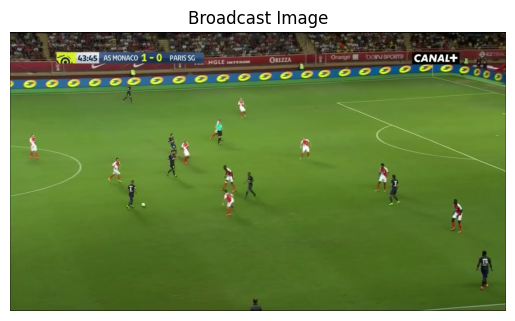

In [52]:
total_boxes = 0
total_misclassified = 0

# loop through each group and apply the code snippet to each image
for path in paths:
    temp_path = os.path.join(path, image_name)
    if os.path.exists(temp_path):
        image_path = temp_path
        break

if image_path is None:
    raise ValueError(f"Image file not found: {image_name}")

img = image.imread(image_path)
plt.imshow(img)
plt.title('Broadcast Image')
plt.axis('off')
plt.show()


In [53]:
def visualize_pre_process_crop(image, bbox): 
    H = image.shape[0]
    W = image.shape[1]

    x = int(bbox[0]*W)
    y = int(bbox[1]*H)
    w = int(bbox[2]*W)
    h = int(bbox[3]*H)
    
    #Extracting Crop from given image with bbox specs
    crop = image[y:y+h, x:x+w]
    crop = cv2.resize(crop, (20,40))
    
    fig, axes = plt.subplots(1,2)
    
    # Plot the cropped unfiltered image
    axes[0].imshow(crop)
    axes[0].set_title('Unfiltered Crop', fontsize=8)
    axes[0].axis('off')

    #Applying filters to the crop
    crop = cv2.medianBlur(crop,3)
    crop = cv2.bilateralFilter(crop,5,30,30)
    
    # Plot the second image in the second subplot
    axes[1].imshow(crop)
    axes[1].set_title('Filtered Crop', fontsize=8)
    axes[1].axis('off')    

    return crop

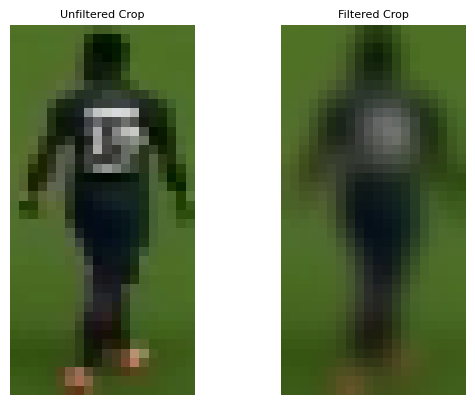

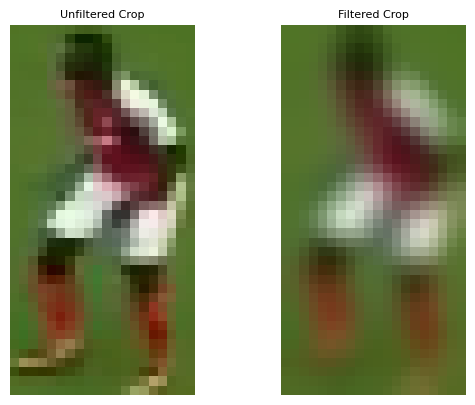

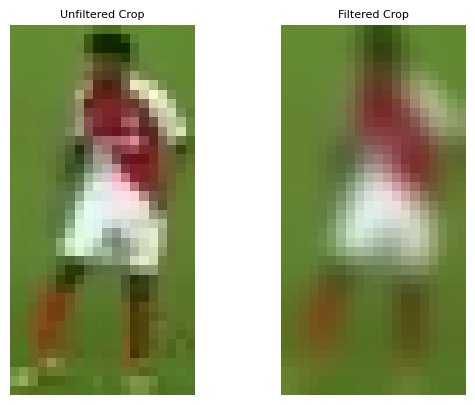

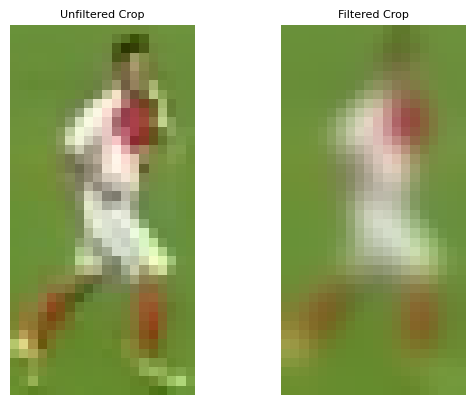

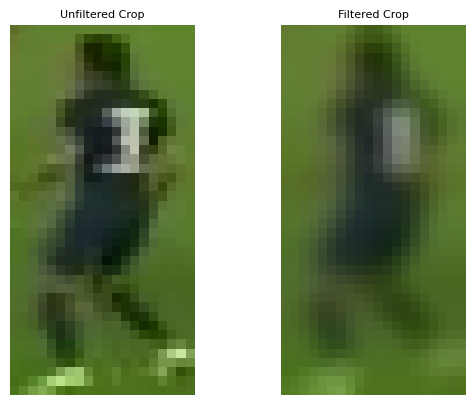

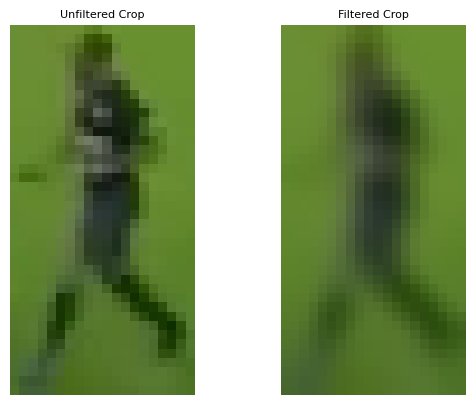

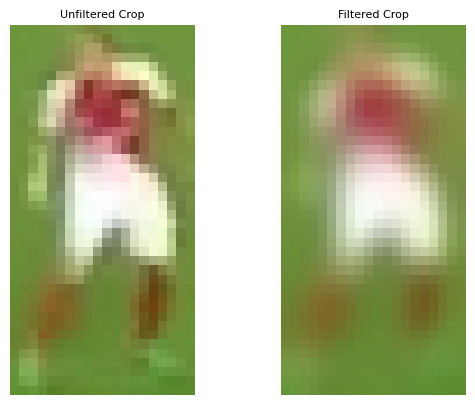

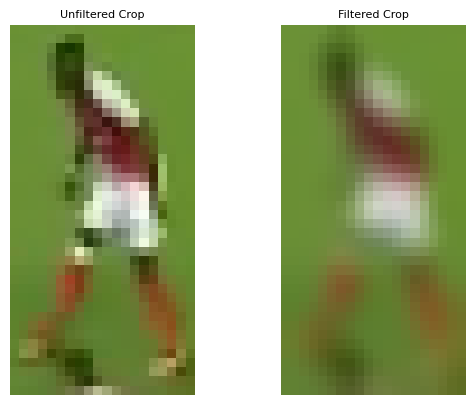

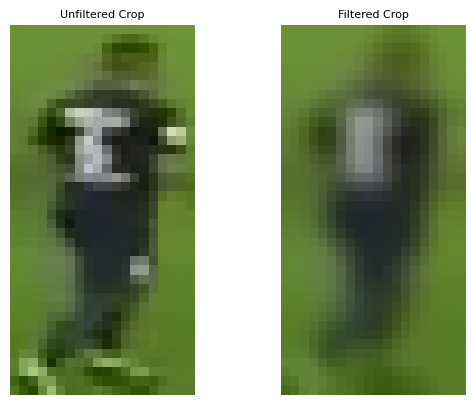

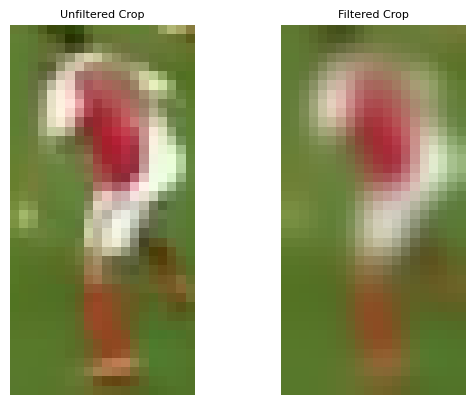

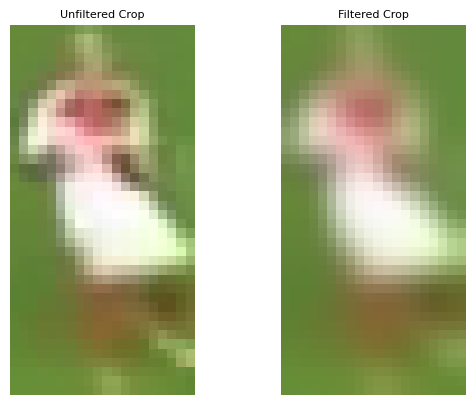

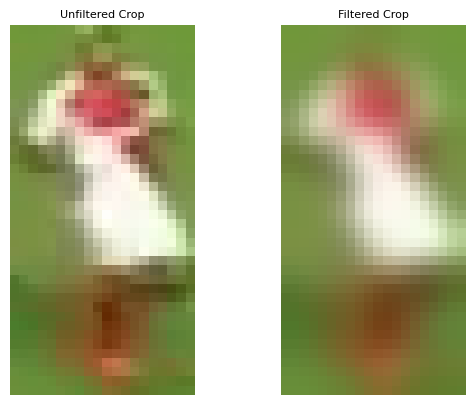

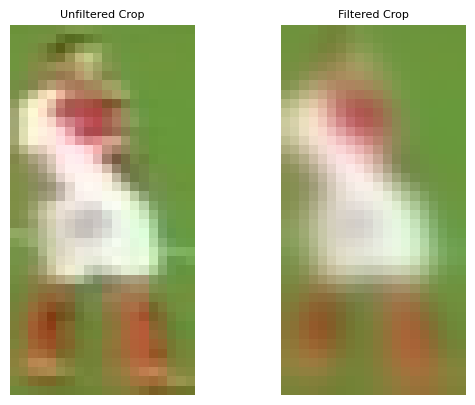

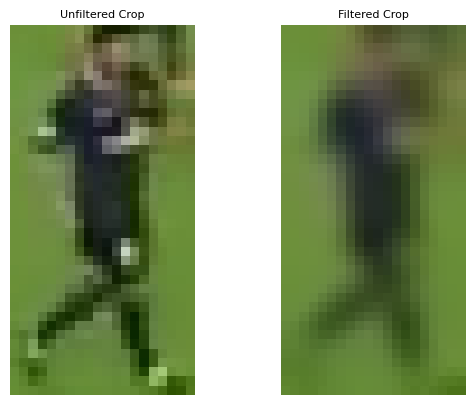

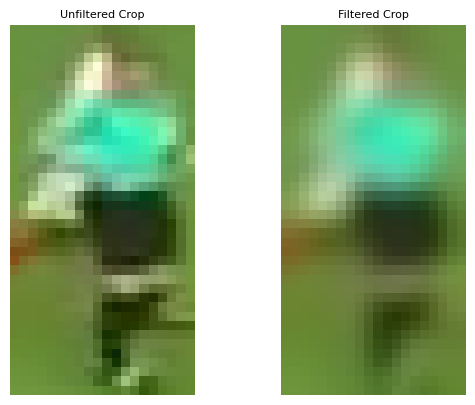

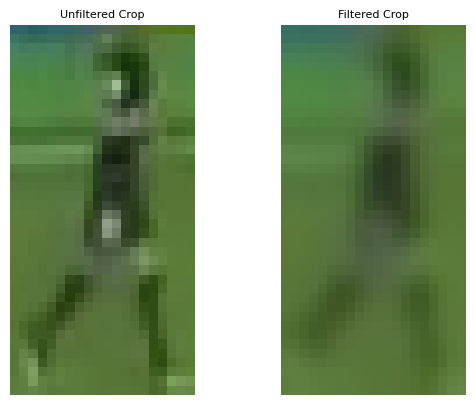

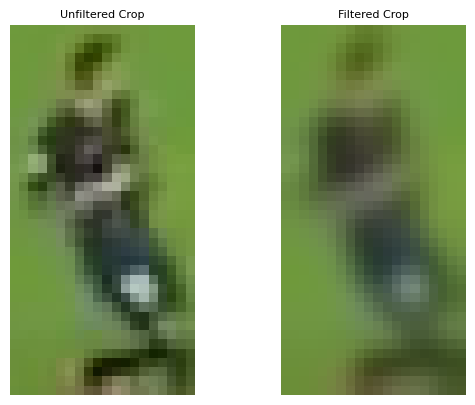

In [54]:
players_info = viz_df[viz_df['class'] == 1]

true_labels = np.array(players_info['team'].tolist(), dtype=np.int32)
num_cats = len(pd.unique(players_info['team'])) 

player_boxes = []
      
for index, row in players_info.iterrows():
    bbox = [row['x']-(row['w']/2), row['y']-(row['h']/2), row['w'], row['h']]
    crop = visualize_pre_process_crop(img, bbox)
    player_boxes.append(crop)
    plt.show()


In [55]:
# Flattening and Normalizing
player_boxes_reshaped = np.array(player_boxes).reshape(len(player_boxes),-1) 
player_boxes_reshaped = player_boxes_reshaped/255.0

#Creating Clustering Model object
cl = Clustimage(method='pca',
            embedding='tsne',
            grayscale=False,
            dim=(20,40),
            params_pca={'n_components':0.95},
            verbose=60)

#Fitting, Transforming and generating results
results = cl.fit_transform(player_boxes_reshaped,
                        cluster='agglomerative',
                        evaluate='silhouette',
                        metric='euclidean',
                        linkage='ward',
                        min_clust=num_cats,
                        max_clust=num_cats,
                        cluster_space='high')

pred_labels = results['labels']

#Converting the predicted labels to most accurate representation
res = formatPred(pred_labels)

if (calc_acc(res[0], true_labels) > calc_acc(res[1], true_labels)):
    acc = calc_acc(res[0], true_labels)
    preds = res[0]
else:
    acc = calc_acc(res[1], true_labels)
    preds = res[1]


print("name: {}, accuracy: {}, preds: {}, misclassified: {}, total boxes: {}".format(image_name, acc, preds, round(players_info.shape[0]*(1-acc)), players_info.shape[0]))


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2400] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2400] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Saving data in memory.
[clustimage] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clustimage] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 811.91it/s]
[clustimage] >DEBUG> [[2 1 1 1 2 2 1 1 2 1 1 1 1 2 3 2 2]]
[clustimage] >DEBUG> Iloc: [ True]
[clustimage] >DEBUG> silscores: [0.31691897]
[clustimage] >DEBUG> sillclust: [3.]
[clustimage] >DEBUG> clustlabx: [[2 1 1 1 2 2 1 1 2 1 1 1 1 2 3 2 2]]
[clustimage] >INFO> Compute dendrogram threshold.
[clustimage] >INFO> Optimal number clusters detected: [3].
[clustimage] >INFO> Fin.


name: image_vimp_689.png, accuracy: 1.0, preds: [0 1 1 1 0 0 1 1 0 1 1 1 1 0 2 0 0], misclassified: 0, total boxes: 17


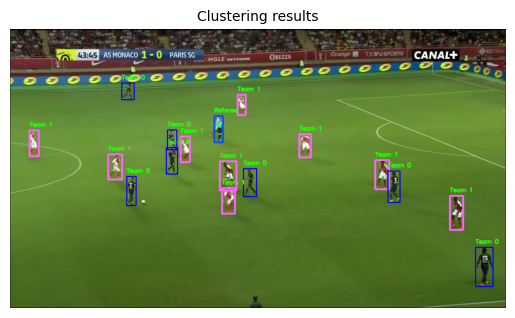

In [57]:
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

H = img.shape[0]
W = img.shape[1]

for index, row in players_info.iterrows():
    bbox = [row['x']-(row['w']/2), row['y']-(row['h']/2), row['w'], row['h']]
    
    x = int(bbox[0]*W)
    y = int(bbox[1]*H)
    w = int(bbox[2]*W)
    h = int(bbox[3]*H)
    
    if(int(row['pred_team']) == 0):
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(img_rgb, 'Team 0', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    elif(int(row['pred_team']) == 1):
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (255, 100, 255), 3)
        cv2.putText(img_rgb, 'Team 1', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    elif(int(row['pred_team']) == 2):
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0,85,255), 3)
        cv2.putText(img_rgb, 'Referee', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    elif(int(row['pred_team']) == 3):
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (128,128,128), 3)
        cv2.putText(img_rgb, 'Manager', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    
plt.imshow(img_rgb)
plt.title('Clustering results', fontsize=10)
plt.axis('off')
plt.show()

The clustering shows promising results, with almost all players correctly assigned the team labels. **We achieve ~$85\%$ team identification accuracy across all images in our dataset using the clustering technique.**